In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
from torch.utils.data.dataloader import DataLoader
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import networkx as nx
from tqdm import tqdm
import dgl
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import itertools

Running on the GPU


Using backend: pytorch


In [2]:
class Network(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        batch_size,
        with_batch_norm=True,
        activation=None
    ):
        super(Network, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
            self.layers.append(nn.BatchNorm1d(batch_size))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
                self.layers.append(nn.BatchNorm1d(batch_size))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out

In [38]:
class GraphNeuralNetwork(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        numMessagePassingIterations,
        withInputNetwork = True
    ):
        
        super(GraphNeuralNetwork, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.numMessagePassingIterations = numMessagePassingIterations
        self.withInputNetwork = withInputNetwork
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        edgeData = edges.data['feature'].repeat(edges.src['state'].shape[1], 1).T.unsqueeze(-1)
        
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData), -1))}
    
    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
#         numNodes, batchSize, stateSize = graph.ndata['state'].shape
#         return self.outputNetwork.forward(graph.ndata['state'])
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        if self.withInputNetwork:
            graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.max('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        output = torch.transpose(output, dim0=0, dim1=1)
        output = torch.squeeze(output, dim=-1)

        return output
    
    def update_states_in_graph(self, graph, state):
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        
        numGraphFeature = 6
        numGlobalStateInformation = 6
        numLocalStateInformation = 2
        numStateVar = state.shape[1] - 1 
        globalInformation = torch.cat((state[:, 0:5], state[:, -1].unsqueeze(1)), -1)
        
        numNodes = (numStateVar - 5) // 2

        nodeData = torch.empty((numNodes, state.shape[0], numGraphFeature + numGlobalStateInformation + numLocalStateInformation)).to(device)
        
        nodeData[:, :, 0:numGlobalStateInformation] = globalInformation
        
        for nodeIdx in range(numNodes):
            # Assign global features from graph
            nodeData[nodeIdx, :, numGlobalStateInformation:numGlobalStateInformation + numGraphFeature] = graph.ndata['feature'][nodeIdx]
            # Assign local state information
            nodeData[nodeIdx, :, numGlobalStateInformation + numGraphFeature] = state[:, 5 + nodeIdx]
            nodeData[nodeIdx, :, numGlobalStateInformation + numGraphFeature + 1] = state[:, 5 + numNodes + nodeIdx]
        
        if self.withInputNetwork:
            graph.ndata['input'] = nodeData        
        
        else:
            graph.ndata['state'] = nodeData

In [4]:
states = {}
actions = {}
rewards = {}
next_states = {}
dones = {}
env = {}

for morphIdx in range(7):

    prefix = '../datasets/{}/'.format(morphIdx)
    
    states[morphIdx] = np.load(prefix + 'states_array.npy')
    actions[morphIdx] = np.load(prefix + 'actions_array.npy')
    rewards[morphIdx] = np.load(prefix + 'rewards_array.npy')
    next_states[morphIdx] = np.load(prefix + 'next_states_array.npy')
    dones[morphIdx] = np.load(prefix + 'dones_array.npy')
    
    env[morphIdx] = HalfCheetahGraphEnv(None)
    env[morphIdx].set_morphology(morphIdx)
    env[morphIdx].reset()

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None


In [14]:
X_test = {}
X_train = {}
Y_test = {}
Y_train = {}

for morphIdx in range(7):
    X = np.concatenate((states[morphIdx], np.expand_dims(next_states[morphIdx][:, 0], axis=1)), -1)
    Y = actions[morphIdx]
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    X_test[morphIdx] = torch.from_numpy(X[:100000]).float()
    X_train[morphIdx] = torch.from_numpy(X[100000:]).float()
    Y = Y[permutation]
    Y_test[morphIdx] = torch.from_numpy(Y[:100000]).float()
    Y_train[morphIdx] = torch.from_numpy(Y[100000:]).float()

In [55]:
hidden_sizes = [64, 64]

inputSize = 14
stateSize = 32
messageSize = 32
outputSize = 1
numMessagePassingIterations = 4
batch_size = 1024
with_batch_norm=False
numBatchesPerTrainingStep = 4

inputNetwork = Network(inputSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
messageNetwork = Network(stateSize + 1, messageSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)
updateNetwork = Network(stateSize + messageSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
outputNetwork = Network(stateSize, outputSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)

lr = 1e-4

numTrainingBatches = int(np.ceil(X_train[0].shape[0] / batch_size))
numTestingBatches = int(np.ceil(X_test[0].shape[0] / batch_size))

gnn = GraphNeuralNetwork(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations).to(device)

optimizer = optim.Adam(itertools.chain(inputNetwork.parameters(), messageNetwork.parameters(), updateNetwork.parameters(), outputNetwork.parameters())
                       , lr, weight_decay=1e-5)


lmbda = lambda epoch: 0.8
lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lmbda)
criterion  = nn.SmoothL1Loss(reduction='none')

In [56]:
trainLosses = {}
testLosses = {}
validLosses = {}
trainingIdxs = [1, 2, 4, 5, 6]
validationIdxs = [0, 3]

inputNetworkGradients = []
messageNetworkGradients = []
updateNetworkGradients = []
outputNetworkGradients = []


for morphIdx in range(7):
    trainLosses[morphIdx] = []
    testLosses[morphIdx] = []
    validLosses[morphIdx] = []

for epoch in range(4):
    
    
    for morphIdx in trainingIdxs:
        permutation = np.random.permutation(X_train[morphIdx].shape[0])
        X_train[morphIdx] = X_train[morphIdx][permutation]
        Y_train[morphIdx] = Y_train[morphIdx][permutation]
        
    stepLoss = None
    graphs = []
    numAggregatedBatches = 0

    for batch in range(0, numTrainingBatches, numBatchesPerTrainingStep):
        
        inputNetwork.train()
        messageNetwork.train()
        updateNetwork.train()
        outputNetwork.train()
        
        t0 = time.time()
        
        for morphIdx in trainingIdxs:
            numNodes = (X_train[morphIdx].shape[1] - 6) // 2
            trainLosses[morphIdx].append(torch.zeros(numNodes))

        for batchOffset in range(numBatchesPerTrainingStep):
            
            if batch + batchOffset >= numTrainingBatches:
                break
                
            for morphIdx in trainingIdxs:
                graphs.append(env[morphIdx].get_graph()._get_dgl_graph())
                x = X_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)
                y = Y_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)

                y_hat = gnn.forward(graphs[-1], x)

                loss_tmp = criterion(y, y_hat).mean(dim=0)

                trainLosses[morphIdx][-1] += loss_tmp.cpu().detach() / numBatchesPerTrainingStep

                if stepLoss is None:
                    stepLoss = loss_tmp.mean()

                else:
                    stepLoss += loss_tmp.mean()
        
        optimizer.zero_grad()
        stepLoss.backward()
        
        
        s = 0
        for parameter in inputNetwork.parameters():
            s += torch.abs(parameter.grad).mean()
        inputNetworkGradients.append(s.item())

        s = 0
        for parameter in messageNetwork.parameters():
            s += torch.abs(parameter.grad).mean()
        messageNetworkGradients.append(s.item())

        s = 0        
        for parameter in updateNetwork.parameters():
            s += torch.abs(parameter.grad).mean()
        updateNetworkGradients.append(s.item())

        s = 0        
        for parameter in outputNetwork.parameters():
            s += torch.abs(parameter.grad).mean()
        outputNetworkGradients.append(s.item())

        optimizer.step()
        
        stepLoss = None
        graphs = []
        
        inputNetwork.eval()
        messageNetwork.eval()
        updateNetwork.eval()
        outputNetwork.eval()

        numBatchesForExectution = 50
        for morphIdx in trainingIdxs:
            numNodes = (X_train[morphIdx].shape[1] - 6) // 2
            testLosses[morphIdx].append(torch.zeros(numNodes))
            for batch_ in np.random.choice(np.arange(numTestingBatches-1), numBatchesForExectution):
                g = env[morphIdx].get_graph()._get_dgl_graph()
                x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                y_hat = gnn.forward(g, x)
                loss = criterion(y, y_hat).mean(dim=0)
                testLosses[morphIdx][-1] += loss.cpu().detach()
            testLosses[morphIdx][-1] /= numBatchesForExectution
        
        for morphIdx in validationIdxs:
            numNodes = (X_train[morphIdx].shape[1] - 6) // 2
            validLosses[morphIdx].append(torch.zeros(numNodes))
            for batch_ in np.random.choice(np.arange(numTestingBatches-1), numBatchesForExectution):

                g = env[morphIdx].get_graph()._get_dgl_graph()
                x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)

                y_hat = gnn.forward(g, x)
                loss = criterion(y, y_hat).mean(dim=0)

                validLosses[morphIdx][-1] += loss.cpu().detach()
            validLosses[morphIdx][-1] /= numBatchesForExectution

        print('\n************** Batch {} in {} **************\n'.format(batch, time.time() - t0))
        for morphIdx in trainingIdxs:
            print('Training Idx {} \nTrain Loss {} \nTest Loss {}\n'.format(morphIdx, trainLosses[morphIdx][-1], testLosses[morphIdx][-1]))
        for morphIdx in validationIdxs:
            print('Valid Idx {} | Loss {}'.format(morphIdx, validLosses[morphIdx][-1]))
            
        if batch % 20 ==0:
            print('Gradients: Input {} | Message {} | Update {} | Output {}'.format(
                inputNetworkGradients[-1], messageNetworkGradients[-1], updateNetworkGradients[-1], outputNetworkGradients[-1]))    
#         if batch % 100 == 99:
#             lr_scheduler.step()


************** Batch 0 in 3.5784902572631836 **************

Training Idx 1 
Train Loss tensor([0.4223, 0.4334, 0.3907, 0.4336]) 
Test Loss tensor([0.4226, 0.4309, 0.3921, 0.4327])

Training Idx 2 
Train Loss tensor([0.4131, 0.4549, 0.4709, 0.4407, 0.4409]) 
Test Loss tensor([0.4159, 0.4518, 0.4691, 0.4430, 0.4417])

Training Idx 4 
Train Loss tensor([0.4489, 0.4535, 0.4272, 0.4359, 0.3657, 0.4599, 0.4711]) 
Test Loss tensor([0.4481, 0.4553, 0.4315, 0.4355, 0.3694, 0.4612, 0.4689])

Training Idx 5 
Train Loss tensor([0.4528, 0.4214, 0.4528, 0.4511, 0.4269, 0.4422, 0.4708]) 
Test Loss tensor([0.4544, 0.4217, 0.4542, 0.4526, 0.4225, 0.4402, 0.4671])

Training Idx 6 
Train Loss tensor([0.4711, 0.4628, 0.4495, 0.4514, 0.4522, 0.4717, 0.3899, 0.4724]) 
Test Loss tensor([0.4686, 0.4633, 0.4524, 0.4537, 0.4546, 0.4705, 0.3906, 0.4699])

Valid Idx 0 | Loss tensor([0.4517, 0.4682, 0.4613, 0.4520, 0.4368, 0.4483])
Valid Idx 3 | Loss tensor([0.4535, 0.4514, 0.4452, 0.4445, 0.3495])
Gradients: In


************** Batch 36 in 3.6422650814056396 **************

Training Idx 1 
Train Loss tensor([0.4276, 0.4290, 0.4011, 0.4267]) 
Test Loss tensor([0.4263, 0.4263, 0.4032, 0.4272])

Training Idx 2 
Train Loss tensor([0.4131, 0.4515, 0.4539, 0.4487, 0.4412]) 
Test Loss tensor([0.4109, 0.4538, 0.4520, 0.4495, 0.4415])

Training Idx 4 
Train Loss tensor([0.4342, 0.4693, 0.4396, 0.4295, 0.3643, 0.4605, 0.4535]) 
Test Loss tensor([0.4332, 0.4719, 0.4407, 0.4311, 0.3667, 0.4597, 0.4521])

Training Idx 5 
Train Loss tensor([0.4697, 0.4106, 0.4687, 0.4637, 0.4185, 0.4320, 0.4538]) 
Test Loss tensor([0.4720, 0.4105, 0.4712, 0.4676, 0.4188, 0.4302, 0.4527])

Training Idx 6 
Train Loss tensor([0.4539, 0.4486, 0.4684, 0.4677, 0.4695, 0.4537, 0.3893, 0.4555]) 
Test Loss tensor([0.4528, 0.4483, 0.4690, 0.4689, 0.4714, 0.4533, 0.3893, 0.4530])

Valid Idx 0 | Loss tensor([0.4529, 0.4522, 0.4464, 0.4665, 0.4259, 0.4584])
Valid Idx 3 | Loss tensor([0.4697, 0.4690, 0.4587, 0.4511, 0.3567])

***********


************** Batch 72 in 3.6681034564971924 **************

Training Idx 1 
Train Loss tensor([0.4275, 0.4212, 0.4131, 0.4191]) 
Test Loss tensor([0.4299, 0.4211, 0.4141, 0.4217])

Training Idx 2 
Train Loss tensor([0.4090, 0.4558, 0.4368, 0.4520, 0.4426]) 
Test Loss tensor([0.4069, 0.4543, 0.4358, 0.4551, 0.4415])

Training Idx 4 
Train Loss tensor([0.4234, 0.4865, 0.4536, 0.4229, 0.3655, 0.4584, 0.4380]) 
Test Loss tensor([0.4207, 0.4887, 0.4515, 0.4255, 0.3635, 0.4587, 0.4356])

Training Idx 5 
Train Loss tensor([0.4870, 0.4003, 0.4857, 0.4824, 0.4143, 0.4220, 0.4401]) 
Test Loss tensor([0.4885, 0.4007, 0.4872, 0.4826, 0.4158, 0.4202, 0.4382])

Training Idx 6 
Train Loss tensor([0.4377, 0.4366, 0.4829, 0.4822, 0.4852, 0.4382, 0.3952, 0.4386]) 
Test Loss tensor([0.4366, 0.4347, 0.4854, 0.4842, 0.4882, 0.4366, 0.3888, 0.4367])

Valid Idx 0 | Loss tensor([0.4530, 0.4368, 0.4327, 0.4809, 0.4169, 0.4682])
Valid Idx 3 | Loss tensor([0.4854, 0.4849, 0.4728, 0.4574, 0.3636])

***********


************** Batch 108 in 3.7382805347442627 **************

Training Idx 1 
Train Loss tensor([0.4364, 0.4195, 0.4201, 0.4179]) 
Test Loss tensor([0.4354, 0.4182, 0.4248, 0.4170])

Training Idx 2 
Train Loss tensor([0.4020, 0.4562, 0.4225, 0.4595, 0.4418]) 
Test Loss tensor([0.4051, 0.4555, 0.4211, 0.4616, 0.4414])

Training Idx 4 
Train Loss tensor([0.4110, 0.5019, 0.4613, 0.4200, 0.3609, 0.4598, 0.4222]) 
Test Loss tensor([0.4084, 0.5043, 0.4599, 0.4202, 0.3610, 0.4585, 0.4211])

Training Idx 5 
Train Loss tensor([0.5034, 0.3900, 0.5015, 0.4966, 0.4123, 0.4124, 0.4256]) 
Test Loss tensor([0.5039, 0.3926, 0.5020, 0.4970, 0.4130, 0.4117, 0.4249])

Training Idx 6 
Train Loss tensor([0.4235, 0.4227, 0.4960, 0.4972, 0.5029, 0.4241, 0.3927, 0.4232]) 
Test Loss tensor([0.4231, 0.4225, 0.5000, 0.4984, 0.5035, 0.4220, 0.3875, 0.4219])

Valid Idx 0 | Loss tensor([0.4535, 0.4235, 0.4213, 0.4937, 0.4066, 0.4772])
Valid Idx 3 | Loss tensor([0.5008, 0.5008, 0.4857, 0.4630, 0.3710])

**********


************** Batch 144 in 3.6670353412628174 **************

Training Idx 1 
Train Loss tensor([0.4356, 0.4166, 0.4342, 0.4155]) 
Test Loss tensor([0.4384, 0.4154, 0.4344, 0.4133])

Training Idx 2 
Train Loss tensor([0.3985, 0.4575, 0.4110, 0.4662, 0.4443]) 
Test Loss tensor([0.4016, 0.4570, 0.4088, 0.4669, 0.4409])

Training Idx 4 
Train Loss tensor([0.3970, 0.5185, 0.4677, 0.4139, 0.3603, 0.4557, 0.4098]) 
Test Loss tensor([0.3989, 0.5178, 0.4683, 0.4146, 0.3598, 0.4583, 0.4085])

Training Idx 5 
Train Loss tensor([0.5158, 0.3865, 0.5144, 0.5070, 0.4101, 0.4073, 0.4161]) 
Test Loss tensor([0.5178, 0.3853, 0.5149, 0.5085, 0.4114, 0.4051, 0.4142])

Training Idx 6 
Train Loss tensor([0.4104, 0.4147, 0.5120, 0.5103, 0.5158, 0.4096, 0.3888, 0.4107]) 
Test Loss tensor([0.4112, 0.4115, 0.5127, 0.5105, 0.5172, 0.4102, 0.3889, 0.4093])

Valid Idx 0 | Loss tensor([0.4547, 0.4118, 0.4104, 0.5051, 0.3988, 0.4862])
Valid Idx 3 | Loss tensor([0.5141, 0.5138, 0.4978, 0.4676, 0.3773])

**********


************** Batch 180 in 3.7127628326416016 **************

Training Idx 1 
Train Loss tensor([0.4411, 0.4142, 0.4381, 0.4089]) 
Test Loss tensor([0.4416, 0.4125, 0.4390, 0.4115])

Training Idx 2 
Train Loss tensor([0.3963, 0.4594, 0.4012, 0.4658, 0.4408]) 
Test Loss tensor([0.4003, 0.4571, 0.4004, 0.4684, 0.4407])

Training Idx 4 
Train Loss tensor([0.3929, 0.5263, 0.4758, 0.4126, 0.3598, 0.4579, 0.4019]) 
Test Loss tensor([0.3919, 0.5267, 0.4723, 0.4115, 0.3576, 0.4581, 0.4004])

Training Idx 5 
Train Loss tensor([0.5269, 0.3830, 0.5216, 0.5160, 0.4103, 0.4018, 0.4087]) 
Test Loss tensor([0.5257, 0.3802, 0.5239, 0.5167, 0.4092, 0.4005, 0.4069])

Training Idx 6 
Train Loss tensor([0.4042, 0.4054, 0.5201, 0.5181, 0.5250, 0.4041, 0.3882, 0.4020]) 
Test Loss tensor([0.4033, 0.4053, 0.5211, 0.5192, 0.5255, 0.4022, 0.3871, 0.4007])

Valid Idx 0 | Loss tensor([0.4555, 0.4045, 0.4040, 0.5126, 0.3943, 0.4918])
Valid Idx 3 | Loss tensor([0.5220, 0.5227, 0.5051, 0.4719, 0.3838])
Gradients: 


************** Batch 216 in 4.170600414276123 **************

Training Idx 1 
Train Loss tensor([0.4428, 0.4129, 0.4433, 0.4085]) 
Test Loss tensor([0.4425, 0.4118, 0.4421, 0.4086])

Training Idx 2 
Train Loss tensor([0.3980, 0.4590, 0.3981, 0.4723, 0.4411]) 
Test Loss tensor([0.3983, 0.4581, 0.3952, 0.4713, 0.4413])

Training Idx 4 
Train Loss tensor([0.3891, 0.5284, 0.4782, 0.4116, 0.3548, 0.4568, 0.3954]) 
Test Loss tensor([0.3885, 0.5308, 0.4766, 0.4109, 0.3569, 0.4582, 0.3951])

Training Idx 5 
Train Loss tensor([0.5318, 0.3729, 0.5297, 0.5208, 0.4098, 0.4009, 0.4021]) 
Test Loss tensor([0.5309, 0.3778, 0.5292, 0.5209, 0.4081, 0.3976, 0.4024])

Training Idx 6 
Train Loss tensor([0.4007, 0.4042, 0.5253, 0.5245, 0.5317, 0.3989, 0.3890, 0.3952]) 
Test Loss tensor([0.3993, 0.4019, 0.5260, 0.5235, 0.5304, 0.3977, 0.3889, 0.3959])

Valid Idx 0 | Loss tensor([0.4555, 0.4004, 0.3995, 0.5172, 0.3914, 0.4945])
Valid Idx 3 | Loss tensor([0.5264, 0.5278, 0.5091, 0.4737, 0.3859])

***********


************** Batch 252 in 3.8306710720062256 **************

Training Idx 1 
Train Loss tensor([0.4485, 0.4125, 0.4449, 0.4100]) 
Test Loss tensor([0.4428, 0.4120, 0.4448, 0.4084])

Training Idx 2 
Train Loss tensor([0.3950, 0.4599, 0.3933, 0.4708, 0.4410]) 
Test Loss tensor([0.3985, 0.4576, 0.3927, 0.4718, 0.4414])

Training Idx 4 
Train Loss tensor([0.3884, 0.5322, 0.4761, 0.4089, 0.3540, 0.4547, 0.3926]) 
Test Loss tensor([0.3860, 0.5325, 0.4764, 0.4089, 0.3577, 0.4588, 0.3928])

Training Idx 5 
Train Loss tensor([0.5343, 0.3760, 0.5326, 0.5222, 0.4103, 0.3964, 0.3987]) 
Test Loss tensor([0.5328, 0.3765, 0.5319, 0.5225, 0.4072, 0.3971, 0.3999])

Training Idx 6 
Train Loss tensor([0.3978, 0.4009, 0.5261, 0.5267, 0.5332, 0.3960, 0.3830, 0.3925]) 
Test Loss tensor([0.3975, 0.4007, 0.5285, 0.5267, 0.5320, 0.3962, 0.3875, 0.3931])

Valid Idx 0 | Loss tensor([0.4556, 0.4002, 0.3983, 0.5178, 0.3906, 0.4962])
Valid Idx 3 | Loss tensor([0.5282, 0.5317, 0.5099, 0.4741, 0.3866])

**********


************** Batch 288 in 3.824230909347534 **************

Training Idx 1 
Train Loss tensor([0.4412, 0.4112, 0.4435, 0.4086]) 
Test Loss tensor([0.4419, 0.4100, 0.4449, 0.4079])

Training Idx 2 
Train Loss tensor([0.4012, 0.4595, 0.3909, 0.4734, 0.4419]) 
Test Loss tensor([0.4000, 0.4581, 0.3917, 0.4717, 0.4425])

Training Idx 4 
Train Loss tensor([0.3870, 0.5339, 0.4768, 0.4082, 0.3596, 0.4576, 0.3911]) 
Test Loss tensor([0.3860, 0.5332, 0.4770, 0.4089, 0.3571, 0.4575, 0.3911])

Training Idx 5 
Train Loss tensor([0.5331, 0.3785, 0.5335, 0.5228, 0.4086, 0.3970, 0.3999]) 
Test Loss tensor([0.5331, 0.3770, 0.5338, 0.5223, 0.4079, 0.3976, 0.3991])

Training Idx 6 
Train Loss tensor([0.3967, 0.3999, 0.5268, 0.5273, 0.5324, 0.3968, 0.3857, 0.3912]) 
Test Loss tensor([0.3973, 0.4003, 0.5283, 0.5275, 0.5318, 0.3960, 0.3887, 0.3912])

Valid Idx 0 | Loss tensor([0.4553, 0.3995, 0.3960, 0.5185, 0.3908, 0.4973])
Valid Idx 3 | Loss tensor([0.5285, 0.5331, 0.5101, 0.4748, 0.3866])

***********


************** Batch 324 in 4.100500106811523 **************

Training Idx 1 
Train Loss tensor([0.4401, 0.4078, 0.4428, 0.4099]) 
Test Loss tensor([0.4424, 0.4107, 0.4441, 0.4069])

Training Idx 2 
Train Loss tensor([0.4000, 0.4564, 0.3890, 0.4722, 0.4421]) 
Test Loss tensor([0.3990, 0.4578, 0.3896, 0.4707, 0.4414])

Training Idx 4 
Train Loss tensor([0.3882, 0.5303, 0.4776, 0.4074, 0.3607, 0.4608, 0.3897]) 
Test Loss tensor([0.3870, 0.5318, 0.4763, 0.4076, 0.3567, 0.4574, 0.3900])

Training Idx 5 
Train Loss tensor([0.5309, 0.3732, 0.5356, 0.5199, 0.4088, 0.3995, 0.3984]) 
Test Loss tensor([0.5324, 0.3777, 0.5352, 0.5215, 0.4082, 0.3981, 0.3976])

Training Idx 6 
Train Loss tensor([0.3973, 0.4000, 0.5263, 0.5307, 0.5320, 0.3976, 0.3868, 0.3886]) 
Test Loss tensor([0.3976, 0.4011, 0.5271, 0.5294, 0.5314, 0.3969, 0.3878, 0.3900])

Valid Idx 0 | Loss tensor([0.4559, 0.3998, 0.3951, 0.5173, 0.3915, 0.4985])
Valid Idx 3 | Loss tensor([0.5278, 0.5347, 0.5092, 0.4734, 0.3867])

***********


************** Batch 360 in 3.9559988975524902 **************

Training Idx 1 
Train Loss tensor([0.4390, 0.4088, 0.4439, 0.4081]) 
Test Loss tensor([0.4413, 0.4101, 0.4429, 0.4059])

Training Idx 2 
Train Loss tensor([0.3986, 0.4595, 0.3883, 0.4679, 0.4405]) 
Test Loss tensor([0.3995, 0.4581, 0.3878, 0.4716, 0.4423])

Training Idx 4 
Train Loss tensor([0.3869, 0.5302, 0.4774, 0.4106, 0.3598, 0.4571, 0.3876]) 
Test Loss tensor([0.3876, 0.5307, 0.4766, 0.4073, 0.3574, 0.4573, 0.3875])

Training Idx 5 
Train Loss tensor([0.5315, 0.3753, 0.5378, 0.5221, 0.4085, 0.4006, 0.3960]) 
Test Loss tensor([0.5319, 0.3786, 0.5380, 0.5209, 0.4090, 0.3985, 0.3955])

Training Idx 6 
Train Loss tensor([0.3985, 0.4012, 0.5264, 0.5327, 0.5300, 0.3982, 0.3874, 0.3879]) 
Test Loss tensor([0.3983, 0.4019, 0.5265, 0.5318, 0.5300, 0.3973, 0.3870, 0.3879])

Valid Idx 0 | Loss tensor([0.4553, 0.4014, 0.3936, 0.5166, 0.3913, 0.4997])
Valid Idx 3 | Loss tensor([0.5280, 0.5376, 0.5083, 0.4728, 0.3895])
Gradients: 


************** Batch 396 in 3.9033148288726807 **************

Training Idx 1 
Train Loss tensor([0.4406, 0.4118, 0.4469, 0.4016]) 
Test Loss tensor([0.4408, 0.4088, 0.4402, 0.4048])

Training Idx 2 
Train Loss tensor([0.3985, 0.4601, 0.3847, 0.4733, 0.4408]) 
Test Loss tensor([0.3982, 0.4576, 0.3848, 0.4705, 0.4422])

Training Idx 4 
Train Loss tensor([0.3885, 0.5290, 0.4785, 0.4059, 0.3596, 0.4570, 0.3856]) 
Test Loss tensor([0.3889, 0.5283, 0.4739, 0.4060, 0.3573, 0.4576, 0.3842])

Training Idx 5 
Train Loss tensor([0.5301, 0.3771, 0.5395, 0.5202, 0.4046, 0.4004, 0.3950]) 
Test Loss tensor([0.5302, 0.3786, 0.5409, 0.5180, 0.4080, 0.4000, 0.3930])

Training Idx 6 
Train Loss tensor([0.3994, 0.4024, 0.5227, 0.5336, 0.5299, 0.3999, 0.3937, 0.3860]) 
Test Loss tensor([0.3997, 0.4034, 0.5241, 0.5351, 0.5283, 0.3999, 0.3867, 0.3851])

Valid Idx 0 | Loss tensor([0.4553, 0.4030, 0.3913, 0.5152, 0.3925, 0.5021])
Valid Idx 3 | Loss tensor([0.5254, 0.5400, 0.5060, 0.4726, 0.3900])

**********


************** Batch 432 in 3.740424871444702 **************

Training Idx 1 
Train Loss tensor([0.4426, 0.4100, 0.4382, 0.4033]) 
Test Loss tensor([0.4428, 0.4081, 0.4396, 0.4043])

Training Idx 2 
Train Loss tensor([0.3999, 0.4583, 0.3817, 0.4679, 0.4423]) 
Test Loss tensor([0.4005, 0.4574, 0.3796, 0.4695, 0.4420])

Training Idx 4 
Train Loss tensor([0.3898, 0.5246, 0.4741, 0.4024, 0.3596, 0.4581, 0.3794]) 
Test Loss tensor([0.3899, 0.5255, 0.4722, 0.4048, 0.3574, 0.4571, 0.3795])

Training Idx 5 
Train Loss tensor([0.5285, 0.3818, 0.5463, 0.5172, 0.4132, 0.4013, 0.3898]) 
Test Loss tensor([0.5284, 0.3805, 0.5467, 0.5158, 0.4091, 0.4004, 0.3882])

Training Idx 6 
Train Loss tensor([0.4011, 0.4047, 0.5202, 0.5386, 0.5268, 0.4028, 0.3843, 0.3817]) 
Test Loss tensor([0.4013, 0.4057, 0.5205, 0.5397, 0.5256, 0.4024, 0.3867, 0.3801])

Valid Idx 0 | Loss tensor([0.4556, 0.4054, 0.3866, 0.5123, 0.3940, 0.5062])
Valid Idx 3 | Loss tensor([0.5238, 0.5463, 0.5045, 0.4714, 0.3945])

***********


************** Batch 468 in 3.913914680480957 **************

Training Idx 1 
Train Loss tensor([0.4446, 0.4083, 0.4329, 0.4052]) 
Test Loss tensor([0.4419, 0.4060, 0.4372, 0.4025])

Training Idx 2 
Train Loss tensor([0.4010, 0.4559, 0.3721, 0.4663, 0.4388]) 
Test Loss tensor([0.3991, 0.4571, 0.3691, 0.4677, 0.4426])

Training Idx 4 
Train Loss tensor([0.3912, 0.5244, 0.4694, 0.3991, 0.3581, 0.4555, 0.3706]) 
Test Loss tensor([0.3894, 0.5232, 0.4712, 0.4015, 0.3580, 0.4576, 0.3688])

Training Idx 5 
Train Loss tensor([0.5286, 0.3827, 0.5566, 0.5168, 0.4125, 0.4041, 0.3798]) 
Test Loss tensor([0.5276, 0.3819, 0.5583, 0.5138, 0.4093, 0.4028, 0.3791])

Training Idx 6 
Train Loss tensor([0.4030, 0.4055, 0.5199, 0.5505, 0.5236, 0.4050, 0.3856, 0.3710]) 
Test Loss tensor([0.4015, 0.4075, 0.5180, 0.5504, 0.5228, 0.4045, 0.3883, 0.3689])

Valid Idx 0 | Loss tensor([0.4553, 0.4082, 0.3784, 0.5105, 0.3954, 0.5131])
Valid Idx 3 | Loss tensor([0.5229, 0.5577, 0.5022, 0.4712, 0.4000])

***********


************** Batch 504 in 3.990943431854248 **************

Training Idx 1 
Train Loss tensor([0.4404, 0.4022, 0.4370, 0.3968]) 
Test Loss tensor([0.4413, 0.4019, 0.4353, 0.3964])

Training Idx 2 
Train Loss tensor([0.4035, 0.4584, 0.3538, 0.4694, 0.4411]) 
Test Loss tensor([0.3995, 0.4562, 0.3523, 0.4665, 0.4427])

Training Idx 4 
Train Loss tensor([0.3921, 0.5224, 0.4721, 0.3990, 0.3552, 0.4584, 0.3536]) 
Test Loss tensor([0.3897, 0.5204, 0.4685, 0.3957, 0.3590, 0.4585, 0.3519])

Training Idx 5 
Train Loss tensor([0.5293, 0.3850, 0.5755, 0.5112, 0.4084, 0.4037, 0.3654]) 
Test Loss tensor([0.5285, 0.3841, 0.5776, 0.5110, 0.4101, 0.4041, 0.3644])

Training Idx 6 
Train Loss tensor([0.3995, 0.4115, 0.5171, 0.5679, 0.5206, 0.4069, 0.3828, 0.3557]) 
Test Loss tensor([0.4014, 0.4097, 0.5150, 0.5694, 0.5199, 0.4071, 0.3887, 0.3514])

Valid Idx 0 | Loss tensor([0.4558, 0.4104, 0.3640, 0.5076, 0.3975, 0.5263])
Valid Idx 3 | Loss tensor([0.5224, 0.5778, 0.4995, 0.4682, 0.4111])

***********


************** Batch 540 in 4.046449661254883 **************

Training Idx 1 
Train Loss tensor([0.4423, 0.3957, 0.4281, 0.3878]) 
Test Loss tensor([0.4389, 0.3984, 0.4276, 0.3920])

Training Idx 2 
Train Loss tensor([0.4026, 0.4554, 0.3325, 0.4622, 0.4446]) 
Test Loss tensor([0.3995, 0.4561, 0.3295, 0.4625, 0.4435])

Training Idx 4 
Train Loss tensor([0.3928, 0.5137, 0.4628, 0.3866, 0.3581, 0.4588, 0.3313]) 
Test Loss tensor([0.3916, 0.5116, 0.4624, 0.3888, 0.3588, 0.4583, 0.3293])

Training Idx 5 
Train Loss tensor([0.5254, 0.3887, 0.6017, 0.5038, 0.4129, 0.4075, 0.3452]) 
Test Loss tensor([0.5250, 0.3899, 0.6039, 0.5035, 0.4124, 0.4093, 0.3438])

Training Idx 6 
Train Loss tensor([0.4039, 0.4149, 0.5071, 0.5918, 0.5124, 0.4129, 0.3915, 0.3316]) 
Test Loss tensor([0.4042, 0.4159, 0.5046, 0.5935, 0.5114, 0.4145, 0.3874, 0.3289])

Valid Idx 0 | Loss tensor([0.4546, 0.4196, 0.3461, 0.5010, 0.4040, 0.5424])
Valid Idx 3 | Loss tensor([0.5161, 0.6057, 0.4921, 0.4646, 0.4237])
Gradients: I


************** Batch 576 in 3.8476803302764893 **************

Training Idx 1 
Train Loss tensor([0.4364, 0.3999, 0.4170, 0.3885]) 
Test Loss tensor([0.4356, 0.3923, 0.4156, 0.3824])

Training Idx 2 
Train Loss tensor([0.4019, 0.4550, 0.3009, 0.4561, 0.4454]) 
Test Loss tensor([0.4009, 0.4547, 0.2964, 0.4556, 0.4485])

Training Idx 4 
Train Loss tensor([0.3946, 0.4972, 0.4532, 0.3841, 0.3596, 0.4585, 0.3003]) 
Test Loss tensor([0.3948, 0.4969, 0.4516, 0.3795, 0.3613, 0.4593, 0.2964])

Training Idx 5 
Train Loss tensor([0.5201, 0.4000, 0.6374, 0.4931, 0.4162, 0.4184, 0.3213]) 
Test Loss tensor([0.5196, 0.3994, 0.6432, 0.4900, 0.4133, 0.4197, 0.3158])

Training Idx 6 
Train Loss tensor([0.4074, 0.4251, 0.4891, 0.6301, 0.4982, 0.4259, 0.3843, 0.2990]) 
Test Loss tensor([0.4078, 0.4258, 0.4873, 0.6291, 0.4966, 0.4275, 0.3886, 0.2958])

Valid Idx 0 | Loss tensor([0.4535, 0.4354, 0.3191, 0.4879, 0.4140, 0.5674])
Valid Idx 3 | Loss tensor([0.5054, 0.6460, 0.4815, 0.4585, 0.4455])

**********


************** Batch 612 in 3.774143695831299 **************

Training Idx 1 
Train Loss tensor([0.4300, 0.3860, 0.4014, 0.3742]) 
Test Loss tensor([0.4298, 0.3856, 0.3997, 0.3715])

Training Idx 2 
Train Loss tensor([0.4012, 0.4528, 0.2548, 0.4456, 0.4546]) 
Test Loss tensor([0.4008, 0.4535, 0.2484, 0.4469, 0.4541])

Training Idx 4 
Train Loss tensor([0.3904, 0.4826, 0.4401, 0.3690, 0.3629, 0.4600, 0.2523]) 
Test Loss tensor([0.3909, 0.4823, 0.4377, 0.3667, 0.3645, 0.4608, 0.2470])

Training Idx 5 
Train Loss tensor([0.5195, 0.4099, 0.6954, 0.4772, 0.4163, 0.4305, 0.2791]) 
Test Loss tensor([0.5195, 0.4124, 0.7030, 0.4758, 0.4163, 0.4324, 0.2745])

Training Idx 6 
Train Loss tensor([0.4074, 0.4306, 0.4667, 0.6841, 0.4801, 0.4369, 0.3888, 0.2520]) 
Test Loss tensor([0.4053, 0.4313, 0.4652, 0.6864, 0.4780, 0.4367, 0.3907, 0.2465])

Valid Idx 0 | Loss tensor([0.4543, 0.4561, 0.2812, 0.4750, 0.4298, 0.6094])
Valid Idx 3 | Loss tensor([0.4904, 0.7110, 0.4718, 0.4500, 0.4826])

***********


************** Batch 648 in 3.6949801445007324 **************

Training Idx 1 
Train Loss tensor([0.4224, 0.3773, 0.3795, 0.3639]) 
Test Loss tensor([0.4170, 0.3786, 0.3782, 0.3607])

Training Idx 2 
Train Loss tensor([0.4000, 0.4519, 0.1942, 0.4379, 0.4696]) 
Test Loss tensor([0.3992, 0.4528, 0.1857, 0.4359, 0.4697])

Training Idx 4 
Train Loss tensor([0.3660, 0.4711, 0.4209, 0.3501, 0.3655, 0.4639, 0.1924]) 
Test Loss tensor([0.3649, 0.4684, 0.4197, 0.3553, 0.3671, 0.4637, 0.1840])

Training Idx 5 
Train Loss tensor([0.5291, 0.4266, 0.7777, 0.4621, 0.4199, 0.4487, 0.2261]) 
Test Loss tensor([0.5297, 0.4299, 0.7859, 0.4589, 0.4174, 0.4517, 0.2240])

Training Idx 6 
Train Loss tensor([0.3892, 0.4180, 0.4393, 0.7515, 0.4568, 0.4294, 0.3920, 0.1912]) 
Test Loss tensor([0.3855, 0.4123, 0.4355, 0.7619, 0.4528, 0.4260, 0.3915, 0.1838])

Valid Idx 0 | Loss tensor([0.4566, 0.4856, 0.2339, 0.4607, 0.4502, 0.6666])
Valid Idx 3 | Loss tensor([0.4757, 0.8021, 0.4720, 0.4392, 0.5375])

**********


************** Batch 684 in 3.7576911449432373 **************

Training Idx 1 
Train Loss tensor([0.3931, 0.3888, 0.3534, 0.3596]) 
Test Loss tensor([0.3891, 0.3797, 0.3509, 0.3555])

Training Idx 2 
Train Loss tensor([0.3960, 0.4574, 0.1237, 0.4211, 0.5054]) 
Test Loss tensor([0.3994, 0.4578, 0.1137, 0.4193, 0.5035])

Training Idx 4 
Train Loss tensor([0.3004, 0.4543, 0.4020, 0.3464, 0.3730, 0.4753, 0.1196]) 
Test Loss tensor([0.2895, 0.4495, 0.4002, 0.3515, 0.3713, 0.4790, 0.1106])

Training Idx 5 
Train Loss tensor([0.5412, 0.4260, 0.8750, 0.4460, 0.4169, 0.4721, 0.1677]) 
Test Loss tensor([0.5384, 0.4221, 0.8833, 0.4431, 0.4163, 0.4747, 0.1629])

Training Idx 6 
Train Loss tensor([0.3331, 0.3383, 0.4080, 0.8383, 0.4160, 0.3662, 0.3994, 0.1185]) 
Test Loss tensor([0.3236, 0.3245, 0.4078, 0.8507, 0.4115, 0.3534, 0.3990, 0.1104])

Valid Idx 0 | Loss tensor([0.4619, 0.5170, 0.1818, 0.4381, 0.4734, 0.7410])
Valid Idx 3 | Loss tensor([0.4963, 0.9224, 0.5065, 0.4314, 0.6209])

**********


************** Batch 720 in 3.3507723808288574 **************

Training Idx 1 
Train Loss tensor([0.3503, 0.3805, 0.3244, 0.3612]) 
Test Loss tensor([0.3451, 0.3804, 0.3213, 0.3612])

Training Idx 2 
Train Loss tensor([0.4163, 0.4779, 0.0618, 0.4030, 0.5243]) 
Test Loss tensor([0.4183, 0.4797, 0.0583, 0.4018, 0.5382])

Training Idx 4 
Train Loss tensor([0.2179, 0.3867, 0.3887, 0.3534, 0.3811, 0.5218, 0.0631]) 
Test Loss tensor([0.2132, 0.3763, 0.3924, 0.3550, 0.3906, 0.5247, 0.0555])

Training Idx 5 
Train Loss tensor([0.4423, 0.3673, 0.9242, 0.4075, 0.4294, 0.4967, 0.1216]) 
Test Loss tensor([0.4259, 0.3533, 0.9219, 0.4007, 0.4299, 0.5006, 0.1202])

Training Idx 6 
Train Loss tensor([0.2449, 0.2107, 0.3664, 0.8910, 0.3565, 0.2736, 0.4089, 0.0578]) 
Test Loss tensor([0.2360, 0.2001, 0.3582, 0.8908, 0.3505, 0.2668, 0.4101, 0.0535])

Valid Idx 0 | Loss tensor([0.4659, 0.5306, 0.1442, 0.3815, 0.4782, 0.7869])
Valid Idx 3 | Loss tensor([0.5198, 1.0203, 0.5139, 0.4384, 0.6927])
Gradients: 


************** Batch 756 in 3.312621593475342 **************

Training Idx 1 
Train Loss tensor([0.3168, 0.3598, 0.3000, 0.3689]) 
Test Loss tensor([0.3182, 0.3557, 0.2962, 0.3542])

Training Idx 2 
Train Loss tensor([0.4545, 0.4831, 0.0383, 0.3833, 0.5667]) 
Test Loss tensor([0.4514, 0.4860, 0.0371, 0.3807, 0.5707])

Training Idx 4 
Train Loss tensor([0.1828, 0.3232, 0.3818, 0.3667, 0.4228, 0.5555, 0.0385]) 
Test Loss tensor([0.1797, 0.3182, 0.3856, 0.3660, 0.4196, 0.5556, 0.0350])

Training Idx 5 
Train Loss tensor([0.3365, 0.3008, 0.7999, 0.3621, 0.4446, 0.5221, 0.1010]) 
Test Loss tensor([0.3270, 0.2940, 0.7629, 0.3541, 0.4413, 0.5299, 0.1011])

Training Idx 6 
Train Loss tensor([0.2056, 0.1381, 0.3162, 0.8240, 0.3074, 0.2356, 0.4198, 0.0316]) 
Test Loss tensor([0.2058, 0.1346, 0.3126, 0.8067, 0.3041, 0.2396, 0.4176, 0.0309])

Valid Idx 0 | Loss tensor([0.4583, 0.5523, 0.1280, 0.3386, 0.4597, 0.7179])
Valid Idx 3 | Loss tensor([0.4393, 1.0184, 0.4185, 0.4595, 0.7043])

***********


************** Batch 792 in 3.4306488037109375 **************

Training Idx 1 
Train Loss tensor([0.3063, 0.2860, 0.2747, 0.3228]) 
Test Loss tensor([0.3048, 0.2869, 0.2766, 0.3226])

Training Idx 2 
Train Loss tensor([0.4897, 0.4771, 0.0251, 0.3667, 0.6173]) 
Test Loss tensor([0.4927, 0.4853, 0.0241, 0.3639, 0.6089])

Training Idx 4 
Train Loss tensor([0.1726, 0.2785, 0.3777, 0.3677, 0.4550, 0.5527, 0.0264]) 
Test Loss tensor([0.1665, 0.2741, 0.3797, 0.3755, 0.4510, 0.5563, 0.0259])

Training Idx 5 
Train Loss tensor([0.2797, 0.2613, 0.4015, 0.3188, 0.4520, 0.5510, 0.0777]) 
Test Loss tensor([0.2738, 0.2636, 0.3801, 0.3186, 0.4537, 0.5604, 0.0779])

Training Idx 6 
Train Loss tensor([0.2020, 0.0961, 0.2841, 0.5947, 0.2692, 0.2336, 0.4271, 0.0191]) 
Test Loss tensor([0.1921, 0.0873, 0.2817, 0.5577, 0.2663, 0.2275, 0.4293, 0.0171])

Valid Idx 0 | Loss tensor([0.4561, 0.5719, 0.1100, 0.3067, 0.4415, 0.4443])
Valid Idx 3 | Loss tensor([0.3166, 0.8919, 0.3155, 0.4912, 0.6193])

**********


************** Batch 828 in 3.2474989891052246 **************

Training Idx 1 
Train Loss tensor([0.2987, 0.2959, 0.2552, 0.2796]) 
Test Loss tensor([0.2905, 0.2934, 0.2529, 0.2644])

Training Idx 2 
Train Loss tensor([0.5049, 0.4971, 0.0174, 0.3549, 0.7146]) 
Test Loss tensor([0.5112, 0.4988, 0.0164, 0.3535, 0.7235])

Training Idx 4 
Train Loss tensor([0.1490, 0.2413, 0.3670, 0.3811, 0.4704, 0.5492, 0.0194]) 
Test Loss tensor([0.1470, 0.2365, 0.3732, 0.3931, 0.4794, 0.5476, 0.0179])

Training Idx 5 
Train Loss tensor([0.2397, 0.2539, 0.2826, 0.2832, 0.4671, 0.5913, 0.0651]) 
Test Loss tensor([0.2362, 0.2573, 0.2768, 0.2847, 0.4626, 0.5887, 0.0650])

Training Idx 6 
Train Loss tensor([0.1384, 0.0643, 0.2504, 0.2849, 0.2350, 0.2215, 0.4345, 0.0093]) 
Test Loss tensor([0.1320, 0.0624, 0.2460, 0.2752, 0.2301, 0.2118, 0.4448, 0.0089])

Valid Idx 0 | Loss tensor([0.4636, 0.5745, 0.1015, 0.2762, 0.4588, 0.2986])
Valid Idx 3 | Loss tensor([0.2683, 0.6064, 0.2745, 0.4981, 0.5657])

**********


************** Batch 864 in 3.2693779468536377 **************

Training Idx 1 
Train Loss tensor([0.2782, 0.2917, 0.2356, 0.2663]) 
Test Loss tensor([0.2752, 0.2925, 0.2348, 0.2663])

Training Idx 2 
Train Loss tensor([0.5147, 0.5035, 0.0124, 0.3442, 0.7295]) 
Test Loss tensor([0.5139, 0.5077, 0.0136, 0.3452, 0.7226])

Training Idx 4 
Train Loss tensor([0.1377, 0.2050, 0.3616, 0.3745, 0.4661, 0.5401, 0.0155]) 
Test Loss tensor([0.1310, 0.2010, 0.3565, 0.3774, 0.4641, 0.5372, 0.0151])

Training Idx 5 
Train Loss tensor([0.2064, 0.2497, 0.2447, 0.2658, 0.4806, 0.6240, 0.0599]) 
Test Loss tensor([0.2040, 0.2571, 0.2484, 0.2650, 0.4813, 0.6262, 0.0608])

Training Idx 6 
Train Loss tensor([0.1029, 0.0560, 0.2190, 0.2428, 0.1976, 0.1828, 0.4643, 0.0067]) 
Test Loss tensor([0.1031, 0.0563, 0.2131, 0.2398, 0.1951, 0.1896, 0.4621, 0.0070])

Valid Idx 0 | Loss tensor([0.4871, 0.6295, 0.0981, 0.2512, 0.4690, 0.2740])
Valid Idx 3 | Loss tensor([0.2919, 0.8115, 0.2605, 0.4991, 0.5994])

**********


************** Batch 20 in 3.2987489700317383 **************

Training Idx 1 
Train Loss tensor([0.2727, 0.2880, 0.2214, 0.2876]) 
Test Loss tensor([0.2641, 0.2840, 0.2202, 0.2786])

Training Idx 2 
Train Loss tensor([0.4868, 0.5099, 0.0161, 0.3318, 0.6636]) 
Test Loss tensor([0.4940, 0.5081, 0.0151, 0.3336, 0.6641])

Training Idx 4 
Train Loss tensor([0.1282, 0.1740, 0.3423, 0.3623, 0.4484, 0.5388, 0.0176]) 
Test Loss tensor([0.1286, 0.1703, 0.3423, 0.3689, 0.4497, 0.5282, 0.0160])

Training Idx 5 
Train Loss tensor([0.1830, 0.2575, 0.2468, 0.2581, 0.4919, 0.6630, 0.0588]) 
Test Loss tensor([0.1806, 0.2627, 0.2423, 0.2495, 0.4883, 0.6683, 0.0626])

Training Idx 6 
Train Loss tensor([0.0980, 0.0578, 0.1875, 0.2222, 0.1675, 0.1814, 0.4820, 0.0087]) 
Test Loss tensor([0.0989, 0.0603, 0.1854, 0.2227, 0.1643, 0.1747, 0.4753, 0.0085])

Valid Idx 0 | Loss tensor([0.5047, 0.7015, 0.0995, 0.2279, 0.4844, 0.2690])
Valid Idx 3 | Loss tensor([0.3624, 0.9659, 0.2672, 0.4728, 0.6631])
Gradients: I


************** Batch 56 in 3.326828956604004 **************

Training Idx 1 
Train Loss tensor([0.2675, 0.2692, 0.2106, 0.2742]) 
Test Loss tensor([0.2569, 0.2852, 0.2074, 0.2703])

Training Idx 2 
Train Loss tensor([0.4829, 0.5337, 0.0164, 0.3314, 0.6425]) 
Test Loss tensor([0.4874, 0.5236, 0.0165, 0.3265, 0.6582])

Training Idx 4 
Train Loss tensor([0.1319, 0.1436, 0.3190, 0.3643, 0.4403, 0.5220, 0.0203]) 
Test Loss tensor([0.1218, 0.1409, 0.3302, 0.3635, 0.4435, 0.5290, 0.0168])

Training Idx 5 
Train Loss tensor([0.1657, 0.2734, 0.2270, 0.2362, 0.5005, 0.6865, 0.0639]) 
Test Loss tensor([0.1557, 0.2659, 0.2233, 0.2306, 0.5011, 0.6951, 0.0634])

Training Idx 6 
Train Loss tensor([0.0780, 0.0597, 0.1623, 0.2038, 0.1391, 0.1566, 0.4850, 0.0089]) 
Test Loss tensor([0.0769, 0.0594, 0.1585, 0.1993, 0.1352, 0.1535, 0.4965, 0.0091])

Valid Idx 0 | Loss tensor([0.5169, 0.7264, 0.0988, 0.2050, 0.5040, 0.2569])
Valid Idx 3 | Loss tensor([0.3828, 0.9726, 0.2455, 0.4711, 0.6734])

************


************** Batch 92 in 3.3616232872009277 **************

Training Idx 1 
Train Loss tensor([0.2476, 0.2817, 0.1999, 0.2703]) 
Test Loss tensor([0.2487, 0.2797, 0.1962, 0.2576])

Training Idx 2 
Train Loss tensor([0.4794, 0.5478, 0.0154, 0.3307, 0.6575]) 
Test Loss tensor([0.4861, 0.5385, 0.0165, 0.3252, 0.6640])

Training Idx 4 
Train Loss tensor([0.1153, 0.1162, 0.3216, 0.3518, 0.4332, 0.5249, 0.0159]) 
Test Loss tensor([0.1205, 0.1130, 0.3253, 0.3564, 0.4477, 0.5470, 0.0177])

Training Idx 5 
Train Loss tensor([0.1375, 0.2772, 0.1940, 0.2074, 0.5042, 0.7239, 0.0575]) 
Test Loss tensor([0.1331, 0.2703, 0.1944, 0.2163, 0.5134, 0.7292, 0.0618])

Training Idx 6 
Train Loss tensor([0.0621, 0.0567, 0.1345, 0.1758, 0.1111, 0.1330, 0.5320, 0.0084]) 
Test Loss tensor([0.0646, 0.0560, 0.1322, 0.1709, 0.1081, 0.1313, 0.5213, 0.0089])

Valid Idx 0 | Loss tensor([0.5288, 0.7399, 0.1002, 0.1833, 0.5207, 0.2407])
Valid Idx 3 | Loss tensor([0.4068, 0.9712, 0.2359, 0.4716, 0.6753])

***********


************** Batch 128 in 3.4033641815185547 **************

Training Idx 1 
Train Loss tensor([0.2358, 0.2737, 0.1988, 0.2634]) 
Test Loss tensor([0.2434, 0.2794, 0.1919, 0.2633])

Training Idx 2 
Train Loss tensor([0.4925, 0.5520, 0.0163, 0.3164, 0.6523]) 
Test Loss tensor([0.4818, 0.5491, 0.0178, 0.3243, 0.6468])

Training Idx 4 
Train Loss tensor([0.1151, 0.0933, 0.3255, 0.3615, 0.4316, 0.5584, 0.0190]) 
Test Loss tensor([0.1195, 0.0912, 0.3186, 0.3547, 0.4310, 0.5515, 0.0193])

Training Idx 5 
Train Loss tensor([0.1149, 0.2688, 0.1915, 0.2088, 0.5243, 0.7552, 0.0657]) 
Test Loss tensor([0.1143, 0.2742, 0.1781, 0.2035, 0.5189, 0.7588, 0.0630])

Training Idx 6 
Train Loss tensor([0.0609, 0.0540, 0.1128, 0.1555, 0.0890, 0.1219, 0.5375, 0.0099]) 
Test Loss tensor([0.0644, 0.0566, 0.1117, 0.1506, 0.0884, 0.1204, 0.5409, 0.0103])

Valid Idx 0 | Loss tensor([0.5290, 0.7763, 0.1004, 0.1690, 0.5355, 0.2296])
Valid Idx 3 | Loss tensor([0.4778, 0.9819, 0.2477, 0.4745, 0.6882])

**********


************** Batch 164 in 3.379483699798584 **************

Training Idx 1 
Train Loss tensor([0.2289, 0.2767, 0.1865, 0.2597]) 
Test Loss tensor([0.2386, 0.2776, 0.1926, 0.2608])

Training Idx 2 
Train Loss tensor([0.4772, 0.5774, 0.0187, 0.3261, 0.6456]) 
Test Loss tensor([0.4818, 0.5597, 0.0187, 0.3224, 0.6452])

Training Idx 4 
Train Loss tensor([0.1205, 0.0796, 0.3078, 0.3486, 0.4212, 0.5561, 0.0204]) 
Test Loss tensor([0.1221, 0.0783, 0.3158, 0.3538, 0.4259, 0.5547, 0.0202])

Training Idx 5 
Train Loss tensor([0.1029, 0.2744, 0.1665, 0.1914, 0.5247, 0.7773, 0.0613]) 
Test Loss tensor([0.1021, 0.2749, 0.1629, 0.1990, 0.5254, 0.7709, 0.0626])

Training Idx 6 
Train Loss tensor([0.0575, 0.0537, 0.1003, 0.1344, 0.0772, 0.1128, 0.5519, 0.0110]) 
Test Loss tensor([0.0609, 0.0543, 0.0979, 0.1341, 0.0761, 0.1103, 0.5483, 0.0106])

Valid Idx 0 | Loss tensor([0.5301, 0.7648, 0.1018, 0.1614, 0.5431, 0.2212])
Valid Idx 3 | Loss tensor([0.5003, 0.9743, 0.2495, 0.4698, 0.6854])

***********


************** Batch 200 in 3.4562036991119385 **************

Training Idx 1 
Train Loss tensor([0.2467, 0.2735, 0.1960, 0.2640]) 
Test Loss tensor([0.2330, 0.2792, 0.1886, 0.2556])

Training Idx 2 
Train Loss tensor([0.4720, 0.5516, 0.0165, 0.3222, 0.6582]) 
Test Loss tensor([0.4770, 0.5646, 0.0187, 0.3237, 0.6477])

Training Idx 4 
Train Loss tensor([0.1232, 0.0718, 0.3001, 0.3465, 0.4260, 0.5607, 0.0219]) 
Test Loss tensor([0.1202, 0.0713, 0.3073, 0.3472, 0.4197, 0.5536, 0.0212])

Training Idx 5 
Train Loss tensor([0.0981, 0.2828, 0.1536, 0.2035, 0.5271, 0.7702, 0.0642]) 
Test Loss tensor([0.0954, 0.2739, 0.1559, 0.1945, 0.5244, 0.7729, 0.0618])

Training Idx 6 
Train Loss tensor([0.0576, 0.0479, 0.0908, 0.1228, 0.0712, 0.1055, 0.5466, 0.0101]) 
Test Loss tensor([0.0563, 0.0498, 0.0901, 0.1227, 0.0706, 0.1010, 0.5557, 0.0099])

Valid Idx 0 | Loss tensor([0.5357, 0.7490, 0.1024, 0.1559, 0.5476, 0.2169])
Valid Idx 3 | Loss tensor([0.4978, 0.9813, 0.2461, 0.4716, 0.6937])
Gradients: 


************** Batch 236 in 3.290757894515991 **************

Training Idx 1 
Train Loss tensor([0.2215, 0.2787, 0.1937, 0.2500]) 
Test Loss tensor([0.2291, 0.2781, 0.1877, 0.2547])

Training Idx 2 
Train Loss tensor([0.4598, 0.5439, 0.0185, 0.3116, 0.6505]) 
Test Loss tensor([0.4749, 0.5708, 0.0199, 0.3222, 0.6426])

Training Idx 4 
Train Loss tensor([0.1268, 0.0685, 0.2874, 0.3333, 0.4163, 0.5518, 0.0248]) 
Test Loss tensor([0.1228, 0.0684, 0.3015, 0.3432, 0.4194, 0.5506, 0.0227])

Training Idx 5 
Train Loss tensor([0.0927, 0.2702, 0.1543, 0.1918, 0.5274, 0.7638, 0.0608]) 
Test Loss tensor([0.0936, 0.2724, 0.1532, 0.1930, 0.5248, 0.7645, 0.0619])

Training Idx 6 
Train Loss tensor([0.0567, 0.0507, 0.0864, 0.1136, 0.0675, 0.0941, 0.5619, 0.0107]) 
Test Loss tensor([0.0559, 0.0484, 0.0855, 0.1149, 0.0683, 0.0947, 0.5524, 0.0106])

Valid Idx 0 | Loss tensor([0.5321, 0.7106, 0.1014, 0.1523, 0.5533, 0.2182])
Valid Idx 3 | Loss tensor([0.4697, 0.9759, 0.2417, 0.4619, 0.6935])

***********


************** Batch 272 in 3.3460614681243896 **************

Training Idx 1 
Train Loss tensor([0.2247, 0.2691, 0.1899, 0.2556]) 
Test Loss tensor([0.2278, 0.2746, 0.1879, 0.2560])

Training Idx 2 
Train Loss tensor([0.4675, 0.5752, 0.0168, 0.3204, 0.6535]) 
Test Loss tensor([0.4664, 0.5831, 0.0194, 0.3228, 0.6389])

Training Idx 4 
Train Loss tensor([0.1145, 0.0653, 0.2898, 0.3317, 0.4013, 0.5399, 0.0223]) 
Test Loss tensor([0.1221, 0.0652, 0.2935, 0.3399, 0.4140, 0.5434, 0.0231])

Training Idx 5 
Train Loss tensor([0.0900, 0.2686, 0.1472, 0.1927, 0.5151, 0.7414, 0.0610]) 
Test Loss tensor([0.0908, 0.2641, 0.1493, 0.1926, 0.5162, 0.7350, 0.0605])

Training Idx 6 
Train Loss tensor([0.0521, 0.0443, 0.0832, 0.1066, 0.0709, 0.0902, 0.5477, 0.0097]) 
Test Loss tensor([0.0521, 0.0447, 0.0820, 0.1079, 0.0688, 0.0888, 0.5408, 0.0099])

Valid Idx 0 | Loss tensor([0.5336, 0.6372, 0.1012, 0.1491, 0.5540, 0.2249])
Valid Idx 3 | Loss tensor([0.4692, 0.9804, 0.2375, 0.4591, 0.7033])

**********


************** Batch 308 in 3.291778802871704 **************

Training Idx 1 
Train Loss tensor([0.2259, 0.2739, 0.1839, 0.2474]) 
Test Loss tensor([0.2199, 0.2765, 0.1898, 0.2543])

Training Idx 2 
Train Loss tensor([0.4592, 0.5871, 0.0210, 0.3177, 0.6349]) 
Test Loss tensor([0.4609, 0.5942, 0.0197, 0.3228, 0.6388])

Training Idx 4 
Train Loss tensor([0.1195, 0.0628, 0.2858, 0.3306, 0.4059, 0.5422, 0.0233]) 
Test Loss tensor([0.1251, 0.0611, 0.2901, 0.3386, 0.4068, 0.5406, 0.0236])

Training Idx 5 
Train Loss tensor([0.0867, 0.2592, 0.1435, 0.1878, 0.5002, 0.7194, 0.0601]) 
Test Loss tensor([0.0852, 0.2606, 0.1424, 0.1904, 0.5052, 0.6997, 0.0596])

Training Idx 6 
Train Loss tensor([0.0523, 0.0424, 0.0810, 0.1002, 0.0666, 0.0870, 0.5236, 0.0098]) 
Test Loss tensor([0.0504, 0.0443, 0.0781, 0.0991, 0.0685, 0.0859, 0.5185, 0.0095])

Valid Idx 0 | Loss tensor([0.5331, 0.5784, 0.1008, 0.1466, 0.5501, 0.2288])
Valid Idx 3 | Loss tensor([0.4146, 0.9724, 0.2228, 0.4525, 0.7021])

***********


************** Batch 344 in 3.3167941570281982 **************

Training Idx 1 
Train Loss tensor([0.2051, 0.2785, 0.1876, 0.2548]) 
Test Loss tensor([0.2167, 0.2763, 0.1870, 0.2572])

Training Idx 2 
Train Loss tensor([0.4563, 0.6035, 0.0190, 0.3098, 0.6368]) 
Test Loss tensor([0.4597, 0.6063, 0.0208, 0.3202, 0.6316])

Training Idx 4 
Train Loss tensor([0.1265, 0.0564, 0.2845, 0.3388, 0.3974, 0.5358, 0.0263]) 
Test Loss tensor([0.1255, 0.0555, 0.2857, 0.3420, 0.4006, 0.5410, 0.0243])

Training Idx 5 
Train Loss tensor([0.0805, 0.2646, 0.1366, 0.1881, 0.4996, 0.6673, 0.0610]) 
Test Loss tensor([0.0811, 0.2559, 0.1360, 0.1828, 0.4973, 0.6735, 0.0571])

Training Idx 6 
Train Loss tensor([0.0449, 0.0443, 0.0724, 0.0906, 0.0698, 0.0864, 0.4913, 0.0089]) 
Test Loss tensor([0.0489, 0.0426, 0.0722, 0.0904, 0.0700, 0.0884, 0.4953, 0.0091])

Valid Idx 0 | Loss tensor([0.5344, 0.5641, 0.0989, 0.1446, 0.5446, 0.2362])
Valid Idx 3 | Loss tensor([0.3938, 0.9698, 0.2155, 0.4497, 0.7103])

**********


************** Batch 380 in 3.3106484413146973 **************

Training Idx 1 
Train Loss tensor([0.2123, 0.2751, 0.1898, 0.2542]) 
Test Loss tensor([0.2066, 0.2781, 0.1882, 0.2513])

Training Idx 2 
Train Loss tensor([0.4578, 0.6018, 0.0184, 0.3197, 0.6407]) 
Test Loss tensor([0.4617, 0.6084, 0.0199, 0.3231, 0.6332])

Training Idx 4 
Train Loss tensor([0.1237, 0.0502, 0.2762, 0.3447, 0.3941, 0.5358, 0.0234]) 
Test Loss tensor([0.1244, 0.0500, 0.2818, 0.3409, 0.3935, 0.5458, 0.0230])

Training Idx 5 
Train Loss tensor([0.0752, 0.2541, 0.1233, 0.1680, 0.4856, 0.6615, 0.0589]) 
Test Loss tensor([0.0745, 0.2546, 0.1247, 0.1715, 0.4849, 0.6551, 0.0569])

Training Idx 6 
Train Loss tensor([0.0462, 0.0403, 0.0669, 0.0814, 0.0687, 0.0935, 0.4923, 0.0087]) 
Test Loss tensor([0.0469, 0.0415, 0.0657, 0.0795, 0.0694, 0.0920, 0.4835, 0.0085])

Valid Idx 0 | Loss tensor([0.5336, 0.5617, 0.0979, 0.1416, 0.5481, 0.2394])
Valid Idx 3 | Loss tensor([0.4062, 0.9653, 0.2167, 0.4425, 0.7197])
Gradients: 


************** Batch 416 in 3.7201671600341797 **************

Training Idx 1 
Train Loss tensor([0.2202, 0.2717, 0.1815, 0.2567]) 
Test Loss tensor([0.2044, 0.2788, 0.1883, 0.2538])

Training Idx 2 
Train Loss tensor([0.4477, 0.6042, 0.0191, 0.3142, 0.6470]) 
Test Loss tensor([0.4560, 0.6111, 0.0202, 0.3203, 0.6340])

Training Idx 4 
Train Loss tensor([0.1171, 0.0464, 0.2712, 0.3267, 0.3649, 0.5349, 0.0232]) 
Test Loss tensor([0.1222, 0.0460, 0.2784, 0.3406, 0.3741, 0.5434, 0.0229])

Training Idx 5 
Train Loss tensor([0.0724, 0.2458, 0.1185, 0.1679, 0.4678, 0.6151, 0.0561]) 
Test Loss tensor([0.0748, 0.2562, 0.1181, 0.1682, 0.4871, 0.6243, 0.0564])

Training Idx 6 
Train Loss tensor([0.0436, 0.0439, 0.0600, 0.0736, 0.0702, 0.0975, 0.4749, 0.0082]) 
Test Loss tensor([0.0450, 0.0407, 0.0616, 0.0717, 0.0704, 0.0944, 0.4801, 0.0081])

Valid Idx 0 | Loss tensor([0.5388, 0.5223, 0.0980, 0.1421, 0.5472, 0.2489])
Valid Idx 3 | Loss tensor([0.4691, 0.9514, 0.2258, 0.4418, 0.7210])

**********


************** Batch 452 in 3.7257275581359863 **************

Training Idx 1 
Train Loss tensor([0.1993, 0.2833, 0.1906, 0.2495]) 
Test Loss tensor([0.1985, 0.2779, 0.1851, 0.2526])

Training Idx 2 
Train Loss tensor([0.4581, 0.5910, 0.0205, 0.3098, 0.6553]) 
Test Loss tensor([0.4525, 0.6103, 0.0210, 0.3208, 0.6288])

Training Idx 4 
Train Loss tensor([0.1222, 0.0443, 0.2884, 0.3448, 0.3555, 0.5533, 0.0239]) 
Test Loss tensor([0.1227, 0.0435, 0.2735, 0.3329, 0.3589, 0.5419, 0.0236])

Training Idx 5 
Train Loss tensor([0.0738, 0.2470, 0.1059, 0.1632, 0.4790, 0.6070, 0.0526]) 
Test Loss tensor([0.0762, 0.2522, 0.1111, 0.1671, 0.4794, 0.5934, 0.0549])

Training Idx 6 
Train Loss tensor([0.0444, 0.0389, 0.0599, 0.0645, 0.0683, 0.0962, 0.4953, 0.0078]) 
Test Loss tensor([0.0438, 0.0422, 0.0578, 0.0651, 0.0693, 0.0928, 0.4784, 0.0080])

Valid Idx 0 | Loss tensor([0.5421, 0.4929, 0.0978, 0.1426, 0.5382, 0.2660])
Valid Idx 3 | Loss tensor([0.5136, 0.9406, 0.2240, 0.4439, 0.7304])

**********


************** Batch 488 in 4.227091312408447 **************

Training Idx 1 
Train Loss tensor([0.1959, 0.2648, 0.1885, 0.2520]) 
Test Loss tensor([0.1970, 0.2770, 0.1870, 0.2530])

Training Idx 2 
Train Loss tensor([0.4368, 0.6119, 0.0201, 0.3109, 0.6369]) 
Test Loss tensor([0.4436, 0.6067, 0.0214, 0.3149, 0.6312])

Training Idx 4 
Train Loss tensor([0.1262, 0.0405, 0.2679, 0.3191, 0.3372, 0.5467, 0.0264]) 
Test Loss tensor([0.1233, 0.0405, 0.2712, 0.3349, 0.3425, 0.5443, 0.0234])

Training Idx 5 
Train Loss tensor([0.0780, 0.2514, 0.1073, 0.1662, 0.4697, 0.5777, 0.0541]) 
Test Loss tensor([0.0770, 0.2557, 0.1041, 0.1643, 0.4761, 0.5638, 0.0534])

Training Idx 6 
Train Loss tensor([0.0426, 0.0424, 0.0499, 0.0581, 0.0703, 0.0934, 0.4818, 0.0077]) 
Test Loss tensor([0.0415, 0.0426, 0.0546, 0.0587, 0.0716, 0.0939, 0.4780, 0.0079])

Valid Idx 0 | Loss tensor([0.5480, 0.4658, 0.0970, 0.1433, 0.5308, 0.2839])
Valid Idx 3 | Loss tensor([0.5813, 0.9174, 0.2362, 0.4450, 0.7356])

***********


************** Batch 524 in 3.9154751300811768 **************

Training Idx 1 
Train Loss tensor([0.1820, 0.2824, 0.1822, 0.2491]) 
Test Loss tensor([0.1852, 0.2761, 0.1879, 0.2538])

Training Idx 2 
Train Loss tensor([0.4495, 0.6205, 0.0200, 0.3055, 0.6224]) 
Test Loss tensor([0.4445, 0.6068, 0.0210, 0.3087, 0.6270])

Training Idx 4 
Train Loss tensor([0.1235, 0.0383, 0.2730, 0.3329, 0.3348, 0.5582, 0.0238]) 
Test Loss tensor([0.1276, 0.0377, 0.2701, 0.3363, 0.3229, 0.5374, 0.0230])

Training Idx 5 
Train Loss tensor([0.0804, 0.2460, 0.0963, 0.1640, 0.4739, 0.5218, 0.0463]) 
Test Loss tensor([0.0787, 0.2520, 0.0997, 0.1645, 0.4723, 0.5278, 0.0544])

Training Idx 6 
Train Loss tensor([0.0382, 0.0413, 0.0469, 0.0537, 0.0750, 0.0893, 0.4720, 0.0071]) 
Test Loss tensor([0.0406, 0.0409, 0.0506, 0.0529, 0.0727, 0.0935, 0.4729, 0.0072])

Valid Idx 0 | Loss tensor([0.5488, 0.4504, 0.0963, 0.1445, 0.5211, 0.3079])
Valid Idx 3 | Loss tensor([0.6643, 0.9061, 0.2845, 0.4443, 0.7399])

**********


************** Batch 560 in 4.067586421966553 **************

Training Idx 1 
Train Loss tensor([0.1773, 0.2688, 0.1922, 0.2636]) 
Test Loss tensor([0.1653, 0.2735, 0.1833, 0.2505])

Training Idx 2 
Train Loss tensor([0.4359, 0.6024, 0.0202, 0.3029, 0.6310]) 
Test Loss tensor([0.4361, 0.6026, 0.0222, 0.3042, 0.6273])

Training Idx 4 
Train Loss tensor([0.1250, 0.0353, 0.2639, 0.3334, 0.3003, 0.5283, 0.0247]) 
Test Loss tensor([0.1346, 0.0355, 0.2672, 0.3325, 0.3009, 0.5250, 0.0239])

Training Idx 5 
Train Loss tensor([0.0808, 0.2590, 0.0932, 0.1646, 0.4725, 0.4834, 0.0477]) 
Test Loss tensor([0.0801, 0.2574, 0.0920, 0.1580, 0.4670, 0.4999, 0.0524])

Training Idx 6 
Train Loss tensor([0.0389, 0.0411, 0.0479, 0.0463, 0.0828, 0.0917, 0.4802, 0.0070]) 
Test Loss tensor([0.0393, 0.0433, 0.0458, 0.0469, 0.0752, 0.0933, 0.4678, 0.0072])

Valid Idx 0 | Loss tensor([0.5456, 0.4541, 0.0957, 0.1493, 0.5143, 0.3185])
Valid Idx 3 | Loss tensor([0.7827, 0.8891, 0.3979, 0.4514, 0.7530])
Gradients: I


************** Batch 596 in 4.09153413772583 **************

Training Idx 1 
Train Loss tensor([0.1615, 0.2639, 0.1882, 0.2719]) 
Test Loss tensor([0.1531, 0.2741, 0.1846, 0.2534])

Training Idx 2 
Train Loss tensor([0.4340, 0.5981, 0.0224, 0.2993, 0.6243]) 
Test Loss tensor([0.4317, 0.5951, 0.0212, 0.2964, 0.6341])

Training Idx 4 
Train Loss tensor([0.1281, 0.0345, 0.2654, 0.3359, 0.2817, 0.5043, 0.0240]) 
Test Loss tensor([0.1309, 0.0338, 0.2674, 0.3334, 0.2782, 0.4885, 0.0216])

Training Idx 5 
Train Loss tensor([0.0768, 0.2615, 0.0784, 0.1549, 0.4613, 0.4828, 0.0520]) 
Test Loss tensor([0.0774, 0.2540, 0.0801, 0.1584, 0.4665, 0.4691, 0.0510])

Training Idx 6 
Train Loss tensor([0.0370, 0.0459, 0.0420, 0.0444, 0.0730, 0.0864, 0.4693, 0.0076]) 
Test Loss tensor([0.0375, 0.0441, 0.0433, 0.0415, 0.0798, 0.0803, 0.4576, 0.0064])

Valid Idx 0 | Loss tensor([0.5463, 0.4691, 0.0974, 0.1508, 0.5065, 0.3112])
Valid Idx 3 | Loss tensor([0.8799, 0.8880, 0.5955, 0.4776, 0.7652])

************


************** Batch 632 in 4.0414345264434814 **************

Training Idx 1 
Train Loss tensor([0.1484, 0.2523, 0.1944, 0.2549]) 
Test Loss tensor([0.1441, 0.2517, 0.1834, 0.2539])

Training Idx 2 
Train Loss tensor([0.4338, 0.5756, 0.0207, 0.2989, 0.6412]) 
Test Loss tensor([0.4362, 0.5825, 0.0225, 0.2940, 0.6318])

Training Idx 4 
Train Loss tensor([0.1309, 0.0342, 0.2651, 0.3265, 0.2668, 0.4265, 0.0211]) 
Test Loss tensor([0.1363, 0.0343, 0.2723, 0.3368, 0.2552, 0.4243, 0.0198])

Training Idx 5 
Train Loss tensor([0.0672, 0.2561, 0.0711, 0.1470, 0.4714, 0.4399, 0.0461]) 
Test Loss tensor([0.0713, 0.2608, 0.0677, 0.1559, 0.4661, 0.4475, 0.0505])

Training Idx 6 
Train Loss tensor([0.0364, 0.0450, 0.0406, 0.0348, 0.0800, 0.0739, 0.4469, 0.0059]) 
Test Loss tensor([0.0382, 0.0453, 0.0406, 0.0371, 0.0842, 0.0748, 0.4493, 0.0061])

Valid Idx 0 | Loss tensor([0.5381, 0.5041, 0.0970, 0.1560, 0.4937, 0.2861])
Valid Idx 3 | Loss tensor([0.9084, 0.8364, 0.7093, 0.5184, 0.7778])

**********


************** Batch 668 in 4.081152439117432 **************

Training Idx 1 
Train Loss tensor([0.1415, 0.2329, 0.1908, 0.2553]) 
Test Loss tensor([0.1409, 0.2275, 0.1887, 0.2508])

Training Idx 2 
Train Loss tensor([0.4448, 0.5802, 0.0213, 0.2934, 0.6390]) 
Test Loss tensor([0.4470, 0.5808, 0.0226, 0.2922, 0.6356])

Training Idx 4 
Train Loss tensor([0.1413, 0.0370, 0.2818, 0.3471, 0.2331, 0.3465, 0.0207]) 
Test Loss tensor([0.1369, 0.0319, 0.2704, 0.3354, 0.2305, 0.3372, 0.0188])

Training Idx 5 
Train Loss tensor([0.0661, 0.2598, 0.0643, 0.1526, 0.4752, 0.4278, 0.0491]) 
Test Loss tensor([0.0601, 0.2661, 0.0608, 0.1425, 0.4651, 0.4247, 0.0498])

Training Idx 6 
Train Loss tensor([0.0329, 0.0403, 0.0388, 0.0332, 0.0872, 0.0658, 0.4336, 0.0047]) 
Test Loss tensor([0.0368, 0.0434, 0.0383, 0.0308, 0.0750, 0.0730, 0.4222, 0.0049])

Valid Idx 0 | Loss tensor([0.5334, 0.5514, 0.1010, 0.1535, 0.4851, 0.2508])
Valid Idx 3 | Loss tensor([0.8901, 0.7312, 0.7425, 0.5533, 0.7881])

***********


************** Batch 704 in 4.843064546585083 **************

Training Idx 1 
Train Loss tensor([0.1393, 0.2268, 0.1901, 0.2515]) 
Test Loss tensor([0.1465, 0.2259, 0.1904, 0.2549])

Training Idx 2 
Train Loss tensor([0.4450, 0.5818, 0.0220, 0.2844, 0.6361]) 
Test Loss tensor([0.4415, 0.5791, 0.0222, 0.2817, 0.6404])

Training Idx 4 
Train Loss tensor([0.1298, 0.0297, 0.2692, 0.3434, 0.2110, 0.2817, 0.0172]) 
Test Loss tensor([0.1383, 0.0280, 0.2669, 0.3330, 0.2193, 0.2981, 0.0196])

Training Idx 5 
Train Loss tensor([0.0610, 0.2399, 0.0560, 0.1422, 0.4665, 0.4097, 0.0496]) 
Test Loss tensor([0.0554, 0.2514, 0.0581, 0.1336, 0.4528, 0.4180, 0.0498])

Training Idx 6 
Train Loss tensor([0.0375, 0.0362, 0.0396, 0.0293, 0.0709, 0.0721, 0.3736, 0.0046]) 
Test Loss tensor([0.0350, 0.0383, 0.0370, 0.0302, 0.0629, 0.0766, 0.3736, 0.0044])

Valid Idx 0 | Loss tensor([0.5332, 0.5708, 0.1039, 0.1571, 0.4805, 0.2554])
Valid Idx 3 | Loss tensor([0.8169, 0.6487, 0.6812, 0.5273, 0.7952])

***********


************** Batch 740 in 4.930327892303467 **************

Training Idx 1 
Train Loss tensor([0.1359, 0.2320, 0.1950, 0.2413]) 
Test Loss tensor([0.1379, 0.2205, 0.1916, 0.2491])

Training Idx 2 
Train Loss tensor([0.4155, 0.5510, 0.0224, 0.2630, 0.6441]) 
Test Loss tensor([0.4298, 0.5737, 0.0240, 0.2755, 0.6323])

Training Idx 4 
Train Loss tensor([0.1246, 0.0281, 0.2720, 0.3365, 0.2026, 0.2535, 0.0190]) 
Test Loss tensor([0.1267, 0.0255, 0.2675, 0.3316, 0.2078, 0.2588, 0.0202])

Training Idx 5 
Train Loss tensor([0.0647, 0.2538, 0.0580, 0.1378, 0.4437, 0.3950, 0.0492]) 
Test Loss tensor([0.0578, 0.2509, 0.0549, 0.1300, 0.4444, 0.3996, 0.0491])

Training Idx 6 
Train Loss tensor([0.0295, 0.0361, 0.0359, 0.0260, 0.0783, 0.0657, 0.3352, 0.0045]) 
Test Loss tensor([0.0339, 0.0348, 0.0365, 0.0285, 0.0716, 0.0730, 0.3394, 0.0047])

Valid Idx 0 | Loss tensor([0.5419, 0.5763, 0.1027, 0.1607, 0.4736, 0.2699])
Valid Idx 3 | Loss tensor([0.7960, 0.6027, 0.6620, 0.5415, 0.8011])
Gradients: I


************** Batch 776 in 5.113231658935547 **************

Training Idx 1 
Train Loss tensor([0.1418, 0.2240, 0.1965, 0.2626]) 
Test Loss tensor([0.1321, 0.2192, 0.1938, 0.2497])

Training Idx 2 
Train Loss tensor([0.4198, 0.5807, 0.0255, 0.2687, 0.6300]) 
Test Loss tensor([0.4263, 0.5781, 0.0261, 0.2666, 0.6283])

Training Idx 4 
Train Loss tensor([0.1164, 0.0245, 0.2721, 0.3266, 0.1977, 0.2414, 0.0201]) 
Test Loss tensor([0.1155, 0.0240, 0.2669, 0.3326, 0.1949, 0.2318, 0.0184])

Training Idx 5 
Train Loss tensor([0.0559, 0.2551, 0.0500, 0.1265, 0.4294, 0.3848, 0.0473]) 
Test Loss tensor([0.0576, 0.2438, 0.0524, 0.1248, 0.4350, 0.3834, 0.0473])

Training Idx 6 
Train Loss tensor([0.0340, 0.0308, 0.0402, 0.0252, 0.0747, 0.0608, 0.2998, 0.0044]) 
Test Loss tensor([0.0317, 0.0323, 0.0367, 0.0279, 0.0760, 0.0605, 0.3027, 0.0043])

Valid Idx 0 | Loss tensor([0.5526, 0.5879, 0.1061, 0.1641, 0.4607, 0.2848])
Valid Idx 3 | Loss tensor([0.7854, 0.5301, 0.6546, 0.5734, 0.8085])

***********


************** Batch 812 in 5.11441707611084 **************

Training Idx 1 
Train Loss tensor([0.1321, 0.2136, 0.1859, 0.2542]) 
Test Loss tensor([0.1283, 0.2126, 0.1879, 0.2523])

Training Idx 2 
Train Loss tensor([0.4147, 0.5723, 0.0289, 0.2473, 0.6375]) 
Test Loss tensor([0.4156, 0.5730, 0.0292, 0.2591, 0.6317])

Training Idx 4 
Train Loss tensor([0.1163, 0.0223, 0.2852, 0.3338, 0.1941, 0.2211, 0.0217]) 
Test Loss tensor([0.1127, 0.0225, 0.2715, 0.3221, 0.1938, 0.2207, 0.0189])

Training Idx 5 
Train Loss tensor([0.0546, 0.2330, 0.0540, 0.1250, 0.4329, 0.3699, 0.0499]) 
Test Loss tensor([0.0556, 0.2362, 0.0501, 0.1199, 0.4260, 0.3711, 0.0489])

Training Idx 6 
Train Loss tensor([0.0314, 0.0322, 0.0381, 0.0276, 0.0690, 0.0543, 0.2847, 0.0041]) 
Test Loss tensor([0.0302, 0.0315, 0.0388, 0.0268, 0.0726, 0.0497, 0.2793, 0.0038])

Valid Idx 0 | Loss tensor([0.5642, 0.5657, 0.1136, 0.1679, 0.4547, 0.2876])
Valid Idx 3 | Loss tensor([0.7625, 0.3501, 0.6038, 0.6013, 0.8201])

************


************** Batch 848 in 5.064104795455933 **************

Training Idx 1 
Train Loss tensor([0.1250, 0.2109, 0.1919, 0.2470]) 
Test Loss tensor([0.1239, 0.2120, 0.1845, 0.2487])

Training Idx 2 
Train Loss tensor([0.4118, 0.5672, 0.0293, 0.2470, 0.6377]) 
Test Loss tensor([0.4074, 0.5763, 0.0276, 0.2520, 0.6265])

Training Idx 4 
Train Loss tensor([0.1138, 0.0203, 0.2732, 0.3141, 0.1875, 0.2108, 0.0193]) 
Test Loss tensor([0.1115, 0.0214, 0.2688, 0.3183, 0.1906, 0.2044, 0.0163])

Training Idx 5 
Train Loss tensor([0.0461, 0.2486, 0.0446, 0.1085, 0.4220, 0.3623, 0.0500]) 
Test Loss tensor([0.0477, 0.2343, 0.0499, 0.1111, 0.4165, 0.3671, 0.0474])

Training Idx 6 
Train Loss tensor([0.0299, 0.0302, 0.0372, 0.0229, 0.0651, 0.0470, 0.2666, 0.0032]) 
Test Loss tensor([0.0290, 0.0278, 0.0370, 0.0261, 0.0727, 0.0437, 0.2644, 0.0031])

Valid Idx 0 | Loss tensor([0.5672, 0.5895, 0.1142, 0.1716, 0.4561, 0.3132])
Valid Idx 3 | Loss tensor([0.6965, 0.2862, 0.5134, 0.5939, 0.8265])

***********


************** Batch 4 in 4.937122821807861 **************

Training Idx 1 
Train Loss tensor([0.1187, 0.1983, 0.1795, 0.2473]) 
Test Loss tensor([0.1223, 0.2135, 0.1686, 0.2386])

Training Idx 2 
Train Loss tensor([0.4057, 0.5791, 0.0305, 0.2515, 0.6191]) 
Test Loss tensor([0.3985, 0.5722, 0.0415, 0.2449, 0.6254])

Training Idx 4 
Train Loss tensor([0.1067, 0.0209, 0.2615, 0.2999, 0.1914, 0.1953, 0.0207]) 
Test Loss tensor([0.1154, 0.0180, 0.2657, 0.3023, 0.2004, 0.1943, 0.0207])

Training Idx 5 
Train Loss tensor([0.0507, 0.2429, 0.0495, 0.1163, 0.4101, 0.3503, 0.0567]) 
Test Loss tensor([0.0417, 0.2477, 0.0487, 0.1009, 0.3982, 0.3631, 0.0497])

Training Idx 6 
Train Loss tensor([0.0294, 0.0279, 0.0393, 0.0249, 0.0758, 0.0354, 0.2547, 0.0026]) 
Test Loss tensor([0.0303, 0.0281, 0.0365, 0.0256, 0.0558, 0.0514, 0.2568, 0.0033])

Valid Idx 0 | Loss tensor([0.5682, 0.6263, 0.1212, 0.1661, 0.4567, 0.3329])
Valid Idx 3 | Loss tensor([0.4654, 0.1328, 0.2799, 0.4879, 0.8275])

*************


************** Batch 40 in 4.950738906860352 **************

Training Idx 1 
Train Loss tensor([0.1220, 0.2014, 0.1716, 0.2447]) 
Test Loss tensor([0.1247, 0.2125, 0.1630, 0.2307])

Training Idx 2 
Train Loss tensor([0.3873, 0.5695, 0.0323, 0.2564, 0.6192]) 
Test Loss tensor([0.3819, 0.5724, 0.0401, 0.2372, 0.6210])

Training Idx 4 
Train Loss tensor([0.1116, 0.0220, 0.2757, 0.3019, 0.1972, 0.1789, 0.0184]) 
Test Loss tensor([0.1144, 0.0188, 0.2667, 0.2930, 0.2017, 0.1791, 0.0203])

Training Idx 5 
Train Loss tensor([0.0450, 0.2260, 0.0507, 0.1039, 0.3981, 0.3373, 0.0498]) 
Test Loss tensor([0.0425, 0.2397, 0.0476, 0.1025, 0.3947, 0.3586, 0.0481])

Training Idx 6 
Train Loss tensor([0.0284, 0.0257, 0.0344, 0.0223, 0.0769, 0.0379, 0.2408, 0.0035]) 
Test Loss tensor([0.0296, 0.0281, 0.0356, 0.0248, 0.0563, 0.0458, 0.2425, 0.0033])

Valid Idx 0 | Loss tensor([0.5713, 0.6139, 0.1198, 0.1751, 0.4483, 0.3653])
Valid Idx 3 | Loss tensor([0.3862, 0.1156, 0.2346, 0.4783, 0.8307])
Gradients: In


************** Batch 76 in 5.034010648727417 **************

Training Idx 1 
Train Loss tensor([0.1160, 0.2081, 0.1637, 0.2196]) 
Test Loss tensor([0.1211, 0.2086, 0.1604, 0.2259])

Training Idx 2 
Train Loss tensor([0.3818, 0.5675, 0.0336, 0.2395, 0.6205]) 
Test Loss tensor([0.3810, 0.5780, 0.0411, 0.2297, 0.6215])

Training Idx 4 
Train Loss tensor([0.1075, 0.0189, 0.2775, 0.3085, 0.1942, 0.1718, 0.0169]) 
Test Loss tensor([0.1150, 0.0161, 0.2632, 0.2910, 0.2059, 0.1753, 0.0220])

Training Idx 5 
Train Loss tensor([0.0438, 0.2320, 0.0464, 0.1039, 0.3854, 0.3334, 0.0416]) 
Test Loss tensor([0.0377, 0.2427, 0.0467, 0.0983, 0.3866, 0.3521, 0.0476])

Training Idx 6 
Train Loss tensor([0.0296, 0.0284, 0.0320, 0.0207, 0.0609, 0.0339, 0.2206, 0.0026]) 
Test Loss tensor([0.0302, 0.0273, 0.0349, 0.0238, 0.0488, 0.0456, 0.2345, 0.0032])

Valid Idx 0 | Loss tensor([0.5741, 0.6166, 0.1160, 0.1729, 0.4414, 0.3639])
Valid Idx 3 | Loss tensor([0.2712, 0.0833, 0.1933, 0.4600, 0.8238])

************


************** Batch 112 in 5.105815887451172 **************

Training Idx 1 
Train Loss tensor([0.1150, 0.2130, 0.1482, 0.2159]) 
Test Loss tensor([0.1170, 0.2088, 0.1587, 0.2189])

Training Idx 2 
Train Loss tensor([0.3757, 0.5710, 0.0350, 0.2338, 0.6124]) 
Test Loss tensor([0.3651, 0.5753, 0.0405, 0.2292, 0.6163])

Training Idx 4 
Train Loss tensor([0.1004, 0.0191, 0.2607, 0.2799, 0.2001, 0.1653, 0.0197]) 
Test Loss tensor([0.1120, 0.0176, 0.2687, 0.2848, 0.2004, 0.1602, 0.0231])

Training Idx 5 
Train Loss tensor([0.0404, 0.2399, 0.0528, 0.1069, 0.3838, 0.3372, 0.0526]) 
Test Loss tensor([0.0416, 0.2333, 0.0490, 0.0994, 0.3750, 0.3331, 0.0483])

Training Idx 6 
Train Loss tensor([0.0291, 0.0260, 0.0412, 0.0280, 0.0626, 0.0340, 0.2285, 0.0030]) 
Test Loss tensor([0.0297, 0.0274, 0.0369, 0.0239, 0.0551, 0.0370, 0.2262, 0.0032])

Valid Idx 0 | Loss tensor([0.5730, 0.6099, 0.1138, 0.1831, 0.4350, 0.4070])
Valid Idx 3 | Loss tensor([0.3372, 0.0953, 0.2043, 0.4617, 0.8397])

***********


************** Batch 148 in 4.964693546295166 **************

Training Idx 1 
Train Loss tensor([0.1143, 0.1968, 0.1607, 0.2242]) 
Test Loss tensor([0.1137, 0.2041, 0.1577, 0.2131])

Training Idx 2 
Train Loss tensor([0.3649, 0.5799, 0.0335, 0.2342, 0.6154]) 
Test Loss tensor([0.3649, 0.5750, 0.0337, 0.2254, 0.6169])

Training Idx 4 
Train Loss tensor([0.1072, 0.0174, 0.2695, 0.2775, 0.2058, 0.1648, 0.0231]) 
Test Loss tensor([0.1068, 0.0179, 0.2676, 0.2870, 0.2008, 0.1542, 0.0199])

Training Idx 5 
Train Loss tensor([0.0435, 0.2290, 0.0450, 0.0997, 0.3754, 0.3118, 0.0552]) 
Test Loss tensor([0.0444, 0.2325, 0.0473, 0.1026, 0.3675, 0.3228, 0.0460])

Training Idx 6 
Train Loss tensor([0.0253, 0.0271, 0.0314, 0.0235, 0.0565, 0.0303, 0.2146, 0.0026]) 
Test Loss tensor([0.0287, 0.0262, 0.0364, 0.0242, 0.0568, 0.0304, 0.2197, 0.0028])

Valid Idx 0 | Loss tensor([0.5790, 0.5880, 0.1106, 0.1954, 0.4241, 0.4414])
Valid Idx 3 | Loss tensor([0.3328, 0.0927, 0.1972, 0.4833, 0.8424])

***********


************** Batch 184 in 4.968436002731323 **************

Training Idx 1 
Train Loss tensor([0.1086, 0.1984, 0.1619, 0.2094]) 
Test Loss tensor([0.1130, 0.2067, 0.1531, 0.2077])

Training Idx 2 
Train Loss tensor([0.3593, 0.5654, 0.0286, 0.2280, 0.6234]) 
Test Loss tensor([0.3490, 0.5817, 0.0355, 0.2239, 0.6100])

Training Idx 4 
Train Loss tensor([0.0973, 0.0194, 0.2660, 0.2914, 0.1993, 0.1502, 0.0180]) 
Test Loss tensor([0.1090, 0.0167, 0.2675, 0.2785, 0.2006, 0.1462, 0.0212])

Training Idx 5 
Train Loss tensor([0.0432, 0.2433, 0.0468, 0.1049, 0.3605, 0.3095, 0.0464]) 
Test Loss tensor([0.0399, 0.2327, 0.0461, 0.0956, 0.3620, 0.3220, 0.0463])

Training Idx 6 
Train Loss tensor([0.0306, 0.0249, 0.0388, 0.0222, 0.0574, 0.0249, 0.2156, 0.0031]) 
Test Loss tensor([0.0293, 0.0276, 0.0356, 0.0217, 0.0505, 0.0312, 0.2143, 0.0033])

Valid Idx 0 | Loss tensor([0.5728, 0.6285, 0.1145, 0.1960, 0.4237, 0.4508])
Valid Idx 3 | Loss tensor([0.2942, 0.0854, 0.1757, 0.4781, 0.8476])

***********


************** Batch 220 in 5.114219665527344 **************

Training Idx 1 
Train Loss tensor([0.1087, 0.1934, 0.1505, 0.2010]) 
Test Loss tensor([0.1090, 0.2046, 0.1507, 0.2011])

Training Idx 2 
Train Loss tensor([0.3481, 0.5762, 0.0338, 0.2206, 0.6065]) 
Test Loss tensor([0.3380, 0.5801, 0.0354, 0.2254, 0.6143])

Training Idx 4 
Train Loss tensor([0.0975, 0.0172, 0.2677, 0.2662, 0.2045, 0.1392, 0.0199]) 
Test Loss tensor([0.1072, 0.0167, 0.2714, 0.2720, 0.2008, 0.1399, 0.0227])

Training Idx 5 
Train Loss tensor([0.0396, 0.2207, 0.0433, 0.0979, 0.3432, 0.3026, 0.0508]) 
Test Loss tensor([0.0408, 0.2292, 0.0473, 0.0986, 0.3487, 0.3089, 0.0476])

Training Idx 6 
Train Loss tensor([0.0302, 0.0272, 0.0392, 0.0289, 0.0533, 0.0270, 0.2090, 0.0031]) 
Test Loss tensor([0.0287, 0.0263, 0.0363, 0.0234, 0.0525, 0.0277, 0.2067, 0.0033])

Valid Idx 0 | Loss tensor([0.5783, 0.6402, 0.1086, 0.2008, 0.4213, 0.4713])
Valid Idx 3 | Loss tensor([0.3123, 0.0868, 0.1750, 0.4805, 0.8509])
Gradients: I


************** Batch 256 in 5.1447060108184814 **************

Training Idx 1 
Train Loss tensor([0.1099, 0.1963, 0.1585, 0.2001]) 
Test Loss tensor([0.1066, 0.2065, 0.1504, 0.1951])

Training Idx 2 
Train Loss tensor([0.3338, 0.5758, 0.0342, 0.2148, 0.6181]) 
Test Loss tensor([0.3175, 0.5796, 0.0385, 0.2202, 0.6097])

Training Idx 4 
Train Loss tensor([0.1075, 0.0170, 0.2532, 0.2609, 0.2106, 0.1313, 0.0226]) 
Test Loss tensor([0.1106, 0.0159, 0.2706, 0.2685, 0.2051, 0.1335, 0.0233])

Training Idx 5 
Train Loss tensor([0.0486, 0.2356, 0.0459, 0.0953, 0.3266, 0.2980, 0.0521]) 
Test Loss tensor([0.0397, 0.2323, 0.0459, 0.0944, 0.3396, 0.3039, 0.0467])

Training Idx 6 
Train Loss tensor([0.0335, 0.0256, 0.0386, 0.0227, 0.0513, 0.0244, 0.1944, 0.0032]) 
Test Loss tensor([0.0298, 0.0264, 0.0363, 0.0223, 0.0495, 0.0270, 0.1941, 0.0032])

Valid Idx 0 | Loss tensor([0.5815, 0.6682, 0.1131, 0.2017, 0.4177, 0.4758])
Valid Idx 3 | Loss tensor([0.2854, 0.0762, 0.1560, 0.4942, 0.8532])

**********


************** Batch 292 in 5.159897565841675 **************

Training Idx 1 
Train Loss tensor([0.1027, 0.2034, 0.1387, 0.1849]) 
Test Loss tensor([0.1012, 0.2036, 0.1493, 0.1875])

Training Idx 2 
Train Loss tensor([0.3151, 0.5845, 0.0386, 0.2257, 0.6114]) 
Test Loss tensor([0.3107, 0.5817, 0.0353, 0.2225, 0.6104])

Training Idx 4 
Train Loss tensor([0.1069, 0.0163, 0.2612, 0.2561, 0.1991, 0.1300, 0.0220]) 
Test Loss tensor([0.1065, 0.0172, 0.2684, 0.2635, 0.1988, 0.1278, 0.0214])

Training Idx 5 
Train Loss tensor([0.0428, 0.2412, 0.0525, 0.0961, 0.3348, 0.3016, 0.0511]) 
Test Loss tensor([0.0434, 0.2301, 0.0457, 0.0964, 0.3311, 0.2950, 0.0458])

Training Idx 6 
Train Loss tensor([0.0318, 0.0253, 0.0382, 0.0201, 0.0460, 0.0275, 0.1869, 0.0031]) 
Test Loss tensor([0.0289, 0.0269, 0.0382, 0.0225, 0.0526, 0.0233, 0.1809, 0.0033])

Valid Idx 0 | Loss tensor([0.5833, 0.6655, 0.1098, 0.2132, 0.4097, 0.4989])
Valid Idx 3 | Loss tensor([0.3627, 0.0774, 0.1692, 0.5545, 0.8600])

***********


************** Batch 328 in 5.042371988296509 **************

Training Idx 1 
Train Loss tensor([0.0917, 0.1994, 0.1402, 0.1818]) 
Test Loss tensor([0.0945, 0.2019, 0.1484, 0.1874])

Training Idx 2 
Train Loss tensor([0.2963, 0.5966, 0.0334, 0.2267, 0.6002]) 
Test Loss tensor([0.2907, 0.5804, 0.0331, 0.2276, 0.6126])

Training Idx 4 
Train Loss tensor([0.1039, 0.0175, 0.2692, 0.2588, 0.1982, 0.1227, 0.0236]) 
Test Loss tensor([0.1037, 0.0188, 0.2710, 0.2660, 0.1974, 0.1276, 0.0205])

Training Idx 5 
Train Loss tensor([0.0452, 0.2340, 0.0467, 0.1049, 0.3316, 0.2980, 0.0432]) 
Test Loss tensor([0.0459, 0.2290, 0.0451, 0.0959, 0.3304, 0.2862, 0.0482])

Training Idx 6 
Train Loss tensor([0.0275, 0.0230, 0.0392, 0.0211, 0.0542, 0.0230, 0.1607, 0.0033]) 
Test Loss tensor([0.0283, 0.0268, 0.0400, 0.0223, 0.0524, 0.0203, 0.1697, 0.0033])

Valid Idx 0 | Loss tensor([0.5877, 0.6642, 0.1120, 0.2175, 0.4082, 0.5027])
Valid Idx 3 | Loss tensor([0.4267, 0.0856, 0.1831, 0.6219, 0.8638])

***********


************** Batch 364 in 5.805169343948364 **************

Training Idx 1 
Train Loss tensor([0.0908, 0.1951, 0.1517, 0.1827]) 
Test Loss tensor([0.0915, 0.2031, 0.1443, 0.1797])

Training Idx 2 
Train Loss tensor([0.2927, 0.5808, 0.0291, 0.2276, 0.6081]) 
Test Loss tensor([0.2769, 0.5809, 0.0354, 0.2264, 0.6112])

Training Idx 4 
Train Loss tensor([0.1032, 0.0183, 0.2825, 0.2724, 0.2001, 0.1286, 0.0208]) 
Test Loss tensor([0.1029, 0.0176, 0.2733, 0.2624, 0.1970, 0.1213, 0.0215])

Training Idx 5 
Train Loss tensor([0.0418, 0.2247, 0.0447, 0.0930, 0.3255, 0.2809, 0.0411]) 
Test Loss tensor([0.0420, 0.2273, 0.0455, 0.0929, 0.3216, 0.2902, 0.0472])

Training Idx 6 
Train Loss tensor([0.0287, 0.0285, 0.0376, 0.0242, 0.0534, 0.0205, 0.1585, 0.0034]) 
Test Loss tensor([0.0308, 0.0269, 0.0394, 0.0214, 0.0474, 0.0230, 0.1582, 0.0034])

Valid Idx 0 | Loss tensor([0.5870, 0.6963, 0.1089, 0.2093, 0.4096, 0.4828])
Valid Idx 3 | Loss tensor([0.4198, 0.0764, 0.1666, 0.6346, 0.8655])

***********


************** Batch 400 in 5.38567328453064 **************

Training Idx 1 
Train Loss tensor([0.0875, 0.2022, 0.1400, 0.1730]) 
Test Loss tensor([0.0868, 0.2013, 0.1353, 0.1774])

Training Idx 2 
Train Loss tensor([0.2758, 0.5646, 0.0350, 0.2339, 0.6287]) 
Test Loss tensor([0.2671, 0.5792, 0.0352, 0.2333, 0.6107])

Training Idx 4 
Train Loss tensor([0.1027, 0.0159, 0.2699, 0.2601, 0.1964, 0.1202, 0.0218]) 
Test Loss tensor([0.1021, 0.0166, 0.2793, 0.2614, 0.1971, 0.1211, 0.0227])

Training Idx 5 
Train Loss tensor([0.0410, 0.2230, 0.0435, 0.0950, 0.3343, 0.2771, 0.0425]) 
Test Loss tensor([0.0440, 0.2327, 0.0450, 0.0937, 0.3217, 0.2825, 0.0485])

Training Idx 6 
Train Loss tensor([0.0342, 0.0283, 0.0411, 0.0250, 0.0428, 0.0203, 0.1558, 0.0031]) 
Test Loss tensor([0.0295, 0.0262, 0.0409, 0.0219, 0.0465, 0.0194, 0.1521, 0.0034])

Valid Idx 0 | Loss tensor([0.5898, 0.6807, 0.1081, 0.2135, 0.4053, 0.4926])
Valid Idx 3 | Loss tensor([0.4162, 0.0783, 0.1708, 0.6586, 0.8638])
Gradients: In


************** Batch 436 in 5.307115316390991 **************

Training Idx 1 
Train Loss tensor([0.0849, 0.1983, 0.1277, 0.1809]) 
Test Loss tensor([0.0849, 0.2004, 0.1323, 0.1764])

Training Idx 2 
Train Loss tensor([0.2488, 0.5773, 0.0424, 0.2216, 0.6208]) 
Test Loss tensor([0.2608, 0.5808, 0.0339, 0.2307, 0.6071])

Training Idx 4 
Train Loss tensor([0.0997, 0.0137, 0.2752, 0.2577, 0.2007, 0.1150, 0.0232]) 
Test Loss tensor([0.1006, 0.0157, 0.2767, 0.2630, 0.2002, 0.1212, 0.0211])

Training Idx 5 
Train Loss tensor([0.0421, 0.2399, 0.0450, 0.0844, 0.3168, 0.2817, 0.0401]) 
Test Loss tensor([0.0452, 0.2273, 0.0437, 0.0923, 0.3210, 0.2816, 0.0476])

Training Idx 6 
Train Loss tensor([0.0314, 0.0270, 0.0367, 0.0238, 0.0406, 0.0210, 0.1394, 0.0037]) 
Test Loss tensor([0.0292, 0.0262, 0.0402, 0.0220, 0.0443, 0.0186, 0.1477, 0.0034])

Valid Idx 0 | Loss tensor([0.5918, 0.6783, 0.1050, 0.2140, 0.3988, 0.4870])
Valid Idx 3 | Loss tensor([0.4456, 0.0798, 0.1617, 0.6778, 0.8672])

***********


************** Batch 472 in 5.2954161167144775 **************

Training Idx 1 
Train Loss tensor([0.0833, 0.2010, 0.1171, 0.1771]) 
Test Loss tensor([0.0818, 0.2018, 0.1169, 0.1706])

Training Idx 2 
Train Loss tensor([0.2513, 0.5938, 0.0362, 0.2295, 0.5960]) 
Test Loss tensor([0.2559, 0.5870, 0.0343, 0.2310, 0.6024])

Training Idx 4 
Train Loss tensor([0.0985, 0.0136, 0.2828, 0.2631, 0.2060, 0.1120, 0.0231]) 
Test Loss tensor([0.1007, 0.0137, 0.2769, 0.2619, 0.2024, 0.1113, 0.0224])

Training Idx 5 
Train Loss tensor([0.0372, 0.2197, 0.0420, 0.0997, 0.3171, 0.2882, 0.0453]) 
Test Loss tensor([0.0384, 0.2283, 0.0440, 0.0902, 0.3140, 0.2803, 0.0483])

Training Idx 6 
Train Loss tensor([0.0300, 0.0271, 0.0380, 0.0192, 0.0388, 0.0188, 0.1340, 0.0044]) 
Test Loss tensor([0.0301, 0.0265, 0.0402, 0.0213, 0.0375, 0.0188, 0.1446, 0.0039])

Valid Idx 0 | Loss tensor([0.5886, 0.6881, 0.1096, 0.1937, 0.4056, 0.4551])
Valid Idx 3 | Loss tensor([0.4251, 0.0776, 0.1496, 0.6474, 0.8659])

**********


************** Batch 508 in 5.340841293334961 **************

Training Idx 1 
Train Loss tensor([0.0834, 0.2041, 0.1093, 0.1698]) 
Test Loss tensor([0.0809, 0.2042, 0.1061, 0.1664])

Training Idx 2 
Train Loss tensor([0.2496, 0.5947, 0.0322, 0.2156, 0.6036]) 
Test Loss tensor([0.2393, 0.5840, 0.0387, 0.2328, 0.5974])

Training Idx 4 
Train Loss tensor([0.0968, 0.0149, 0.2789, 0.2576, 0.2068, 0.1161, 0.0214]) 
Test Loss tensor([0.1015, 0.0133, 0.2778, 0.2529, 0.2049, 0.1075, 0.0241])

Training Idx 5 
Train Loss tensor([0.0414, 0.2261, 0.0417, 0.0880, 0.2958, 0.2757, 0.0424]) 
Test Loss tensor([0.0404, 0.2275, 0.0454, 0.0880, 0.3071, 0.2794, 0.0480])

Training Idx 6 
Train Loss tensor([0.0271, 0.0231, 0.0392, 0.0208, 0.0400, 0.0167, 0.1409, 0.0039]) 
Test Loss tensor([0.0312, 0.0260, 0.0389, 0.0219, 0.0353, 0.0189, 0.1430, 0.0043])

Valid Idx 0 | Loss tensor([0.5879, 0.7102, 0.1098, 0.1896, 0.4062, 0.4564])
Valid Idx 3 | Loss tensor([0.3933, 0.0743, 0.1386, 0.6575, 0.8618])

***********


************** Batch 544 in 4.822541236877441 **************

Training Idx 1 
Train Loss tensor([0.0788, 0.2038, 0.0989, 0.1626]) 
Test Loss tensor([0.0771, 0.1989, 0.0977, 0.1612])

Training Idx 2 
Train Loss tensor([0.2594, 0.5894, 0.0321, 0.2383, 0.5836]) 
Test Loss tensor([0.2391, 0.5832, 0.0378, 0.2277, 0.5938])

Training Idx 4 
Train Loss tensor([0.0953, 0.0125, 0.2794, 0.2588, 0.2030, 0.1011, 0.0192]) 
Test Loss tensor([0.0995, 0.0120, 0.2756, 0.2567, 0.2103, 0.1043, 0.0229])

Training Idx 5 
Train Loss tensor([0.0400, 0.2308, 0.0450, 0.0906, 0.3025, 0.2644, 0.0486]) 
Test Loss tensor([0.0360, 0.2273, 0.0434, 0.0850, 0.3073, 0.2806, 0.0490])

Training Idx 6 
Train Loss tensor([0.0272, 0.0281, 0.0420, 0.0210, 0.0338, 0.0182, 0.1386, 0.0049]) 
Test Loss tensor([0.0311, 0.0260, 0.0373, 0.0215, 0.0304, 0.0179, 0.1368, 0.0047])

Valid Idx 0 | Loss tensor([0.5828, 0.7257, 0.1054, 0.1773, 0.4047, 0.4447])
Valid Idx 3 | Loss tensor([0.3741, 0.0803, 0.1351, 0.6483, 0.8652])

***********


************** Batch 580 in 4.659484386444092 **************

Training Idx 1 
Train Loss tensor([0.0783, 0.2004, 0.0886, 0.1449]) 
Test Loss tensor([0.0744, 0.2013, 0.0959, 0.1542])

Training Idx 2 
Train Loss tensor([0.2359, 0.5721, 0.0452, 0.2159, 0.5776]) 
Test Loss tensor([0.2386, 0.5864, 0.0437, 0.2271, 0.5755])

Training Idx 4 
Train Loss tensor([0.0970, 0.0114, 0.2682, 0.2418, 0.2099, 0.1068, 0.0289]) 
Test Loss tensor([0.0967, 0.0125, 0.2758, 0.2530, 0.2072, 0.1039, 0.0275])

Training Idx 5 
Train Loss tensor([0.0350, 0.2208, 0.0397, 0.0873, 0.3045, 0.2886, 0.0497]) 
Test Loss tensor([0.0369, 0.2257, 0.0445, 0.0854, 0.3032, 0.2763, 0.0479])

Training Idx 6 
Train Loss tensor([0.0294, 0.0263, 0.0355, 0.0253, 0.0314, 0.0185, 0.1440, 0.0056]) 
Test Loss tensor([0.0295, 0.0241, 0.0400, 0.0213, 0.0325, 0.0184, 0.1373, 0.0057])

Valid Idx 0 | Loss tensor([0.5864, 0.7117, 0.1105, 0.1845, 0.3974, 0.4500])
Valid Idx 3 | Loss tensor([0.4365, 0.0876, 0.1367, 0.6807, 0.8568])
Gradients: I


************** Batch 616 in 4.913614988327026 **************

Training Idx 1 
Train Loss tensor([0.0736, 0.1901, 0.0916, 0.1474]) 
Test Loss tensor([0.0770, 0.2011, 0.0994, 0.1544])

Training Idx 2 
Train Loss tensor([0.2304, 0.5882, 0.0583, 0.2190, 0.5658]) 
Test Loss tensor([0.2446, 0.5833, 0.0302, 0.2256, 0.5702])

Training Idx 4 
Train Loss tensor([0.1101, 0.0121, 0.2668, 0.2551, 0.2165, 0.1026, 0.0331]) 
Test Loss tensor([0.0906, 0.0150, 0.2794, 0.2716, 0.2085, 0.1085, 0.0201])

Training Idx 5 
Train Loss tensor([0.0343, 0.2284, 0.0422, 0.0865, 0.3038, 0.2790, 0.0536]) 
Test Loss tensor([0.0446, 0.2244, 0.0451, 0.0893, 0.3044, 0.2670, 0.0491])

Training Idx 6 
Train Loss tensor([0.0320, 0.0216, 0.0368, 0.0212, 0.0266, 0.0224, 0.1367, 0.0079]) 
Test Loss tensor([0.0264, 0.0243, 0.0418, 0.0221, 0.0384, 0.0138, 0.1423, 0.0052])

Valid Idx 0 | Loss tensor([0.5995, 0.6684, 0.1048, 0.1948, 0.3845, 0.4758])
Valid Idx 3 | Loss tensor([0.5728, 0.1508, 0.1513, 0.7588, 0.8696])

***********


************** Batch 652 in 4.875625133514404 **************

Training Idx 1 
Train Loss tensor([0.0841, 0.2089, 0.0921, 0.1438]) 
Test Loss tensor([0.0795, 0.2052, 0.1020, 0.1578])

Training Idx 2 
Train Loss tensor([0.2230, 0.5679, 0.0704, 0.2272, 0.5214]) 
Test Loss tensor([0.2539, 0.5777, 0.0227, 0.2282, 0.5676])

Training Idx 4 
Train Loss tensor([0.1178, 0.0122, 0.2665, 0.2479, 0.2346, 0.1082, 0.0519]) 
Test Loss tensor([0.0931, 0.0181, 0.2839, 0.2989, 0.2099, 0.1138, 0.0167])

Training Idx 5 
Train Loss tensor([0.0243, 0.2300, 0.0428, 0.0839, 0.3003, 0.2782, 0.0528]) 
Test Loss tensor([0.0429, 0.2215, 0.0442, 0.0920, 0.3035, 0.2695, 0.0492])

Training Idx 6 
Train Loss tensor([0.0389, 0.0238, 0.0370, 0.0209, 0.0257, 0.0381, 0.1479, 0.0106]) 
Test Loss tensor([0.0248, 0.0237, 0.0421, 0.0228, 0.0420, 0.0120, 0.1430, 0.0051])

Valid Idx 0 | Loss tensor([0.6046, 0.6434, 0.1042, 0.2029, 0.3786, 0.5054])
Valid Idx 3 | Loss tensor([0.6662, 0.2678, 0.1768, 0.7665, 0.8797])

***********


************** Batch 688 in 5.011700868606567 **************

Training Idx 1 
Train Loss tensor([0.0821, 0.1914, 0.0927, 0.1378]) 
Test Loss tensor([0.0704, 0.2014, 0.0892, 0.1259])

Training Idx 2 
Train Loss tensor([0.2586, 0.5851, 0.0290, 0.2218, 0.5486]) 
Test Loss tensor([0.2256, 0.5895, 0.0398, 0.2231, 0.5132])

Training Idx 4 
Train Loss tensor([0.0888, 0.0160, 0.2897, 0.2841, 0.2183, 0.1084, 0.0228]) 
Test Loss tensor([0.0980, 0.0119, 0.2750, 0.2523, 0.2210, 0.1010, 0.0301])

Training Idx 5 
Train Loss tensor([0.0390, 0.2206, 0.0410, 0.0854, 0.2888, 0.2717, 0.0479]) 
Test Loss tensor([0.0311, 0.2231, 0.0424, 0.0823, 0.2886, 0.2763, 0.0499])

Training Idx 6 
Train Loss tensor([0.0222, 0.0228, 0.0398, 0.0196, 0.0375, 0.0135, 0.1324, 0.0071]) 
Test Loss tensor([0.0311, 0.0243, 0.0369, 0.0224, 0.0273, 0.0215, 0.1388, 0.0089])

Valid Idx 0 | Loss tensor([0.5862, 0.7290, 0.1109, 0.1752, 0.4049, 0.4304])
Valid Idx 3 | Loss tensor([0.3521, 0.1253, 0.1272, 0.6223, 0.8322])

***********


************** Batch 724 in 4.905534744262695 **************

Training Idx 1 
Train Loss tensor([0.0751, 0.1984, 0.0921, 0.1328]) 
Test Loss tensor([0.0700, 0.2011, 0.0875, 0.1225])

Training Idx 2 
Train Loss tensor([0.2140, 0.5580, 0.0557, 0.2196, 0.4728]) 
Test Loss tensor([0.2184, 0.5784, 0.0485, 0.2233, 0.4753])

Training Idx 4 
Train Loss tensor([0.0971, 0.0134, 0.2817, 0.2544, 0.2318, 0.1019, 0.0361]) 
Test Loss tensor([0.0990, 0.0124, 0.2768, 0.2497, 0.2221, 0.1011, 0.0340])

Training Idx 5 
Train Loss tensor([0.0297, 0.2354, 0.0447, 0.0790, 0.2831, 0.2740, 0.0482]) 
Test Loss tensor([0.0320, 0.2252, 0.0439, 0.0835, 0.2866, 0.2755, 0.0509])

Training Idx 6 
Train Loss tensor([0.0276, 0.0255, 0.0420, 0.0183, 0.0262, 0.0269, 0.1366, 0.0122]) 
Test Loss tensor([0.0306, 0.0228, 0.0373, 0.0214, 0.0271, 0.0241, 0.1371, 0.0105])

Valid Idx 0 | Loss tensor([0.5945, 0.7388, 0.1084, 0.1761, 0.3974, 0.4709])
Valid Idx 3 | Loss tensor([0.3336, 0.1319, 0.1286, 0.6034, 0.8146])

***********


************** Batch 760 in 4.8157641887664795 **************

Training Idx 1 
Train Loss tensor([0.0688, 0.2018, 0.0865, 0.1232]) 
Test Loss tensor([0.0690, 0.2041, 0.0857, 0.1186])

Training Idx 2 
Train Loss tensor([0.2324, 0.5614, 0.0376, 0.2176, 0.4715]) 
Test Loss tensor([0.2216, 0.5794, 0.0399, 0.2158, 0.4628])

Training Idx 4 
Train Loss tensor([0.0891, 0.0140, 0.2700, 0.2696, 0.2055, 0.1045, 0.0265]) 
Test Loss tensor([0.0908, 0.0145, 0.2806, 0.2551, 0.2159, 0.1027, 0.0291])

Training Idx 5 
Train Loss tensor([0.0358, 0.2270, 0.0454, 0.0814, 0.2765, 0.2636, 0.0470]) 
Test Loss tensor([0.0337, 0.2270, 0.0424, 0.0844, 0.2874, 0.2679, 0.0514])

Training Idx 6 
Train Loss tensor([0.0251, 0.0230, 0.0380, 0.0220, 0.0333, 0.0152, 0.1390, 0.0072]) 
Test Loss tensor([0.0262, 0.0237, 0.0372, 0.0214, 0.0305, 0.0172, 0.1383, 0.0086])

Valid Idx 0 | Loss tensor([0.5972, 0.6760, 0.1054, 0.1842, 0.3793, 0.4812])
Valid Idx 3 | Loss tensor([0.4313, 0.1661, 0.1291, 0.6899, 0.8220])
Gradients: 


************** Batch 796 in 4.955554008483887 **************

Training Idx 1 
Train Loss tensor([0.0709, 0.1934, 0.0811, 0.1191]) 
Test Loss tensor([0.0674, 0.2014, 0.0855, 0.1179])

Training Idx 2 
Train Loss tensor([0.2231, 0.5601, 0.0477, 0.2070, 0.4280]) 
Test Loss tensor([0.2164, 0.5742, 0.0469, 0.2162, 0.4283])

Training Idx 4 
Train Loss tensor([0.0972, 0.0142, 0.2888, 0.2536, 0.2198, 0.1080, 0.0367]) 
Test Loss tensor([0.0934, 0.0141, 0.2789, 0.2492, 0.2182, 0.0987, 0.0342])

Training Idx 5 
Train Loss tensor([0.0277, 0.2407, 0.0412, 0.0825, 0.2875, 0.2728, 0.0507]) 
Test Loss tensor([0.0342, 0.2264, 0.0452, 0.0843, 0.2853, 0.2682, 0.0542])

Training Idx 6 
Train Loss tensor([0.0278, 0.0214, 0.0377, 0.0179, 0.0270, 0.0224, 0.1322, 0.0097]) 
Test Loss tensor([0.0268, 0.0234, 0.0368, 0.0207, 0.0275, 0.0200, 0.1360, 0.0100])

Valid Idx 0 | Loss tensor([0.5946, 0.6844, 0.1087, 0.1846, 0.3862, 0.4912])
Valid Idx 3 | Loss tensor([0.3923, 0.1608, 0.1239, 0.6611, 0.7937])

***********


************** Batch 832 in 5.007543325424194 **************

Training Idx 1 
Train Loss tensor([0.0659, 0.2008, 0.0816, 0.1154]) 
Test Loss tensor([0.0675, 0.2029, 0.0831, 0.1168])

Training Idx 2 
Train Loss tensor([0.2004, 0.5776, 0.0440, 0.2149, 0.4196]) 
Test Loss tensor([0.2155, 0.5799, 0.0470, 0.2160, 0.4068])

Training Idx 4 
Train Loss tensor([0.0894, 0.0141, 0.2909, 0.2494, 0.2175, 0.1042, 0.0274]) 
Test Loss tensor([0.0937, 0.0133, 0.2847, 0.2511, 0.2210, 0.0998, 0.0310])

Training Idx 5 
Train Loss tensor([0.0336, 0.2300, 0.0479, 0.0833, 0.2816, 0.2586, 0.0515]) 
Test Loss tensor([0.0331, 0.2306, 0.0433, 0.0828, 0.2832, 0.2646, 0.0524])

Training Idx 6 
Train Loss tensor([0.0270, 0.0239, 0.0358, 0.0195, 0.0301, 0.0175, 0.1277, 0.0091]) 
Test Loss tensor([0.0294, 0.0225, 0.0365, 0.0206, 0.0267, 0.0188, 0.1358, 0.0099])

Valid Idx 0 | Loss tensor([0.5982, 0.6633, 0.1131, 0.1881, 0.3759, 0.5012])
Valid Idx 3 | Loss tensor([0.3777, 0.1591, 0.1247, 0.6756, 0.7863])

***********


************** Batch 868 in 5.115009307861328 **************

Training Idx 1 
Train Loss tensor([0.0645, 0.1924, 0.0830, 0.1122]) 
Test Loss tensor([0.0679, 0.2015, 0.0824, 0.1175])

Training Idx 2 
Train Loss tensor([0.2141, 0.5599, 0.0355, 0.2057, 0.3981]) 
Test Loss tensor([0.2185, 0.5793, 0.0452, 0.2139, 0.3833])

Training Idx 4 
Train Loss tensor([0.0858, 0.0148, 0.2590, 0.2568, 0.2191, 0.1011, 0.0246]) 
Test Loss tensor([0.0921, 0.0129, 0.2761, 0.2523, 0.2197, 0.0975, 0.0289])

Training Idx 5 
Train Loss tensor([0.0412, 0.2227, 0.0402, 0.0850, 0.2724, 0.2625, 0.0448]) 
Test Loss tensor([0.0339, 0.2246, 0.0423, 0.0813, 0.2837, 0.2623, 0.0489])

Training Idx 6 
Train Loss tensor([0.0258, 0.0235, 0.0360, 0.0217, 0.0288, 0.0147, 0.1325, 0.0082]) 
Test Loss tensor([0.0276, 0.0223, 0.0380, 0.0214, 0.0276, 0.0168, 0.1339, 0.0094])

Valid Idx 0 | Loss tensor([0.5983, 0.6535, 0.1075, 0.1847, 0.3798, 0.5079])
Valid Idx 3 | Loss tensor([0.3985, 0.1700, 0.1247, 0.6856, 0.7787])

***********


************** Batch 24 in 4.949463844299316 **************

Training Idx 1 
Train Loss tensor([0.0726, 0.2009, 0.0859, 0.1184]) 
Test Loss tensor([0.0662, 0.2023, 0.0825, 0.1121])

Training Idx 2 
Train Loss tensor([0.2210, 0.5714, 0.0399, 0.2114, 0.3684]) 
Test Loss tensor([0.2152, 0.5768, 0.0363, 0.2101, 0.3799])

Training Idx 4 
Train Loss tensor([0.0885, 0.0123, 0.2831, 0.2627, 0.2119, 0.0985, 0.0226]) 
Test Loss tensor([0.0917, 0.0145, 0.2786, 0.2571, 0.2165, 0.0991, 0.0220])

Training Idx 5 
Train Loss tensor([0.0297, 0.2242, 0.0490, 0.0779, 0.2735, 0.2588, 0.0475]) 
Test Loss tensor([0.0328, 0.2265, 0.0422, 0.0790, 0.2799, 0.2618, 0.0485])

Training Idx 6 
Train Loss tensor([0.0268, 0.0212, 0.0351, 0.0186, 0.0281, 0.0152, 0.1272, 0.0087]) 
Test Loss tensor([0.0272, 0.0216, 0.0387, 0.0217, 0.0290, 0.0146, 0.1312, 0.0078])

Valid Idx 0 | Loss tensor([0.6020, 0.6479, 0.1089, 0.1825, 0.3729, 0.5130])
Valid Idx 3 | Loss tensor([0.4343, 0.2021, 0.1246, 0.7380, 0.8014])

************


************** Batch 60 in 5.0770423412323 **************

Training Idx 1 
Train Loss tensor([0.0652, 0.2027, 0.0854, 0.1107]) 
Test Loss tensor([0.0676, 0.2018, 0.0811, 0.1100])

Training Idx 2 
Train Loss tensor([0.2175, 0.5762, 0.0378, 0.2123, 0.3712]) 
Test Loss tensor([0.2164, 0.5759, 0.0375, 0.2138, 0.3610])

Training Idx 4 
Train Loss tensor([0.0900, 0.0130, 0.2764, 0.2516, 0.2159, 0.0949, 0.0195]) 
Test Loss tensor([0.0889, 0.0137, 0.2775, 0.2533, 0.2144, 0.0996, 0.0189])

Training Idx 5 
Train Loss tensor([0.0316, 0.2455, 0.0427, 0.0790, 0.2654, 0.2557, 0.0527]) 
Test Loss tensor([0.0344, 0.2273, 0.0437, 0.0811, 0.2821, 0.2624, 0.0496])

Training Idx 6 
Train Loss tensor([0.0222, 0.0233, 0.0347, 0.0191, 0.0243, 0.0140, 0.1242, 0.0075]) 
Test Loss tensor([0.0281, 0.0231, 0.0382, 0.0208, 0.0267, 0.0150, 0.1267, 0.0074])

Valid Idx 0 | Loss tensor([0.6028, 0.6404, 0.1058, 0.1847, 0.3800, 0.5158])
Valid Idx 3 | Loss tensor([0.4289, 0.1934, 0.1256, 0.7332, 0.8026])
Gradients: Inpu


************** Batch 96 in 5.063138961791992 **************

Training Idx 1 
Train Loss tensor([0.0672, 0.1990, 0.0807, 0.1075]) 
Test Loss tensor([0.0651, 0.1967, 0.0804, 0.1105])

Training Idx 2 
Train Loss tensor([0.2046, 0.5685, 0.0363, 0.2054, 0.3549]) 
Test Loss tensor([0.2094, 0.5685, 0.0411, 0.2066, 0.3402])

Training Idx 4 
Train Loss tensor([0.0919, 0.0132, 0.2805, 0.2563, 0.2153, 0.0951, 0.0186]) 
Test Loss tensor([0.0932, 0.0127, 0.2787, 0.2567, 0.2195, 0.0933, 0.0197])

Training Idx 5 
Train Loss tensor([0.0356, 0.2193, 0.0397, 0.0731, 0.2695, 0.2620, 0.0478]) 
Test Loss tensor([0.0313, 0.2256, 0.0420, 0.0803, 0.2771, 0.2630, 0.0503])

Training Idx 6 
Train Loss tensor([0.0278, 0.0251, 0.0394, 0.0225, 0.0276, 0.0137, 0.1259, 0.0072]) 
Test Loss tensor([0.0284, 0.0227, 0.0370, 0.0206, 0.0254, 0.0174, 0.1283, 0.0080])

Valid Idx 0 | Loss tensor([0.6018, 0.6690, 0.1096, 0.1832, 0.3854, 0.5198])
Valid Idx 3 | Loss tensor([0.3681, 0.1617, 0.1197, 0.7243, 0.7838])

************


************** Batch 132 in 5.073239088058472 **************

Training Idx 1 
Train Loss tensor([0.0667, 0.1892, 0.0822, 0.1145]) 
Test Loss tensor([0.0668, 0.2028, 0.0838, 0.1076])

Training Idx 2 
Train Loss tensor([0.2080, 0.5608, 0.0405, 0.2029, 0.3417]) 
Test Loss tensor([0.2188, 0.5571, 0.0260, 0.2109, 0.3531])

Training Idx 4 
Train Loss tensor([0.0936, 0.0153, 0.2716, 0.2562, 0.2301, 0.0986, 0.0222]) 
Test Loss tensor([0.0862, 0.0164, 0.2793, 0.2698, 0.2119, 0.0986, 0.0142])

Training Idx 5 
Train Loss tensor([0.0283, 0.2289, 0.0437, 0.0809, 0.2713, 0.2650, 0.0483]) 
Test Loss tensor([0.0355, 0.2212, 0.0443, 0.0806, 0.2819, 0.2590, 0.0494])

Training Idx 6 
Train Loss tensor([0.0285, 0.0217, 0.0323, 0.0200, 0.0244, 0.0179, 0.1238, 0.0068]) 
Test Loss tensor([0.0261, 0.0229, 0.0406, 0.0203, 0.0320, 0.0110, 0.1263, 0.0056])

Valid Idx 0 | Loss tensor([0.6104, 0.6365, 0.1055, 0.1976, 0.3729, 0.5688])
Valid Idx 3 | Loss tensor([0.5186, 0.2831, 0.1264, 0.7944, 0.8406])

***********


************** Batch 168 in 5.0901172161102295 **************

Training Idx 1 
Train Loss tensor([0.0578, 0.1834, 0.0759, 0.1057]) 
Test Loss tensor([0.0626, 0.1998, 0.0786, 0.1086])

Training Idx 2 
Train Loss tensor([0.2032, 0.5532, 0.0269, 0.2060, 0.3221]) 
Test Loss tensor([0.2125, 0.5505, 0.0327, 0.2083, 0.3312])

Training Idx 4 
Train Loss tensor([0.0855, 0.0142, 0.2879, 0.2598, 0.2186, 0.0911, 0.0182]) 
Test Loss tensor([0.0901, 0.0134, 0.2766, 0.2580, 0.2203, 0.0954, 0.0170])

Training Idx 5 
Train Loss tensor([0.0329, 0.2422, 0.0435, 0.0884, 0.2831, 0.2600, 0.0531]) 
Test Loss tensor([0.0316, 0.2273, 0.0433, 0.0802, 0.2792, 0.2606, 0.0499])

Training Idx 6 
Train Loss tensor([0.0255, 0.0226, 0.0346, 0.0228, 0.0300, 0.0146, 0.1288, 0.0060]) 
Test Loss tensor([0.0287, 0.0236, 0.0370, 0.0212, 0.0279, 0.0153, 0.1249, 0.0066])

Valid Idx 0 | Loss tensor([0.6109, 0.6663, 0.1073, 0.1855, 0.3808, 0.5447])
Valid Idx 3 | Loss tensor([0.4160, 0.2197, 0.1194, 0.7584, 0.8065])

**********


************** Batch 204 in 5.532155275344849 **************

Training Idx 1 
Train Loss tensor([0.0627, 0.2103, 0.0756, 0.1158]) 
Test Loss tensor([0.0633, 0.2031, 0.0787, 0.1056])

Training Idx 2 
Train Loss tensor([0.2081, 0.5392, 0.0349, 0.2093, 0.3213]) 
Test Loss tensor([0.2088, 0.5397, 0.0285, 0.2101, 0.3254])

Training Idx 4 
Train Loss tensor([0.0891, 0.0120, 0.2876, 0.2509, 0.2154, 0.0871, 0.0154]) 
Test Loss tensor([0.0873, 0.0137, 0.2795, 0.2607, 0.2159, 0.0937, 0.0139])

Training Idx 5 
Train Loss tensor([0.0306, 0.2378, 0.0394, 0.0781, 0.2799, 0.2518, 0.0425]) 
Test Loss tensor([0.0327, 0.2244, 0.0432, 0.0794, 0.2771, 0.2608, 0.0485])

Training Idx 6 
Train Loss tensor([0.0295, 0.0230, 0.0369, 0.0192, 0.0223, 0.0159, 0.1241, 0.0058]) 
Test Loss tensor([0.0274, 0.0232, 0.0376, 0.0218, 0.0282, 0.0131, 0.1259, 0.0055])

Valid Idx 0 | Loss tensor([0.5997, 0.6616, 0.1066, 0.1926, 0.3735, 0.5601])
Valid Idx 3 | Loss tensor([0.4400, 0.2529, 0.1210, 0.7837, 0.8378])

***********


************** Batch 240 in 5.299047231674194 **************

Training Idx 1 
Train Loss tensor([0.0630, 0.2050, 0.0796, 0.1032]) 
Test Loss tensor([0.0647, 0.1999, 0.0774, 0.1124])

Training Idx 2 
Train Loss tensor([0.2172, 0.5310, 0.0320, 0.2035, 0.3076]) 
Test Loss tensor([0.2049, 0.5293, 0.0401, 0.2060, 0.3055])

Training Idx 4 
Train Loss tensor([0.0933, 0.0139, 0.2795, 0.2494, 0.2079, 0.0893, 0.0153]) 
Test Loss tensor([0.0963, 0.0125, 0.2813, 0.2538, 0.2250, 0.0951, 0.0180])

Training Idx 5 
Train Loss tensor([0.0273, 0.2377, 0.0399, 0.0778, 0.2742, 0.2642, 0.0524]) 
Test Loss tensor([0.0302, 0.2263, 0.0424, 0.0789, 0.2792, 0.2614, 0.0500])

Training Idx 6 
Train Loss tensor([0.0284, 0.0195, 0.0403, 0.0213, 0.0253, 0.0159, 0.1266, 0.0066]) 
Test Loss tensor([0.0310, 0.0221, 0.0364, 0.0200, 0.0252, 0.0175, 0.1236, 0.0081])

Valid Idx 0 | Loss tensor([0.5928, 0.6858, 0.1084, 0.1804, 0.3783, 0.5247])
Valid Idx 3 | Loss tensor([0.3409, 0.1953, 0.1178, 0.7473, 0.7871])
Gradients: I


************** Batch 276 in 5.259966611862183 **************

Training Idx 1 
Train Loss tensor([0.0642, 0.2024, 0.0761, 0.1078]) 
Test Loss tensor([0.0624, 0.2021, 0.0788, 0.1040])

Training Idx 2 
Train Loss tensor([0.2109, 0.5255, 0.0306, 0.2084, 0.3058]) 
Test Loss tensor([0.2077, 0.5085, 0.0240, 0.2045, 0.3184])

Training Idx 4 
Train Loss tensor([0.0943, 0.0130, 0.2762, 0.2375, 0.2117, 0.0894, 0.0162]) 
Test Loss tensor([0.0893, 0.0155, 0.2809, 0.2604, 0.2161, 0.0997, 0.0135])

Training Idx 5 
Train Loss tensor([0.0299, 0.2314, 0.0443, 0.0769, 0.2776, 0.2490, 0.0450]) 
Test Loss tensor([0.0345, 0.2234, 0.0422, 0.0796, 0.2756, 0.2552, 0.0505])

Training Idx 6 
Train Loss tensor([0.0306, 0.0223, 0.0358, 0.0211, 0.0274, 0.0154, 0.1198, 0.0076]) 
Test Loss tensor([0.0269, 0.0225, 0.0380, 0.0196, 0.0310, 0.0132, 0.1251, 0.0055])

Valid Idx 0 | Loss tensor([0.6020, 0.6492, 0.1071, 0.1982, 0.3651, 0.5595])
Valid Idx 3 | Loss tensor([0.4771, 0.3181, 0.1215, 0.7833, 0.8481])

***********


************** Batch 312 in 5.415785789489746 **************

Training Idx 1 
Train Loss tensor([0.0642, 0.1988, 0.0811, 0.0976]) 
Test Loss tensor([0.0628, 0.2008, 0.0791, 0.1052])

Training Idx 2 
Train Loss tensor([0.1999, 0.5227, 0.0263, 0.2107, 0.3306]) 
Test Loss tensor([0.2038, 0.5120, 0.0297, 0.2049, 0.3030])

Training Idx 4 
Train Loss tensor([0.0813, 0.0161, 0.2716, 0.2647, 0.2142, 0.0893, 0.0120]) 
Test Loss tensor([0.0913, 0.0139, 0.2843, 0.2568, 0.2205, 0.0908, 0.0149])

Training Idx 5 
Train Loss tensor([0.0377, 0.2289, 0.0437, 0.0881, 0.2569, 0.2558, 0.0490]) 
Test Loss tensor([0.0312, 0.2258, 0.0434, 0.0777, 0.2742, 0.2554, 0.0488])

Training Idx 6 
Train Loss tensor([0.0259, 0.0197, 0.0425, 0.0217, 0.0270, 0.0127, 0.1268, 0.0051]) 
Test Loss tensor([0.0302, 0.0219, 0.0368, 0.0198, 0.0242, 0.0158, 0.1228, 0.0057])

Valid Idx 0 | Loss tensor([0.6038, 0.6744, 0.1063, 0.1853, 0.3768, 0.5370])
Valid Idx 3 | Loss tensor([0.4017, 0.2646, 0.1182, 0.7676, 0.8256])

***********


************** Batch 348 in 5.282353162765503 **************

Training Idx 1 
Train Loss tensor([0.0651, 0.1866, 0.0757, 0.1062]) 
Test Loss tensor([0.0616, 0.1992, 0.0762, 0.1023])

Training Idx 2 
Train Loss tensor([0.1949, 0.5043, 0.0329, 0.2009, 0.2891]) 
Test Loss tensor([0.2018, 0.5007, 0.0284, 0.2054, 0.3004])

Training Idx 4 
Train Loss tensor([0.0920, 0.0138, 0.2898, 0.2581, 0.2148, 0.0922, 0.0141]) 
Test Loss tensor([0.0903, 0.0132, 0.2845, 0.2556, 0.2171, 0.0900, 0.0139])

Training Idx 5 
Train Loss tensor([0.0304, 0.2244, 0.0437, 0.0772, 0.2719, 0.2623, 0.0457]) 
Test Loss tensor([0.0299, 0.2230, 0.0442, 0.0771, 0.2757, 0.2558, 0.0493])

Training Idx 6 
Train Loss tensor([0.0302, 0.0209, 0.0353, 0.0176, 0.0241, 0.0150, 0.1181, 0.0059]) 
Test Loss tensor([0.0305, 0.0228, 0.0380, 0.0203, 0.0242, 0.0138, 0.1215, 0.0055])

Valid Idx 0 | Loss tensor([0.6012, 0.6813, 0.1055, 0.1918, 0.3713, 0.5475])
Valid Idx 3 | Loss tensor([0.3767, 0.2737, 0.1167, 0.7508, 0.8338])

***********


************** Batch 384 in 5.304347038269043 **************

Training Idx 1 
Train Loss tensor([0.0602, 0.1951, 0.0747, 0.1039]) 
Test Loss tensor([0.0601, 0.2014, 0.0767, 0.1017])

Training Idx 2 
Train Loss tensor([0.2121, 0.4786, 0.0282, 0.2029, 0.3035]) 
Test Loss tensor([0.1987, 0.4915, 0.0264, 0.2010, 0.2973])

Training Idx 4 
Train Loss tensor([0.0879, 0.0139, 0.2870, 0.2567, 0.2208, 0.0850, 0.0140]) 
Test Loss tensor([0.0890, 0.0132, 0.2857, 0.2582, 0.2166, 0.0920, 0.0130])

Training Idx 5 
Train Loss tensor([0.0342, 0.2255, 0.0416, 0.0770, 0.2670, 0.2486, 0.0437]) 
Test Loss tensor([0.0307, 0.2269, 0.0461, 0.0800, 0.2721, 0.2554, 0.0506])

Training Idx 6 
Train Loss tensor([0.0290, 0.0220, 0.0377, 0.0205, 0.0230, 0.0135, 0.1226, 0.0047]) 
Test Loss tensor([0.0288, 0.0225, 0.0384, 0.0198, 0.0255, 0.0129, 0.1222, 0.0044])

Valid Idx 0 | Loss tensor([0.5998, 0.6624, 0.1043, 0.1986, 0.3690, 0.5579])
Valid Idx 3 | Loss tensor([0.4023, 0.3058, 0.1185, 0.7629, 0.8458])

***********


************** Batch 420 in 5.162477731704712 **************

Training Idx 1 
Train Loss tensor([0.0672, 0.2042, 0.0784, 0.1033]) 
Test Loss tensor([0.0599, 0.1985, 0.0759, 0.1059])

Training Idx 2 
Train Loss tensor([0.1861, 0.4833, 0.0220, 0.2070, 0.3066]) 
Test Loss tensor([0.1917, 0.4765, 0.0282, 0.2016, 0.2891])

Training Idx 4 
Train Loss tensor([0.0811, 0.0193, 0.2736, 0.2499, 0.2127, 0.0941, 0.0135]) 
Test Loss tensor([0.0906, 0.0133, 0.2819, 0.2543, 0.2186, 0.0880, 0.0136])

Training Idx 5 
Train Loss tensor([0.0380, 0.2168, 0.0439, 0.0779, 0.2697, 0.2602, 0.0513]) 
Test Loss tensor([0.0315, 0.2254, 0.0451, 0.0791, 0.2721, 0.2537, 0.0511])

Training Idx 6 
Train Loss tensor([0.0261, 0.0206, 0.0447, 0.0195, 0.0275, 0.0113, 0.1252, 0.0043]) 
Test Loss tensor([0.0297, 0.0230, 0.0381, 0.0194, 0.0235, 0.0149, 0.1211, 0.0049])

Valid Idx 0 | Loss tensor([0.6024, 0.6915, 0.1022, 0.1916, 0.3777, 0.5629])
Valid Idx 3 | Loss tensor([0.3816, 0.3023, 0.1172, 0.7561, 0.8363])
Gradients: I


************** Batch 456 in 4.54585337638855 **************

Training Idx 1 
Train Loss tensor([0.0584, 0.1956, 0.0762, 0.1021]) 
Test Loss tensor([0.0586, 0.2002, 0.0779, 0.1052])

Training Idx 2 
Train Loss tensor([0.1897, 0.4633, 0.0269, 0.1905, 0.2976]) 
Test Loss tensor([0.1924, 0.4626, 0.0278, 0.1976, 0.2859])

Training Idx 4 
Train Loss tensor([0.0872, 0.0148, 0.2767, 0.2634, 0.2123, 0.0942, 0.0121]) 
Test Loss tensor([0.0935, 0.0133, 0.2817, 0.2539, 0.2172, 0.0911, 0.0125])

Training Idx 5 
Train Loss tensor([0.0370, 0.2197, 0.0526, 0.0826, 0.2574, 0.2557, 0.0555]) 
Test Loss tensor([0.0320, 0.2231, 0.0453, 0.0750, 0.2708, 0.2546, 0.0499])

Training Idx 6 
Train Loss tensor([0.0277, 0.0204, 0.0405, 0.0179, 0.0267, 0.0141, 0.1186, 0.0044]) 
Test Loss tensor([0.0299, 0.0248, 0.0366, 0.0203, 0.0241, 0.0144, 0.1198, 0.0048])

Valid Idx 0 | Loss tensor([0.6038, 0.6820, 0.1026, 0.1963, 0.3715, 0.5750])
Valid Idx 3 | Loss tensor([0.4025, 0.3032, 0.1149, 0.7697, 0.8339])

************


************** Batch 492 in 4.760124206542969 **************

Training Idx 1 
Train Loss tensor([0.0629, 0.1896, 0.0832, 0.1002]) 
Test Loss tensor([0.0568, 0.1993, 0.0773, 0.1035])

Training Idx 2 
Train Loss tensor([0.1983, 0.4758, 0.0224, 0.1955, 0.2884]) 
Test Loss tensor([0.1908, 0.4638, 0.0296, 0.1949, 0.2807])

Training Idx 4 
Train Loss tensor([0.0850, 0.0148, 0.2937, 0.2702, 0.2152, 0.0883, 0.0127]) 
Test Loss tensor([0.0918, 0.0124, 0.2845, 0.2507, 0.2262, 0.0876, 0.0128])

Training Idx 5 
Train Loss tensor([0.0339, 0.2234, 0.0468, 0.0786, 0.2821, 0.2563, 0.0488]) 
Test Loss tensor([0.0300, 0.2216, 0.0455, 0.0785, 0.2702, 0.2542, 0.0506])

Training Idx 6 
Train Loss tensor([0.0257, 0.0220, 0.0343, 0.0205, 0.0225, 0.0133, 0.1123, 0.0034]) 
Test Loss tensor([0.0298, 0.0226, 0.0374, 0.0197, 0.0216, 0.0152, 0.1200, 0.0042])

Valid Idx 0 | Loss tensor([0.5984, 0.6950, 0.1026, 0.1942, 0.3801, 0.5579])
Valid Idx 3 | Loss tensor([0.4009, 0.2851, 0.1128, 0.7772, 0.8341])

***********


************** Batch 528 in 4.842132568359375 **************

Training Idx 1 
Train Loss tensor([0.0616, 0.1933, 0.0796, 0.1120]) 
Test Loss tensor([0.0606, 0.2006, 0.0772, 0.1015])

Training Idx 2 
Train Loss tensor([0.1904, 0.4421, 0.0276, 0.1861, 0.2896]) 
Test Loss tensor([0.1984, 0.4420, 0.0177, 0.1997, 0.3001])

Training Idx 4 
Train Loss tensor([0.0934, 0.0134, 0.2791, 0.2477, 0.2279, 0.0843, 0.0138]) 
Test Loss tensor([0.0871, 0.0165, 0.2841, 0.2675, 0.2132, 0.0919, 0.0106])

Training Idx 5 
Train Loss tensor([0.0326, 0.2135, 0.0470, 0.0831, 0.2673, 0.2522, 0.0494]) 
Test Loss tensor([0.0366, 0.2212, 0.0476, 0.0782, 0.2752, 0.2519, 0.0486])

Training Idx 6 
Train Loss tensor([0.0275, 0.0240, 0.0419, 0.0193, 0.0201, 0.0164, 0.1246, 0.0046]) 
Test Loss tensor([0.0272, 0.0241, 0.0425, 0.0205, 0.0249, 0.0101, 0.1223, 0.0033])

Valid Idx 0 | Loss tensor([0.6107, 0.6452, 0.1019, 0.2110, 0.3648, 0.5989])
Valid Idx 3 | Loss tensor([0.6174, 0.4837, 0.1201, 0.8281, 0.8841])

***********


************** Batch 564 in 4.871590852737427 **************

Training Idx 1 
Train Loss tensor([0.0543, 0.2023, 0.0787, 0.0956]) 
Test Loss tensor([0.0566, 0.1988, 0.0776, 0.1021])

Training Idx 2 
Train Loss tensor([0.1825, 0.4275, 0.0231, 0.1923, 0.2738]) 
Test Loss tensor([0.1824, 0.4375, 0.0260, 0.1934, 0.2785])

Training Idx 4 
Train Loss tensor([0.0870, 0.0171, 0.2832, 0.2500, 0.2274, 0.0944, 0.0129]) 
Test Loss tensor([0.0925, 0.0147, 0.2801, 0.2498, 0.2207, 0.0850, 0.0118])

Training Idx 5 
Train Loss tensor([0.0354, 0.2163, 0.0422, 0.0738, 0.2703, 0.2480, 0.0520]) 
Test Loss tensor([0.0350, 0.2264, 0.0459, 0.0761, 0.2735, 0.2532, 0.0487])

Training Idx 6 
Train Loss tensor([0.0290, 0.0234, 0.0414, 0.0159, 0.0226, 0.0129, 0.1212, 0.0031]) 
Test Loss tensor([0.0283, 0.0246, 0.0392, 0.0191, 0.0214, 0.0135, 0.1176, 0.0036])

Valid Idx 0 | Loss tensor([0.6019, 0.6601, 0.1028, 0.2025, 0.3725, 0.5780])
Valid Idx 3 | Loss tensor([0.5250, 0.3631, 0.1121, 0.8186, 0.8516])

***********


************** Batch 600 in 4.883480548858643 **************

Training Idx 1 
Train Loss tensor([0.0604, 0.2094, 0.0750, 0.1068]) 
Test Loss tensor([0.0569, 0.1981, 0.0761, 0.1042])

Training Idx 2 
Train Loss tensor([0.1856, 0.4317, 0.0245, 0.1986, 0.2810]) 
Test Loss tensor([0.1824, 0.4318, 0.0288, 0.1943, 0.2707])

Training Idx 4 
Train Loss tensor([0.0998, 0.0150, 0.2826, 0.2446, 0.2223, 0.0994, 0.0128]) 
Test Loss tensor([0.0957, 0.0129, 0.2821, 0.2448, 0.2207, 0.0886, 0.0125])

Training Idx 5 
Train Loss tensor([0.0368, 0.2340, 0.0445, 0.0783, 0.2736, 0.2463, 0.0522]) 
Test Loss tensor([0.0322, 0.2180, 0.0451, 0.0736, 0.2724, 0.2488, 0.0478])

Training Idx 6 
Train Loss tensor([0.0307, 0.0198, 0.0417, 0.0170, 0.0200, 0.0140, 0.1207, 0.0030]) 
Test Loss tensor([0.0292, 0.0257, 0.0387, 0.0190, 0.0192, 0.0141, 0.1180, 0.0038])

Valid Idx 0 | Loss tensor([0.5966, 0.6679, 0.1012, 0.1970, 0.3759, 0.5700])
Valid Idx 3 | Loss tensor([0.5116, 0.3358, 0.1129, 0.8038, 0.8454])
Gradients: I


************** Batch 636 in 4.928152322769165 **************

Training Idx 1 
Train Loss tensor([0.0562, 0.2047, 0.0749, 0.1023]) 
Test Loss tensor([0.0565, 0.1995, 0.0727, 0.1049])

Training Idx 2 
Train Loss tensor([0.1864, 0.4035, 0.0268, 0.1893, 0.2791]) 
Test Loss tensor([0.1863, 0.4202, 0.0267, 0.1976, 0.2705])

Training Idx 4 
Train Loss tensor([0.0862, 0.0133, 0.2813, 0.2538, 0.2216, 0.0881, 0.0111]) 
Test Loss tensor([0.0904, 0.0137, 0.2807, 0.2447, 0.2237, 0.0856, 0.0132])

Training Idx 5 
Train Loss tensor([0.0324, 0.2266, 0.0477, 0.0838, 0.2604, 0.2512, 0.0490]) 
Test Loss tensor([0.0346, 0.2209, 0.0456, 0.0758, 0.2704, 0.2479, 0.0501])

Training Idx 6 
Train Loss tensor([0.0274, 0.0258, 0.0429, 0.0222, 0.0202, 0.0135, 0.1124, 0.0037]) 
Test Loss tensor([0.0286, 0.0238, 0.0397, 0.0198, 0.0197, 0.0142, 0.1183, 0.0035])

Valid Idx 0 | Loss tensor([0.6005, 0.6654, 0.1025, 0.1971, 0.3754, 0.5738])
Valid Idx 3 | Loss tensor([0.5749, 0.3886, 0.1103, 0.8153, 0.8491])

***********


************** Batch 672 in 4.992272138595581 **************

Training Idx 1 
Train Loss tensor([0.0585, 0.2008, 0.0767, 0.0996]) 
Test Loss tensor([0.0571, 0.2012, 0.0749, 0.1018])

Training Idx 2 
Train Loss tensor([0.1850, 0.4190, 0.0272, 0.1841, 0.2725]) 
Test Loss tensor([0.1898, 0.4101, 0.0233, 0.1917, 0.2712])

Training Idx 4 
Train Loss tensor([0.0877, 0.0145, 0.2842, 0.2402, 0.2035, 0.0807, 0.0101]) 
Test Loss tensor([0.0866, 0.0137, 0.2814, 0.2449, 0.2187, 0.0870, 0.0117])

Training Idx 5 
Train Loss tensor([0.0366, 0.2138, 0.0451, 0.0794, 0.2691, 0.2432, 0.0493]) 
Test Loss tensor([0.0384, 0.2234, 0.0466, 0.0776, 0.2714, 0.2487, 0.0512])

Training Idx 6 
Train Loss tensor([0.0225, 0.0236, 0.0381, 0.0172, 0.0197, 0.0127, 0.1132, 0.0034]) 
Test Loss tensor([0.0283, 0.0256, 0.0396, 0.0194, 0.0186, 0.0117, 0.1168, 0.0032])

Valid Idx 0 | Loss tensor([0.6006, 0.6336, 0.1000, 0.2079, 0.3683, 0.5895])
Valid Idx 3 | Loss tensor([0.6699, 0.3918, 0.1117, 0.8354, 0.8626])

***********


************** Batch 708 in 4.98145055770874 **************

Training Idx 1 
Train Loss tensor([0.0543, 0.1970, 0.0729, 0.0972]) 
Test Loss tensor([0.0554, 0.1964, 0.0754, 0.1040])

Training Idx 2 
Train Loss tensor([0.1929, 0.4152, 0.0249, 0.1846, 0.2794]) 
Test Loss tensor([0.1841, 0.3973, 0.0257, 0.1905, 0.2686])

Training Idx 4 
Train Loss tensor([0.0951, 0.0151, 0.2788, 0.2471, 0.2192, 0.0898, 0.0128]) 
Test Loss tensor([0.0885, 0.0133, 0.2803, 0.2467, 0.2235, 0.0853, 0.0119])

Training Idx 5 
Train Loss tensor([0.0326, 0.2225, 0.0468, 0.0672, 0.2646, 0.2465, 0.0463]) 
Test Loss tensor([0.0379, 0.2175, 0.0454, 0.0771, 0.2672, 0.2522, 0.0491])

Training Idx 6 
Train Loss tensor([0.0274, 0.0254, 0.0435, 0.0197, 0.0208, 0.0128, 0.1201, 0.0030]) 
Test Loss tensor([0.0288, 0.0250, 0.0412, 0.0187, 0.0178, 0.0136, 0.1195, 0.0033])

Valid Idx 0 | Loss tensor([0.6056, 0.6642, 0.0996, 0.2064, 0.3757, 0.5989])
Valid Idx 3 | Loss tensor([0.6754, 0.3873, 0.1112, 0.8238, 0.8590])

************


************** Batch 744 in 5.009112358093262 **************

Training Idx 1 
Train Loss tensor([0.0563, 0.1951, 0.0711, 0.1097]) 
Test Loss tensor([0.0558, 0.1990, 0.0748, 0.0993])

Training Idx 2 
Train Loss tensor([0.1692, 0.3886, 0.0310, 0.1899, 0.2627]) 
Test Loss tensor([0.1858, 0.3915, 0.0211, 0.1916, 0.2756])

Training Idx 4 
Train Loss tensor([0.0956, 0.0132, 0.2995, 0.2420, 0.2341, 0.0871, 0.0135]) 
Test Loss tensor([0.0881, 0.0154, 0.2852, 0.2516, 0.2154, 0.0870, 0.0111])

Training Idx 5 
Train Loss tensor([0.0325, 0.2239, 0.0389, 0.0788, 0.2644, 0.2396, 0.0480]) 
Test Loss tensor([0.0398, 0.2144, 0.0465, 0.0757, 0.2687, 0.2471, 0.0491])

Training Idx 6 
Train Loss tensor([0.0295, 0.0260, 0.0390, 0.0160, 0.0145, 0.0124, 0.1076, 0.0032]) 
Test Loss tensor([0.0268, 0.0243, 0.0398, 0.0201, 0.0178, 0.0110, 0.1183, 0.0029])

Valid Idx 0 | Loss tensor([0.5991, 0.6294, 0.0993, 0.2154, 0.3661, 0.6215])
Valid Idx 3 | Loss tensor([0.7553, 0.4601, 0.1127, 0.8313, 0.8897])

***********


************** Batch 780 in 5.044205904006958 **************

Training Idx 1 
Train Loss tensor([0.0607, 0.1980, 0.0765, 0.0994]) 
Test Loss tensor([0.0560, 0.1973, 0.0747, 0.1010])

Training Idx 2 
Train Loss tensor([0.1911, 0.3776, 0.0179, 0.1910, 0.2687]) 
Test Loss tensor([0.1818, 0.3877, 0.0263, 0.1905, 0.2634])

Training Idx 4 
Train Loss tensor([0.0859, 0.0189, 0.2865, 0.2402, 0.2147, 0.0783, 0.0095]) 
Test Loss tensor([0.0917, 0.0134, 0.2845, 0.2470, 0.2237, 0.0846, 0.0122])

Training Idx 5 
Train Loss tensor([0.0389, 0.2094, 0.0415, 0.0696, 0.2626, 0.2404, 0.0444]) 
Test Loss tensor([0.0348, 0.2162, 0.0441, 0.0744, 0.2611, 0.2487, 0.0485])

Training Idx 6 
Train Loss tensor([0.0295, 0.0273, 0.0432, 0.0182, 0.0162, 0.0116, 0.1156, 0.0035]) 
Test Loss tensor([0.0280, 0.0251, 0.0370, 0.0183, 0.0159, 0.0135, 0.1136, 0.0033])

Valid Idx 0 | Loss tensor([0.5931, 0.6668, 0.0998, 0.2016, 0.3783, 0.5891])
Valid Idx 3 | Loss tensor([0.6840, 0.3360, 0.1110, 0.8126, 0.8578])
Gradients: I


************** Batch 816 in 5.0356903076171875 **************

Training Idx 1 
Train Loss tensor([0.0561, 0.1993, 0.0682, 0.1023]) 
Test Loss tensor([0.0549, 0.1957, 0.0755, 0.1062])

Training Idx 2 
Train Loss tensor([0.1891, 0.3604, 0.0198, 0.1891, 0.2592]) 
Test Loss tensor([0.1809, 0.3798, 0.0311, 0.1864, 0.2593])

Training Idx 4 
Train Loss tensor([0.0899, 0.0167, 0.2982, 0.2555, 0.2114, 0.0827, 0.0128]) 
Test Loss tensor([0.0913, 0.0132, 0.2765, 0.2476, 0.2279, 0.0821, 0.0128])

Training Idx 5 
Train Loss tensor([0.0384, 0.2185, 0.0439, 0.0789, 0.2562, 0.2502, 0.0503]) 
Test Loss tensor([0.0339, 0.2202, 0.0440, 0.0736, 0.2655, 0.2526, 0.0482])

Training Idx 6 
Train Loss tensor([0.0258, 0.0261, 0.0445, 0.0210, 0.0163, 0.0113, 0.1246, 0.0040]) 
Test Loss tensor([0.0290, 0.0237, 0.0389, 0.0187, 0.0154, 0.0142, 0.1147, 0.0034])

Valid Idx 0 | Loss tensor([0.5913, 0.6619, 0.1012, 0.2030, 0.3819, 0.5849])
Valid Idx 3 | Loss tensor([0.7372, 0.3028, 0.1099, 0.8164, 0.8401])

**********


************** Batch 852 in 5.030203580856323 **************

Training Idx 1 
Train Loss tensor([0.0540, 0.2097, 0.0732, 0.0966]) 
Test Loss tensor([0.0564, 0.2017, 0.0748, 0.0990])

Training Idx 2 
Train Loss tensor([0.1733, 0.3609, 0.0250, 0.1779, 0.2505]) 
Test Loss tensor([0.1811, 0.3720, 0.0195, 0.1885, 0.2710])

Training Idx 4 
Train Loss tensor([0.0956, 0.0146, 0.2755, 0.2448, 0.2143, 0.0877, 0.0125]) 
Test Loss tensor([0.0886, 0.0182, 0.2768, 0.2549, 0.2169, 0.0850, 0.0099])

Training Idx 5 
Train Loss tensor([0.0356, 0.2246, 0.0445, 0.0713, 0.2662, 0.2391, 0.0437]) 
Test Loss tensor([0.0402, 0.2183, 0.0455, 0.0764, 0.2678, 0.2435, 0.0481])

Training Idx 6 
Train Loss tensor([0.0348, 0.0231, 0.0415, 0.0199, 0.0147, 0.0129, 0.1118, 0.0031]) 
Test Loss tensor([0.0254, 0.0234, 0.0408, 0.0187, 0.0183, 0.0100, 0.1133, 0.0028])

Valid Idx 0 | Loss tensor([0.6044, 0.6284, 0.1022, 0.2185, 0.3682, 0.6340])
Valid Idx 3 | Loss tensor([0.9203, 0.4529, 0.1094, 0.8574, 0.8899])

***********

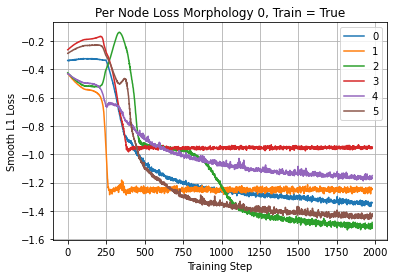

In [50]:
morphIdx = 0
lossArr = torch.stack(testLosses[morphIdx]).T
fig, ax = plt.subplots(1, sharex=True)
for i in range(lossArr.shape[0]):
    ax.plot(range(lossArr.shape[1]), torch.log10(lossArr[i]))
plt.legend(range(lossArr.shape[0]))
plt.xlabel('Training Step')
plt.grid()
plt.ylabel('Smooth L1 Loss')
plt.title('Per Node Loss Morphology {}, Train = {}'.format(morphIdx, morphIdx in trainingIdxs))
plt.savefig('per-node-loss-{}.jpg'.format(morphIdx))
plt.show()

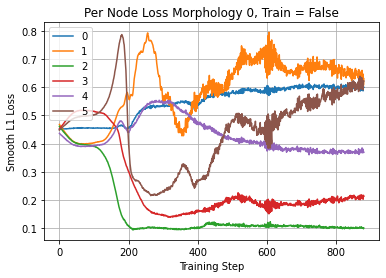

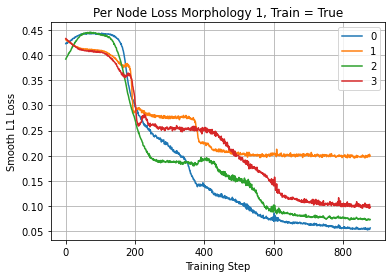

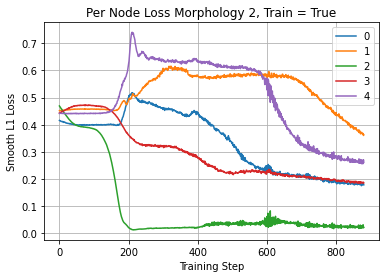

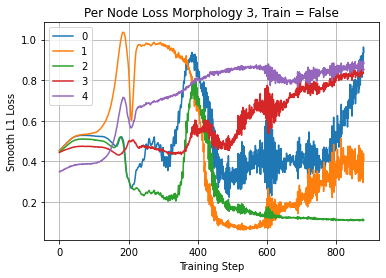

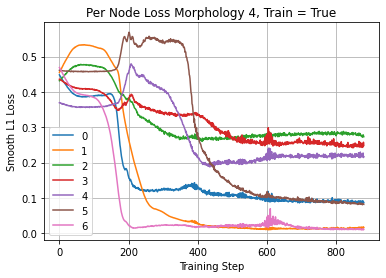

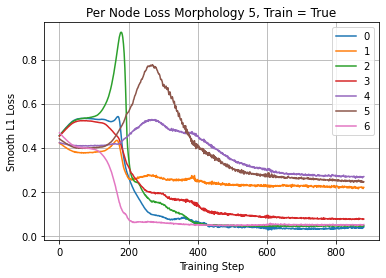

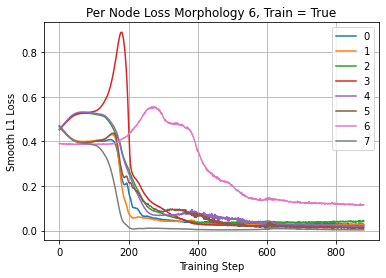

In [58]:
# Cell for producing Per Node Loss for each Morphology

for morphIdx in range(7):
    if morphIdx in trainingIdxs:
        lossArr = torch.stack(testLosses[morphIdx]).T
    else:
        lossArr = torch.stack(validLosses[morphIdx]).T
    
    fig, ax = plt.subplots(1, sharex=True)
    for i in range(lossArr.shape[0]):
        ax.plot(range(lossArr.shape[1]), lossArr[i])
    plt.legend(range(lossArr.shape[0]))
    plt.xlabel('Training Step')
    plt.grid()
    plt.ylabel('Smooth L1 Loss')
    plt.title('Per Node Loss Morphology {}, Train = {}'.format(morphIdx, morphIdx in trainingIdxs))
    plt.savefig('per-node-loss-{}.jpg'.format(morphIdx))
    plt.show()
    

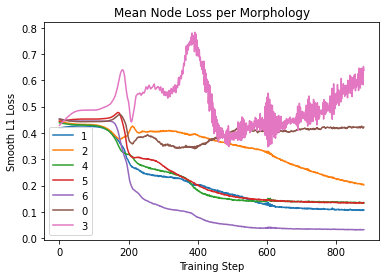

In [59]:
fig, ax = plt.subplots(1, sharex=True)
for morphIdx in trainingIdxs:
    lossArr = torch.stack(testLosses[morphIdx]).mean(dim=1)
    ax.plot(range(lossArr.shape[0]), lossArr)
for morphIdx in validationIdxs:
    lossArr = torch.stack(validLosses[morphIdx]).mean(dim=1)
    ax.plot(range(lossArr.shape[0]), lossArr)

plt.xlabel('Training Step')
plt.ylabel('Smooth L1 Loss')
plt.title('Mean Node Loss per Morphology')
plt.legend(trainingIdxs + validationIdxs)
plt.savefig('mean-node-losses.jpg')
plt.show()

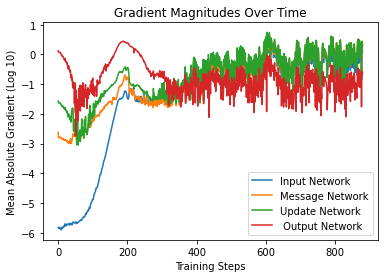

In [60]:
fig, ax = plt.subplots(1, sharex=True)
ax.plot(range(len(inputNetworkGradients)), np.log10(inputNetworkGradients))
ax.plot(range(len(messageNetworkGradients)), np.log10(messageNetworkGradients))
ax.plot(range(len(updateNetworkGradients)), np.log10(updateNetworkGradients))
ax.plot(range(len(outputNetworkGradients)), np.log10(outputNetworkGradients))
plt.xlabel('Training Steps')
plt.ylabel('Mean Absolute Gradient (Log 10)')
plt.title('Gradient Magnitudes Over Time')
plt.legend(['Input Network', 'Message Network', 'Update Network', ' Output Network'])
plt.savefig('gradients.jpg')
plt.show()


************** Batch 0 in 0.45406627655029297 **************

Training Idx 0 
Train Loss tensor([0.4542, 0.4080, 0.4073, 0.5089, 0.3972, 0.4879]) 
Test Loss tensor([0.4553, 0.4058, 0.4062, 0.5118, 0.3943, 0.4892])


************** Batch 4 in 0.4866156578063965 **************

Training Idx 0 
Train Loss tensor([0.4541, 0.4069, 0.4068, 0.5117, 0.3903, 0.4889]) 
Test Loss tensor([0.4553, 0.4052, 0.4053, 0.5127, 0.3929, 0.4908])


************** Batch 8 in 0.5168979167938232 **************

Training Idx 0 
Train Loss tensor([0.4531, 0.4069, 0.4072, 0.5125, 0.3931, 0.4876]) 
Test Loss tensor([0.4551, 0.4034, 0.4038, 0.5139, 0.3937, 0.4915])


************** Batch 12 in 0.565899133682251 **************

Training Idx 0 
Train Loss tensor([0.4551, 0.4047, 0.4047, 0.5160, 0.3939, 0.4916]) 
Test Loss tensor([0.4563, 0.4023, 0.4024, 0.5158, 0.3922, 0.4931])


************** Batch 16 in 0.5349369049072266 **************

Training Idx 0 
Train Loss tensor([0.4538, 0.4025, 0.4026, 0.5151, 0.3916, 0


************** Batch 152 in 0.5560059547424316 **************

Training Idx 0 
Train Loss tensor([0.4648, 0.3584, 0.3621, 0.5627, 0.3607, 0.5286]) 
Test Loss tensor([0.4603, 0.3571, 0.3639, 0.5633, 0.3631, 0.5260])


************** Batch 156 in 0.5513787269592285 **************

Training Idx 0 
Train Loss tensor([0.4610, 0.3566, 0.3615, 0.5625, 0.3629, 0.5291]) 
Test Loss tensor([0.4613, 0.3562, 0.3621, 0.5646, 0.3613, 0.5279])


************** Batch 160 in 0.5360031127929688 **************

Training Idx 0 
Train Loss tensor([0.4613, 0.3562, 0.3617, 0.5626, 0.3600, 0.5319]) 
Test Loss tensor([0.4607, 0.3551, 0.3611, 0.5663, 0.3615, 0.5282])


************** Batch 164 in 0.5378808975219727 **************

Training Idx 0 
Train Loss tensor([0.4584, 0.3553, 0.3648, 0.5640, 0.3598, 0.5264]) 
Test Loss tensor([0.4612, 0.3537, 0.3605, 0.5675, 0.3602, 0.5302])


************** Batch 168 in 0.5488462448120117 **************

Training Idx 0 
Train Loss tensor([0.4599, 0.3537, 0.3595, 0.5667, 0


************** Batch 304 in 0.5307738780975342 **************

Training Idx 0 
Train Loss tensor([0.4722, 0.3235, 0.3318, 0.6048, 0.3419, 0.5607]) 
Test Loss tensor([0.4684, 0.3212, 0.3314, 0.6049, 0.3403, 0.5576])


************** Batch 308 in 0.5523655414581299 **************

Training Idx 0 
Train Loss tensor([0.4645, 0.3213, 0.3314, 0.6063, 0.3349, 0.5557]) 
Test Loss tensor([0.4655, 0.3202, 0.3312, 0.6058, 0.3385, 0.5561])


************** Batch 312 in 0.5363969802856445 **************

Training Idx 0 
Train Loss tensor([0.4634, 0.3221, 0.3302, 0.6043, 0.3402, 0.5538]) 
Test Loss tensor([0.4669, 0.3193, 0.3302, 0.6069, 0.3383, 0.5579])


************** Batch 316 in 0.519451379776001 **************

Training Idx 0 
Train Loss tensor([0.4619, 0.3184, 0.3311, 0.6035, 0.3387, 0.5613]) 
Test Loss tensor([0.4660, 0.3187, 0.3295, 0.6083, 0.3371, 0.5595])


************** Batch 320 in 0.535254955291748 **************

Training Idx 0 
Train Loss tensor([0.4690, 0.3189, 0.3291, 0.6051, 0.3


************** Batch 456 in 0.5431110858917236 **************

Training Idx 0 
Train Loss tensor([0.4735, 0.2966, 0.3103, 0.6328, 0.3259, 0.5812]) 
Test Loss tensor([0.4720, 0.2970, 0.3105, 0.6360, 0.3247, 0.5792])


************** Batch 460 in 0.5542716979980469 **************

Training Idx 0 
Train Loss tensor([0.4728, 0.2964, 0.3128, 0.6349, 0.3234, 0.5767]) 
Test Loss tensor([0.4718, 0.2958, 0.3108, 0.6363, 0.3240, 0.5786])


************** Batch 464 in 0.5381941795349121 **************

Training Idx 0 
Train Loss tensor([0.4737, 0.2971, 0.3127, 0.6338, 0.3237, 0.5800]) 
Test Loss tensor([0.4718, 0.2951, 0.3102, 0.6362, 0.3242, 0.5802])


************** Batch 468 in 0.5481476783752441 **************

Training Idx 0 
Train Loss tensor([0.4687, 0.2953, 0.3124, 0.6360, 0.3236, 0.5770]) 
Test Loss tensor([0.4715, 0.2953, 0.3100, 0.6381, 0.3236, 0.5788])


************** Batch 472 in 0.543813943862915 **************

Training Idx 0 
Train Loss tensor([0.4715, 0.2956, 0.3079, 0.6391, 0.


************** Batch 608 in 0.5291624069213867 **************

Training Idx 0 
Train Loss tensor([0.4808, 0.2858, 0.3030, 0.6466, 0.3147, 0.5916]) 
Test Loss tensor([0.4713, 0.2843, 0.3025, 0.6499, 0.3165, 0.5867])


************** Batch 612 in 0.535383939743042 **************

Training Idx 0 
Train Loss tensor([0.4644, 0.2848, 0.3026, 0.6458, 0.3203, 0.5847]) 
Test Loss tensor([0.4728, 0.2849, 0.3029, 0.6501, 0.3186, 0.5881])


************** Batch 616 in 0.5333395004272461 **************

Training Idx 0 
Train Loss tensor([0.4737, 0.2861, 0.3017, 0.6502, 0.3172, 0.5905]) 
Test Loss tensor([0.4739, 0.2849, 0.3036, 0.6502, 0.3160, 0.5873])


************** Batch 620 in 0.5429649353027344 **************

Training Idx 0 
Train Loss tensor([0.4765, 0.2840, 0.3032, 0.6483, 0.3158, 0.5868]) 
Test Loss tensor([0.4749, 0.2842, 0.3025, 0.6517, 0.3165, 0.5875])


************** Batch 624 in 0.5283288955688477 **************

Training Idx 0 
Train Loss tensor([0.4706, 0.2832, 0.3042, 0.6484, 0.


************** Batch 760 in 0.5348443984985352 **************

Training Idx 0 
Train Loss tensor([0.4768, 0.2728, 0.2961, 0.6692, 0.3082, 0.5919]) 
Test Loss tensor([0.4712, 0.2740, 0.2991, 0.6645, 0.3088, 0.5914])


************** Batch 764 in 0.538771390914917 **************

Training Idx 0 
Train Loss tensor([0.4663, 0.2741, 0.2996, 0.6642, 0.3023, 0.5924]) 
Test Loss tensor([0.4701, 0.2728, 0.2998, 0.6663, 0.3076, 0.5902])


************** Batch 768 in 0.538947582244873 **************

Training Idx 0 
Train Loss tensor([0.4712, 0.2714, 0.2968, 0.6625, 0.3078, 0.5921]) 
Test Loss tensor([0.4715, 0.2724, 0.2985, 0.6667, 0.3080, 0.5917])


************** Batch 772 in 0.5261785984039307 **************

Training Idx 0 
Train Loss tensor([0.4783, 0.2713, 0.2974, 0.6642, 0.3107, 0.5965]) 
Test Loss tensor([0.4711, 0.2725, 0.2990, 0.6660, 0.3084, 0.5912])


************** Batch 776 in 0.5457241535186768 **************

Training Idx 0 
Train Loss tensor([0.4749, 0.2729, 0.3024, 0.6687, 0.3


************** Batch 32 in 0.5296206474304199 **************

Training Idx 0 
Train Loss tensor([0.4658, 0.2456, 0.3056, 0.6917, 0.2798, 0.5893]) 
Test Loss tensor([0.4639, 0.2422, 0.3047, 0.6952, 0.2816, 0.5845])


************** Batch 36 in 0.554046630859375 **************

Training Idx 0 
Train Loss tensor([0.4647, 0.2424, 0.3039, 0.6952, 0.2805, 0.5878]) 
Test Loss tensor([0.4646, 0.2422, 0.3055, 0.6957, 0.2808, 0.5828])


************** Batch 40 in 0.5377156734466553 **************

Training Idx 0 
Train Loss tensor([0.4632, 0.2413, 0.3037, 0.6954, 0.2799, 0.5822]) 
Test Loss tensor([0.4647, 0.2389, 0.3065, 0.6953, 0.2799, 0.5819])


************** Batch 44 in 0.5578279495239258 **************

Training Idx 0 
Train Loss tensor([0.4598, 0.2408, 0.3089, 0.6982, 0.2891, 0.5831]) 
Test Loss tensor([0.4645, 0.2377, 0.3082, 0.6958, 0.2781, 0.5799])


************** Batch 48 in 0.5402917861938477 **************

Training Idx 0 
Train Loss tensor([0.4631, 0.2404, 0.3081, 0.6953, 0.2793,


************** Batch 184 in 0.5474205017089844 **************

Training Idx 0 
Train Loss tensor([0.4550, 0.0717, 0.4095, 0.5107, 0.2236, 0.4855]) 
Test Loss tensor([0.4541, 0.0752, 0.4137, 0.5070, 0.2182, 0.4834])


************** Batch 188 in 0.5286734104156494 **************

Training Idx 0 
Train Loss tensor([0.4451, 0.0777, 0.4147, 0.5056, 0.2163, 0.4817]) 
Test Loss tensor([0.4491, 0.0737, 0.4166, 0.5028, 0.2171, 0.4814])


************** Batch 192 in 0.5516188144683838 **************

Training Idx 0 
Train Loss tensor([0.4504, 0.0789, 0.4164, 0.5052, 0.2211, 0.4848]) 
Test Loss tensor([0.4490, 0.0712, 0.4182, 0.4994, 0.2155, 0.4787])


************** Batch 196 in 0.5434615612030029 **************

Training Idx 0 
Train Loss tensor([0.4511, 0.0672, 0.4198, 0.4996, 0.2066, 0.4794]) 
Test Loss tensor([0.4457, 0.0702, 0.4218, 0.4969, 0.2204, 0.4763])


************** Batch 200 in 0.5419492721557617 **************

Training Idx 0 
Train Loss tensor([0.4435, 0.0741, 0.4226, 0.4964, 0


************** Batch 336 in 0.5496346950531006 **************

Training Idx 0 
Train Loss tensor([0.3465, 0.0545, 0.5040, 0.4146, 0.2161, 0.4217]) 
Test Loss tensor([0.3384, 0.0567, 0.5054, 0.4120, 0.2126, 0.4189])


************** Batch 340 in 0.5305476188659668 **************

Training Idx 0 
Train Loss tensor([0.3392, 0.0597, 0.5036, 0.4122, 0.2044, 0.4196]) 
Test Loss tensor([0.3393, 0.0595, 0.5090, 0.4096, 0.2182, 0.4176])


************** Batch 344 in 0.5415654182434082 **************

Training Idx 0 
Train Loss tensor([0.3409, 0.0579, 0.5088, 0.4084, 0.2115, 0.4159]) 
Test Loss tensor([0.3334, 0.0567, 0.5109, 0.4073, 0.2156, 0.4162])


************** Batch 348 in 0.5341329574584961 **************

Training Idx 0 
Train Loss tensor([0.3358, 0.0542, 0.5094, 0.4079, 0.2161, 0.4185]) 
Test Loss tensor([0.3341, 0.0568, 0.5134, 0.4052, 0.2171, 0.4145])


************** Batch 352 in 0.5488667488098145 **************

Training Idx 0 
Train Loss tensor([0.3389, 0.0605, 0.5131, 0.4049, 0


************** Batch 488 in 0.5324983596801758 **************

Training Idx 0 
Train Loss tensor([0.2823, 0.0308, 0.5931, 0.3385, 0.1875, 0.3725]) 
Test Loss tensor([0.2785, 0.0344, 0.5963, 0.3336, 0.1947, 0.3706])


************** Batch 492 in 0.5389766693115234 **************

Training Idx 0 
Train Loss tensor([0.2843, 0.0385, 0.5912, 0.3353, 0.1955, 0.3722]) 
Test Loss tensor([0.2774, 0.0343, 0.5975, 0.3327, 0.1939, 0.3701])


************** Batch 496 in 0.5296876430511475 **************

Training Idx 0 
Train Loss tensor([0.2842, 0.0337, 0.5989, 0.3308, 0.1892, 0.3700]) 
Test Loss tensor([0.2755, 0.0331, 0.6001, 0.3304, 0.1925, 0.3697])


************** Batch 500 in 0.5414493083953857 **************

Training Idx 0 
Train Loss tensor([0.2800, 0.0301, 0.5977, 0.3291, 0.1926, 0.3669]) 
Test Loss tensor([0.2758, 0.0343, 0.6015, 0.3284, 0.1927, 0.3677])


************** Batch 504 in 0.5322480201721191 **************

Training Idx 0 
Train Loss tensor([0.2706, 0.0307, 0.6004, 0.3288, 0


************** Batch 640 in 0.5485544204711914 **************

Training Idx 0 
Train Loss tensor([0.2308, 0.0299, 0.6522, 0.2760, 0.1764, 0.3431]) 
Test Loss tensor([0.2329, 0.0289, 0.6536, 0.2755, 0.1756, 0.3395])


************** Batch 644 in 0.5494263172149658 **************

Training Idx 0 
Train Loss tensor([0.2350, 0.0261, 0.6540, 0.2745, 0.1730, 0.3407]) 
Test Loss tensor([0.2304, 0.0274, 0.6542, 0.2739, 0.1761, 0.3388])


************** Batch 648 in 0.542665958404541 **************

Training Idx 0 
Train Loss tensor([0.2273, 0.0268, 0.6522, 0.2784, 0.1827, 0.3383]) 
Test Loss tensor([0.2284, 0.0283, 0.6540, 0.2754, 0.1726, 0.3414])


************** Batch 652 in 0.5348613262176514 **************

Training Idx 0 
Train Loss tensor([0.2207, 0.0255, 0.6499, 0.2726, 0.1677, 0.3441]) 
Test Loss tensor([0.2277, 0.0286, 0.6559, 0.2737, 0.1753, 0.3382])


************** Batch 656 in 0.5376636981964111 **************

Training Idx 0 
Train Loss tensor([0.2277, 0.0300, 0.6541, 0.2741, 0.


************** Batch 792 in 0.5258066654205322 **************

Training Idx 0 
Train Loss tensor([0.1869, 0.0258, 0.6401, 0.2307, 0.1648, 0.3221]) 
Test Loss tensor([0.1825, 0.0274, 0.6392, 0.2285, 0.1642, 0.3208])


************** Batch 796 in 0.5531620979309082 **************

Training Idx 0 
Train Loss tensor([0.1794, 0.0305, 0.6373, 0.2270, 0.1745, 0.3261]) 
Test Loss tensor([0.1822, 0.0281, 0.6384, 0.2259, 0.1680, 0.3193])


************** Batch 800 in 0.5309033393859863 **************

Training Idx 0 
Train Loss tensor([0.1869, 0.0273, 0.6413, 0.2235, 0.1578, 0.3158]) 
Test Loss tensor([0.1809, 0.0277, 0.6342, 0.2248, 0.1681, 0.3178])


************** Batch 804 in 0.551349401473999 **************

Training Idx 0 
Train Loss tensor([0.1812, 0.0274, 0.6356, 0.2262, 0.1632, 0.3180]) 
Test Loss tensor([0.1799, 0.0278, 0.6297, 0.2230, 0.1667, 0.3169])


************** Batch 808 in 0.5349478721618652 **************

Training Idx 0 
Train Loss tensor([0.1749, 0.0277, 0.6324, 0.2208, 0.


************** Batch 64 in 0.5434319972991943 **************

Training Idx 0 
Train Loss tensor([0.1616, 0.0361, 0.2093, 0.1333, 0.1659, 0.1990]) 
Test Loss tensor([0.1587, 0.0365, 0.1967, 0.1328, 0.1599, 0.2034])


************** Batch 68 in 0.5323295593261719 **************

Training Idx 0 
Train Loss tensor([0.1626, 0.0375, 0.1996, 0.1423, 0.1633, 0.2079]) 
Test Loss tensor([0.1550, 0.0346, 0.1960, 0.1251, 0.1674, 0.1867])


************** Batch 72 in 0.5457367897033691 **************

Training Idx 0 
Train Loss tensor([0.1545, 0.0424, 0.1969, 0.1323, 0.1703, 0.1777]) 
Test Loss tensor([0.1577, 0.0356, 0.1930, 0.1246, 0.1726, 0.1809])


************** Batch 76 in 0.5403342247009277 **************

Training Idx 0 
Train Loss tensor([0.1513, 0.0388, 0.2013, 0.1240, 0.1641, 0.1835]) 
Test Loss tensor([0.1569, 0.0377, 0.1850, 0.1267, 0.1625, 0.1820])


************** Batch 80 in 0.5394365787506104 **************

Training Idx 0 
Train Loss tensor([0.1611, 0.0347, 0.1882, 0.1228, 0.1588


************** Batch 216 in 0.5406193733215332 **************

Training Idx 0 
Train Loss tensor([0.1330, 0.0352, 0.1603, 0.0949, 0.1465, 0.1233]) 
Test Loss tensor([0.1287, 0.0336, 0.1669, 0.0946, 0.1440, 0.1246])


************** Batch 220 in 0.5381455421447754 **************

Training Idx 0 
Train Loss tensor([0.1322, 0.0302, 0.1657, 0.1085, 0.1490, 0.1200]) 
Test Loss tensor([0.1320, 0.0328, 0.1640, 0.0937, 0.1455, 0.1207])


************** Batch 224 in 0.5489740371704102 **************

Training Idx 0 
Train Loss tensor([0.1263, 0.0344, 0.1644, 0.1026, 0.1464, 0.1155]) 
Test Loss tensor([0.1367, 0.0328, 0.1704, 0.0935, 0.1465, 0.1224])


************** Batch 228 in 0.5288910865783691 **************

Training Idx 0 
Train Loss tensor([0.1343, 0.0301, 0.1668, 0.0927, 0.1463, 0.1228]) 
Test Loss tensor([0.1281, 0.0334, 0.1642, 0.0933, 0.1423, 0.1205])


************** Batch 232 in 0.5385756492614746 **************

Training Idx 0 
Train Loss tensor([0.1260, 0.0346, 0.1699, 0.0978, 0


************** Batch 368 in 0.5447835922241211 **************

Training Idx 0 
Train Loss tensor([0.1195, 0.0248, 0.1604, 0.0994, 0.1274, 0.1094]) 
Test Loss tensor([0.1267, 0.0309, 0.1688, 0.0932, 0.1396, 0.1052])


************** Batch 372 in 0.5487470626831055 **************

Training Idx 0 
Train Loss tensor([0.1175, 0.0307, 0.1645, 0.0947, 0.1333, 0.1083]) 
Test Loss tensor([0.1210, 0.0314, 0.1664, 0.0937, 0.1280, 0.1072])


************** Batch 376 in 0.5345792770385742 **************

Training Idx 0 
Train Loss tensor([0.1179, 0.0275, 0.1562, 0.0975, 0.1247, 0.1116]) 
Test Loss tensor([0.1212, 0.0304, 0.1636, 0.0949, 0.1309, 0.1078])


************** Batch 380 in 0.5458524227142334 **************

Training Idx 0 
Train Loss tensor([0.1227, 0.0322, 0.1602, 0.0855, 0.1403, 0.1060]) 
Test Loss tensor([0.1240, 0.0305, 0.1689, 0.0952, 0.1276, 0.1052])


************** Batch 384 in 0.535860538482666 **************

Training Idx 0 
Train Loss tensor([0.1303, 0.0314, 0.1714, 0.0908, 0.


************** Batch 520 in 0.5479378700256348 **************

Training Idx 0 
Train Loss tensor([0.1233, 0.0391, 0.1675, 0.0985, 0.1197, 0.0916]) 
Test Loss tensor([0.1169, 0.0311, 0.1624, 0.0939, 0.1162, 0.0948])


************** Batch 524 in 0.5471928119659424 **************

Training Idx 0 
Train Loss tensor([0.1232, 0.0337, 0.1687, 0.0882, 0.1148, 0.0971]) 
Test Loss tensor([0.1176, 0.0312, 0.1635, 0.0929, 0.1174, 0.0938])


************** Batch 528 in 0.5457730293273926 **************

Training Idx 0 
Train Loss tensor([0.1095, 0.0323, 0.1633, 0.0948, 0.1128, 0.1003]) 
Test Loss tensor([0.1177, 0.0311, 0.1614, 0.0912, 0.1152, 0.0930])


************** Batch 532 in 0.5955703258514404 **************

Training Idx 0 
Train Loss tensor([0.1112, 0.0281, 0.1690, 0.0853, 0.1070, 0.1025]) 
Test Loss tensor([0.1127, 0.0298, 0.1626, 0.0912, 0.1142, 0.0946])


************** Batch 536 in 0.5432875156402588 **************

Training Idx 0 
Train Loss tensor([0.1305, 0.0386, 0.1606, 0.0956, 0


************** Batch 672 in 0.5520679950714111 **************

Training Idx 0 
Train Loss tensor([0.1160, 0.0301, 0.1643, 0.0862, 0.1048, 0.0906]) 
Test Loss tensor([0.1146, 0.0306, 0.1597, 0.0904, 0.1114, 0.0869])


************** Batch 676 in 0.5476300716400146 **************

Training Idx 0 
Train Loss tensor([0.1124, 0.0299, 0.1640, 0.0917, 0.1009, 0.0870]) 
Test Loss tensor([0.1170, 0.0313, 0.1618, 0.0930, 0.1099, 0.0861])


************** Batch 680 in 0.5571057796478271 **************

Training Idx 0 
Train Loss tensor([0.1179, 0.0336, 0.1547, 0.0862, 0.1112, 0.0922]) 
Test Loss tensor([0.1133, 0.0303, 0.1583, 0.0882, 0.1049, 0.0866])


************** Batch 684 in 0.5437507629394531 **************

Training Idx 0 
Train Loss tensor([0.1142, 0.0297, 0.1507, 0.0871, 0.1042, 0.0930]) 
Test Loss tensor([0.1143, 0.0291, 0.1621, 0.0905, 0.1082, 0.0872])


************** Batch 688 in 0.5700051784515381 **************

Training Idx 0 
Train Loss tensor([0.1191, 0.0352, 0.1689, 0.0915, 0


************** Batch 824 in 0.5467476844787598 **************

Training Idx 0 
Train Loss tensor([0.1113, 0.0367, 0.1580, 0.0947, 0.1053, 0.0828]) 
Test Loss tensor([0.1112, 0.0318, 0.1573, 0.0896, 0.1005, 0.0807])


************** Batch 828 in 0.5381989479064941 **************

Training Idx 0 
Train Loss tensor([0.1049, 0.0317, 0.1522, 0.0864, 0.1004, 0.0830]) 
Test Loss tensor([0.1121, 0.0315, 0.1606, 0.0906, 0.0989, 0.0818])


************** Batch 832 in 0.5499377250671387 **************

Training Idx 0 
Train Loss tensor([0.1070, 0.0252, 0.1592, 0.0873, 0.0947, 0.0853]) 
Test Loss tensor([0.1135, 0.0343, 0.1568, 0.0890, 0.1036, 0.0832])


************** Batch 836 in 0.5429871082305908 **************

Training Idx 0 
Train Loss tensor([0.1282, 0.0330, 0.1501, 0.0912, 0.0939, 0.0760]) 
Test Loss tensor([0.1086, 0.0316, 0.1533, 0.0859, 0.0993, 0.0812])


************** Batch 840 in 0.5515596866607666 **************

Training Idx 0 
Train Loss tensor([0.1081, 0.0317, 0.1515, 0.0853, 0


************** Batch 96 in 0.5381529331207275 **************

Training Idx 0 
Train Loss tensor([0.1007, 0.0303, 0.1482, 0.0925, 0.0938, 0.0759]) 
Test Loss tensor([0.1104, 0.0319, 0.1529, 0.0878, 0.0966, 0.0756])


************** Batch 100 in 0.5588855743408203 **************

Training Idx 0 
Train Loss tensor([0.1079, 0.0271, 0.1599, 0.0888, 0.0908, 0.0735]) 
Test Loss tensor([0.1081, 0.0328, 0.1505, 0.0844, 0.0942, 0.0758])


************** Batch 104 in 0.5497269630432129 **************

Training Idx 0 
Train Loss tensor([0.1098, 0.0347, 0.1633, 0.0865, 0.0971, 0.0753]) 
Test Loss tensor([0.1093, 0.0351, 0.1530, 0.0865, 0.0977, 0.0754])


************** Batch 108 in 0.5508370399475098 **************

Training Idx 0 
Train Loss tensor([0.1089, 0.0328, 0.1452, 0.0718, 0.0984, 0.0716]) 
Test Loss tensor([0.1077, 0.0340, 0.1540, 0.0866, 0.0928, 0.0776])


************** Batch 112 in 0.5534296035766602 **************

Training Idx 0 
Train Loss tensor([0.1175, 0.0393, 0.1647, 0.0886, 0.


************** Batch 248 in 0.543848991394043 **************

Training Idx 0 
Train Loss tensor([0.1035, 0.0419, 0.1493, 0.0880, 0.0943, 0.0748]) 
Test Loss tensor([0.1032, 0.0358, 0.1489, 0.0864, 0.0911, 0.0718])


************** Batch 252 in 0.5525448322296143 **************

Training Idx 0 
Train Loss tensor([0.1024, 0.0325, 0.1432, 0.0832, 0.0916, 0.0731]) 
Test Loss tensor([0.1074, 0.0357, 0.1481, 0.0843, 0.0917, 0.0720])


************** Batch 256 in 0.532970666885376 **************

Training Idx 0 
Train Loss tensor([0.1065, 0.0373, 0.1515, 0.0853, 0.0922, 0.0694]) 
Test Loss tensor([0.1066, 0.0356, 0.1464, 0.0846, 0.0897, 0.0713])


************** Batch 260 in 0.5534389019012451 **************

Training Idx 0 
Train Loss tensor([0.1056, 0.0296, 0.1506, 0.0849, 0.0833, 0.0703]) 
Test Loss tensor([0.1061, 0.0360, 0.1470, 0.0834, 0.0911, 0.0737])


************** Batch 264 in 0.5603148937225342 **************

Training Idx 0 
Train Loss tensor([0.1048, 0.0367, 0.1454, 0.0924, 0.0


************** Batch 400 in 0.5790297985076904 **************

Training Idx 0 
Train Loss tensor([0.1028, 0.0371, 0.1428, 0.0819, 0.0890, 0.0738]) 
Test Loss tensor([0.1046, 0.0367, 0.1441, 0.0821, 0.0867, 0.0692])


************** Batch 404 in 0.5677106380462646 **************

Training Idx 0 
Train Loss tensor([0.1024, 0.0345, 0.1419, 0.0888, 0.0872, 0.0671]) 
Test Loss tensor([0.1045, 0.0374, 0.1458, 0.0830, 0.0873, 0.0692])


************** Batch 408 in 0.5428388118743896 **************

Training Idx 0 
Train Loss tensor([0.0971, 0.0395, 0.1495, 0.0763, 0.0867, 0.0698]) 
Test Loss tensor([0.1046, 0.0391, 0.1444, 0.0824, 0.0893, 0.0704])


************** Batch 412 in 0.5786697864532471 **************

Training Idx 0 
Train Loss tensor([0.0983, 0.0393, 0.1442, 0.0871, 0.0864, 0.0640]) 
Test Loss tensor([0.1016, 0.0362, 0.1444, 0.0804, 0.0886, 0.0687])


************** Batch 416 in 0.5399830341339111 **************

Training Idx 0 
Train Loss tensor([0.0971, 0.0428, 0.1536, 0.0828, 0


************** Batch 552 in 0.5435571670532227 **************

Training Idx 0 
Train Loss tensor([0.1077, 0.0407, 0.1507, 0.0797, 0.0856, 0.0713]) 
Test Loss tensor([0.1020, 0.0385, 0.1391, 0.0827, 0.0881, 0.0669])


************** Batch 556 in 0.5624282360076904 **************

Training Idx 0 
Train Loss tensor([0.1014, 0.0385, 0.1340, 0.0809, 0.0910, 0.0659]) 
Test Loss tensor([0.0986, 0.0378, 0.1399, 0.0794, 0.0851, 0.0676])


************** Batch 560 in 0.564854621887207 **************

Training Idx 0 
Train Loss tensor([0.1016, 0.0362, 0.1428, 0.0826, 0.0845, 0.0622]) 
Test Loss tensor([0.1009, 0.0395, 0.1403, 0.0811, 0.0874, 0.0669])


************** Batch 564 in 0.5532312393188477 **************

Training Idx 0 
Train Loss tensor([0.1043, 0.0408, 0.1444, 0.0816, 0.0924, 0.0646]) 
Test Loss tensor([0.1013, 0.0383, 0.1367, 0.0766, 0.0867, 0.0666])


************** Batch 568 in 0.5657095909118652 **************

Training Idx 0 
Train Loss tensor([0.1001, 0.0354, 0.1383, 0.0862, 0.


************** Batch 704 in 0.5710694789886475 **************

Training Idx 0 
Train Loss tensor([0.1025, 0.0386, 0.1380, 0.0825, 0.0918, 0.0683]) 
Test Loss tensor([0.0987, 0.0420, 0.1310, 0.0784, 0.0857, 0.0645])


************** Batch 708 in 0.5640325546264648 **************

Training Idx 0 
Train Loss tensor([0.0939, 0.0396, 0.1380, 0.0799, 0.0834, 0.0638]) 
Test Loss tensor([0.1001, 0.0429, 0.1296, 0.0771, 0.0861, 0.0669])


************** Batch 712 in 0.570669412612915 **************

Training Idx 0 
Train Loss tensor([0.0993, 0.0440, 0.1260, 0.0741, 0.0815, 0.0689]) 
Test Loss tensor([0.0959, 0.0407, 0.1283, 0.0756, 0.0857, 0.0639])


************** Batch 716 in 0.5609221458435059 **************

Training Idx 0 
Train Loss tensor([0.1041, 0.0426, 0.1249, 0.0787, 0.0846, 0.0631]) 
Test Loss tensor([0.0977, 0.0414, 0.1263, 0.0756, 0.0876, 0.0634])


************** Batch 720 in 0.5668466091156006 **************

Training Idx 0 
Train Loss tensor([0.0980, 0.0420, 0.1235, 0.0771, 0.


************** Batch 856 in 0.5696451663970947 **************

Training Idx 0 
Train Loss tensor([0.0991, 0.0445, 0.1204, 0.0707, 0.0858, 0.0583]) 
Test Loss tensor([0.0993, 0.0423, 0.1245, 0.0759, 0.0857, 0.0624])


************** Batch 860 in 0.7329177856445312 **************

Training Idx 0 
Train Loss tensor([0.0985, 0.0392, 0.1286, 0.0729, 0.0813, 0.0607]) 
Test Loss tensor([0.1015, 0.0410, 0.1248, 0.0726, 0.0883, 0.0645])


************** Batch 864 in 0.5893726348876953 **************

Training Idx 0 
Train Loss tensor([0.1025, 0.0431, 0.1148, 0.0774, 0.0860, 0.0614]) 
Test Loss tensor([0.0990, 0.0424, 0.1258, 0.0744, 0.0853, 0.0619])


************** Batch 868 in 0.5485644340515137 **************

Training Idx 0 
Train Loss tensor([0.0993, 0.0441, 0.1266, 0.0659, 0.0844, 0.0650]) 
Test Loss tensor([0.1013, 0.0407, 0.1240, 0.0746, 0.0862, 0.0623])


************** Batch 872 in 0.5763258934020996 **************

Training Idx 0 
Train Loss tensor([0.1023, 0.0497, 0.1298, 0.0761, 0


************** Batch 128 in 0.6275901794433594 **************

Training Idx 0 
Train Loss tensor([0.1003, 0.0373, 0.1213, 0.0721, 0.0880, 0.0616]) 
Test Loss tensor([0.0958, 0.0361, 0.1251, 0.0724, 0.0836, 0.0586])


************** Batch 132 in 0.6233611106872559 **************

Training Idx 0 
Train Loss tensor([0.0979, 0.0401, 0.1158, 0.0686, 0.0852, 0.0574]) 
Test Loss tensor([0.0967, 0.0349, 0.1237, 0.0755, 0.0846, 0.0585])


************** Batch 136 in 0.6453649997711182 **************

Training Idx 0 
Train Loss tensor([0.0951, 0.0314, 0.1262, 0.0708, 0.0844, 0.0573]) 
Test Loss tensor([0.0970, 0.0361, 0.1229, 0.0744, 0.0849, 0.0578])


************** Batch 140 in 0.6548182964324951 **************

Training Idx 0 
Train Loss tensor([0.1067, 0.0380, 0.1135, 0.0769, 0.0859, 0.0608]) 
Test Loss tensor([0.0962, 0.0348, 0.1230, 0.0715, 0.0838, 0.0573])


************** Batch 144 in 0.638319730758667 **************

Training Idx 0 
Train Loss tensor([0.1047, 0.0385, 0.1240, 0.0810, 0.


************** Batch 280 in 0.6001169681549072 **************

Training Idx 0 
Train Loss tensor([0.0985, 0.0309, 0.1285, 0.0705, 0.0871, 0.0597]) 
Test Loss tensor([0.0974, 0.0302, 0.1208, 0.0712, 0.0821, 0.0562])


************** Batch 284 in 0.5791747570037842 **************

Training Idx 0 
Train Loss tensor([0.0971, 0.0298, 0.1190, 0.0825, 0.0817, 0.0556]) 
Test Loss tensor([0.0956, 0.0301, 0.1223, 0.0711, 0.0819, 0.0557])


************** Batch 288 in 0.562849760055542 **************

Training Idx 0 
Train Loss tensor([0.0955, 0.0361, 0.1225, 0.0731, 0.0826, 0.0549]) 
Test Loss tensor([0.0970, 0.0325, 0.1209, 0.0733, 0.0833, 0.0549])


************** Batch 292 in 0.5603587627410889 **************

Training Idx 0 
Train Loss tensor([0.0936, 0.0294, 0.1253, 0.0704, 0.0818, 0.0597]) 
Test Loss tensor([0.0983, 0.0315, 0.1218, 0.0722, 0.0832, 0.0575])


************** Batch 296 in 0.542853832244873 **************

Training Idx 0 
Train Loss tensor([0.0945, 0.0302, 0.1264, 0.0735, 0.0


************** Batch 432 in 0.6091485023498535 **************

Training Idx 0 
Train Loss tensor([0.0977, 0.0234, 0.1169, 0.0834, 0.0883, 0.0544]) 
Test Loss tensor([0.0946, 0.0275, 0.1189, 0.0724, 0.0856, 0.0541])


************** Batch 436 in 0.6480510234832764 **************

Training Idx 0 
Train Loss tensor([0.0881, 0.0242, 0.1259, 0.0742, 0.0817, 0.0549]) 
Test Loss tensor([0.0972, 0.0257, 0.1201, 0.0726, 0.0832, 0.0519])


************** Batch 440 in 0.6481490135192871 **************

Training Idx 0 
Train Loss tensor([0.1004, 0.0246, 0.1218, 0.0735, 0.0862, 0.0581]) 
Test Loss tensor([0.0990, 0.0252, 0.1219, 0.0727, 0.0884, 0.0537])


************** Batch 444 in 0.6757040023803711 **************

Training Idx 0 
Train Loss tensor([0.1097, 0.0304, 0.1144, 0.0760, 0.0891, 0.0502]) 
Test Loss tensor([0.0960, 0.0248, 0.1217, 0.0725, 0.0821, 0.0514])


************** Batch 448 in 0.630720853805542 **************

Training Idx 0 
Train Loss tensor([0.0993, 0.0282, 0.1205, 0.0671, 0.


************** Batch 584 in 0.6078188419342041 **************

Training Idx 0 
Train Loss tensor([0.0920, 0.0284, 0.1295, 0.0803, 0.0770, 0.0507]) 
Test Loss tensor([0.0998, 0.0242, 0.1191, 0.0754, 0.0804, 0.0478])


************** Batch 588 in 0.639585018157959 **************

Training Idx 0 
Train Loss tensor([0.0986, 0.0275, 0.1250, 0.0762, 0.0736, 0.0475]) 
Test Loss tensor([0.0946, 0.0251, 0.1204, 0.0720, 0.0808, 0.0502])


************** Batch 592 in 0.6741902828216553 **************

Training Idx 0 
Train Loss tensor([0.1041, 0.0285, 0.1220, 0.0768, 0.0836, 0.0488]) 
Test Loss tensor([0.0960, 0.0248, 0.1175, 0.0709, 0.0786, 0.0489])


************** Batch 596 in 0.6004574298858643 **************

Training Idx 0 
Train Loss tensor([0.0994, 0.0250, 0.1245, 0.0828, 0.0809, 0.0508]) 
Test Loss tensor([0.0953, 0.0228, 0.1200, 0.0712, 0.0803, 0.0492])


************** Batch 600 in 0.692044734954834 **************

Training Idx 0 
Train Loss tensor([0.1014, 0.0220, 0.1180, 0.0753, 0.0


************** Batch 736 in 0.6038153171539307 **************

Training Idx 0 
Train Loss tensor([0.1053, 0.0228, 0.1183, 0.0735, 0.0822, 0.0466]) 
Test Loss tensor([0.0958, 0.0233, 0.1192, 0.0697, 0.0788, 0.0477])


************** Batch 740 in 0.605947732925415 **************

Training Idx 0 
Train Loss tensor([0.0924, 0.0265, 0.1234, 0.0687, 0.0793, 0.0459]) 
Test Loss tensor([0.0973, 0.0219, 0.1197, 0.0700, 0.0816, 0.0485])


************** Batch 744 in 0.6679079532623291 **************

Training Idx 0 
Train Loss tensor([0.0951, 0.0221, 0.1108, 0.0662, 0.0810, 0.0459]) 
Test Loss tensor([0.0966, 0.0238, 0.1190, 0.0728, 0.0817, 0.0486])


************** Batch 748 in 0.6412575244903564 **************

Training Idx 0 
Train Loss tensor([0.0973, 0.0244, 0.1190, 0.0684, 0.0818, 0.0476]) 
Test Loss tensor([0.0970, 0.0235, 0.1199, 0.0735, 0.0811, 0.0474])


************** Batch 752 in 0.624464750289917 **************

Training Idx 0 
Train Loss tensor([0.0963, 0.0236, 0.1110, 0.0776, 0.0


************** Batch 8 in 0.5798180103302002 **************

Training Idx 0 
Train Loss tensor([0.0915, 0.0201, 0.1230, 0.0711, 0.0756, 0.0477]) 
Test Loss tensor([0.0970, 0.0222, 0.1162, 0.0694, 0.0770, 0.0471])


************** Batch 12 in 0.5661907196044922 **************

Training Idx 0 
Train Loss tensor([0.0979, 0.0235, 0.1204, 0.0708, 0.0737, 0.0447]) 
Test Loss tensor([0.0948, 0.0222, 0.1136, 0.0709, 0.0763, 0.0453])


************** Batch 16 in 0.5657241344451904 **************

Training Idx 0 
Train Loss tensor([0.0935, 0.0214, 0.1258, 0.0689, 0.0740, 0.0499]) 
Test Loss tensor([0.0971, 0.0240, 0.1164, 0.0710, 0.0784, 0.0461])


************** Batch 20 in 0.5662422180175781 **************

Training Idx 0 
Train Loss tensor([0.0979, 0.0248, 0.1155, 0.0755, 0.0792, 0.0449]) 
Test Loss tensor([0.0945, 0.0223, 0.1165, 0.0692, 0.0773, 0.0468])


************** Batch 24 in 0.5894591808319092 **************

Training Idx 0 
Train Loss tensor([0.0903, 0.0214, 0.1076, 0.0764, 0.0740,


************** Batch 160 in 0.6170213222503662 **************

Training Idx 0 
Train Loss tensor([0.1020, 0.0190, 0.1111, 0.0730, 0.0745, 0.0413]) 
Test Loss tensor([0.0963, 0.0217, 0.1167, 0.0679, 0.0772, 0.0476])


************** Batch 164 in 0.5985832214355469 **************

Training Idx 0 
Train Loss tensor([0.0961, 0.0257, 0.1242, 0.0756, 0.0781, 0.0436]) 
Test Loss tensor([0.0939, 0.0214, 0.1147, 0.0697, 0.0763, 0.0458])


************** Batch 168 in 0.6251144409179688 **************

Training Idx 0 
Train Loss tensor([0.0968, 0.0252, 0.1190, 0.0680, 0.0807, 0.0441]) 
Test Loss tensor([0.0964, 0.0226, 0.1137, 0.0699, 0.0817, 0.0480])


************** Batch 172 in 0.6123957633972168 **************

Training Idx 0 
Train Loss tensor([0.0939, 0.0272, 0.1263, 0.0676, 0.0835, 0.0495]) 
Test Loss tensor([0.0961, 0.0215, 0.1164, 0.0705, 0.0789, 0.0452])


************** Batch 176 in 0.5746612548828125 **************

Training Idx 0 
Train Loss tensor([0.0919, 0.0227, 0.1259, 0.0653, 0


************** Batch 312 in 0.5685670375823975 **************

Training Idx 0 
Train Loss tensor([0.0937, 0.0207, 0.1209, 0.0719, 0.0765, 0.0444]) 
Test Loss tensor([0.0945, 0.0229, 0.1153, 0.0714, 0.0797, 0.0453])


************** Batch 316 in 0.5908834934234619 **************

Training Idx 0 
Train Loss tensor([0.1045, 0.0243, 0.1193, 0.0751, 0.0819, 0.0415]) 
Test Loss tensor([0.0926, 0.0226, 0.1162, 0.0722, 0.0804, 0.0456])


************** Batch 320 in 0.5678215026855469 **************

Training Idx 0 
Train Loss tensor([0.0935, 0.0225, 0.1146, 0.0671, 0.0776, 0.0486]) 
Test Loss tensor([0.0957, 0.0234, 0.1153, 0.0700, 0.0812, 0.0448])


************** Batch 324 in 0.5831897258758545 **************

Training Idx 0 
Train Loss tensor([0.1033, 0.0187, 0.1187, 0.0706, 0.0863, 0.0516]) 
Test Loss tensor([0.0947, 0.0222, 0.1154, 0.0723, 0.0792, 0.0440])


************** Batch 328 in 0.6186606884002686 **************

Training Idx 0 
Train Loss tensor([0.0972, 0.0220, 0.1182, 0.0764, 0


************** Batch 464 in 0.5578956604003906 **************

Training Idx 0 
Train Loss tensor([0.0907, 0.0280, 0.1113, 0.0737, 0.0726, 0.0363]) 
Test Loss tensor([0.0909, 0.0226, 0.1132, 0.0680, 0.0770, 0.0427])


************** Batch 468 in 0.5727269649505615 **************

Training Idx 0 
Train Loss tensor([0.0980, 0.0250, 0.1223, 0.0777, 0.0815, 0.0430]) 
Test Loss tensor([0.0911, 0.0228, 0.1143, 0.0703, 0.0769, 0.0430])


************** Batch 472 in 0.5843195915222168 **************

Training Idx 0 
Train Loss tensor([0.0929, 0.0265, 0.1103, 0.0727, 0.0734, 0.0402]) 
Test Loss tensor([0.0940, 0.0232, 0.1110, 0.0697, 0.0770, 0.0423])


************** Batch 476 in 0.5649387836456299 **************

Training Idx 0 
Train Loss tensor([0.0967, 0.0223, 0.1105, 0.0752, 0.0797, 0.0403]) 
Test Loss tensor([0.0949, 0.0237, 0.1143, 0.0696, 0.0778, 0.0433])


************** Batch 480 in 0.5805470943450928 **************

Training Idx 0 
Train Loss tensor([0.0890, 0.0230, 0.1234, 0.0708, 0


************** Batch 616 in 0.5919332504272461 **************

Training Idx 0 
Train Loss tensor([0.1003, 0.0257, 0.1105, 0.0776, 0.0783, 0.0420]) 
Test Loss tensor([0.0948, 0.0228, 0.1122, 0.0713, 0.0784, 0.0446])


************** Batch 620 in 0.5708239078521729 **************

Training Idx 0 
Train Loss tensor([0.0939, 0.0260, 0.1083, 0.0737, 0.0798, 0.0397]) 
Test Loss tensor([0.0925, 0.0248, 0.1101, 0.0683, 0.0761, 0.0412])


************** Batch 624 in 0.5829968452453613 **************

Training Idx 0 
Train Loss tensor([0.0969, 0.0202, 0.1125, 0.0726, 0.0794, 0.0375]) 
Test Loss tensor([0.0971, 0.0225, 0.1116, 0.0700, 0.0750, 0.0427])


************** Batch 628 in 0.5591347217559814 **************

Training Idx 0 
Train Loss tensor([0.1006, 0.0277, 0.1077, 0.0775, 0.0750, 0.0341]) 
Test Loss tensor([0.0911, 0.0217, 0.1117, 0.0674, 0.0746, 0.0424])


************** Batch 632 in 0.5862700939178467 **************

Training Idx 0 
Train Loss tensor([0.1009, 0.0244, 0.1094, 0.0735, 0


************** Batch 768 in 0.5918242931365967 **************

Training Idx 0 
Train Loss tensor([0.0909, 0.0250, 0.1084, 0.0661, 0.0799, 0.0382]) 
Test Loss tensor([0.0965, 0.0220, 0.1041, 0.0692, 0.0776, 0.0403])


************** Batch 772 in 0.576369047164917 **************

Training Idx 0 
Train Loss tensor([0.0974, 0.0196, 0.1129, 0.0725, 0.0735, 0.0426]) 
Test Loss tensor([0.0933, 0.0224, 0.1079, 0.0685, 0.0762, 0.0405])


************** Batch 776 in 0.6034078598022461 **************

Training Idx 0 
Train Loss tensor([0.0939, 0.0246, 0.1144, 0.0661, 0.0746, 0.0418]) 
Test Loss tensor([0.0945, 0.0227, 0.1085, 0.0706, 0.0761, 0.0413])


************** Batch 780 in 0.5984082221984863 **************

Training Idx 0 
Train Loss tensor([0.0914, 0.0240, 0.1104, 0.0730, 0.0822, 0.0459]) 
Test Loss tensor([0.0893, 0.0226, 0.1077, 0.0674, 0.0762, 0.0403])


************** Batch 784 in 0.6072146892547607 **************

Training Idx 0 
Train Loss tensor([0.0936, 0.0205, 0.1069, 0.0671, 0.


************** Batch 40 in 0.6434752941131592 **************

Training Idx 0 
Train Loss tensor([0.0889, 0.0237, 0.1085, 0.0694, 0.0776, 0.0385]) 
Test Loss tensor([0.0898, 0.0226, 0.1010, 0.0696, 0.0759, 0.0387])


************** Batch 44 in 0.621873140335083 **************

Training Idx 0 
Train Loss tensor([0.0930, 0.0241, 0.1097, 0.0761, 0.0689, 0.0394]) 
Test Loss tensor([0.0917, 0.0227, 0.1036, 0.0710, 0.0746, 0.0388])


************** Batch 48 in 0.5787911415100098 **************

Training Idx 0 
Train Loss tensor([0.0890, 0.0261, 0.1104, 0.0714, 0.0728, 0.0439]) 
Test Loss tensor([0.0921, 0.0235, 0.1046, 0.0690, 0.0736, 0.0384])


************** Batch 52 in 0.562464714050293 **************

Training Idx 0 
Train Loss tensor([0.0933, 0.0205, 0.1076, 0.0720, 0.0784, 0.0423]) 
Test Loss tensor([0.0925, 0.0232, 0.1032, 0.0700, 0.0765, 0.0392])


************** Batch 56 in 0.584681510925293 **************

Training Idx 0 
Train Loss tensor([0.0858, 0.0185, 0.1079, 0.0752, 0.0789, 0


************** Batch 192 in 0.5848636627197266 **************

Training Idx 0 
Train Loss tensor([0.0883, 0.0227, 0.1014, 0.0759, 0.0771, 0.0396]) 
Test Loss tensor([0.0925, 0.0244, 0.0969, 0.0694, 0.0749, 0.0376])


************** Batch 196 in 0.5706319808959961 **************

Training Idx 0 
Train Loss tensor([0.0867, 0.0227, 0.1013, 0.0701, 0.0722, 0.0373]) 
Test Loss tensor([0.0935, 0.0226, 0.0976, 0.0737, 0.0743, 0.0380])


************** Batch 200 in 0.5973436832427979 **************

Training Idx 0 
Train Loss tensor([0.0860, 0.0236, 0.1061, 0.0657, 0.0687, 0.0390]) 
Test Loss tensor([0.0936, 0.0231, 0.0971, 0.0705, 0.0735, 0.0387])


************** Batch 204 in 0.5781459808349609 **************

Training Idx 0 
Train Loss tensor([0.0920, 0.0258, 0.0994, 0.0643, 0.0769, 0.0371]) 
Test Loss tensor([0.0907, 0.0219, 0.0985, 0.0704, 0.0752, 0.0376])


************** Batch 208 in 0.6057875156402588 **************

Training Idx 0 
Train Loss tensor([0.0898, 0.0221, 0.0947, 0.0726, 0


************** Batch 344 in 0.5668814182281494 **************

Training Idx 0 
Train Loss tensor([0.0870, 0.0263, 0.0963, 0.0630, 0.0684, 0.0446]) 
Test Loss tensor([0.0939, 0.0241, 0.0905, 0.0695, 0.0750, 0.0392])


************** Batch 348 in 0.5856997966766357 **************

Training Idx 0 
Train Loss tensor([0.0933, 0.0228, 0.0866, 0.0641, 0.0740, 0.0325]) 
Test Loss tensor([0.0897, 0.0224, 0.0898, 0.0695, 0.0730, 0.0397])


************** Batch 352 in 0.5790257453918457 **************

Training Idx 0 
Train Loss tensor([0.0842, 0.0194, 0.0916, 0.0678, 0.0734, 0.0396]) 
Test Loss tensor([0.0902, 0.0210, 0.0890, 0.0676, 0.0740, 0.0401])


************** Batch 356 in 0.5897667407989502 **************

Training Idx 0 
Train Loss tensor([0.1023, 0.0237, 0.0886, 0.0771, 0.0723, 0.0395]) 
Test Loss tensor([0.0956, 0.0242, 0.0895, 0.0701, 0.0754, 0.0384])


************** Batch 360 in 0.5911374092102051 **************

Training Idx 0 
Train Loss tensor([0.0990, 0.0253, 0.0932, 0.0700, 0


************** Batch 496 in 0.5914082527160645 **************

Training Idx 0 
Train Loss tensor([0.0989, 0.0262, 0.0810, 0.0759, 0.0723, 0.0370]) 
Test Loss tensor([0.0958, 0.0204, 0.0801, 0.0673, 0.0752, 0.0391])


************** Batch 500 in 0.5676460266113281 **************

Training Idx 0 
Train Loss tensor([0.1009, 0.0253, 0.0784, 0.0711, 0.0787, 0.0368]) 
Test Loss tensor([0.0910, 0.0223, 0.0794, 0.0690, 0.0752, 0.0391])


************** Batch 504 in 0.5934889316558838 **************

Training Idx 0 
Train Loss tensor([0.0923, 0.0272, 0.0829, 0.0688, 0.0812, 0.0341]) 
Test Loss tensor([0.0900, 0.0227, 0.0813, 0.0710, 0.0747, 0.0400])


************** Batch 508 in 0.5913283824920654 **************

Training Idx 0 
Train Loss tensor([0.0944, 0.0264, 0.0768, 0.0678, 0.0800, 0.0414]) 
Test Loss tensor([0.0970, 0.0220, 0.0782, 0.0702, 0.0753, 0.0388])


************** Batch 512 in 0.5743005275726318 **************

Training Idx 0 
Train Loss tensor([0.0963, 0.0252, 0.0769, 0.0758, 0


************** Batch 648 in 0.6999895572662354 **************

Training Idx 0 
Train Loss tensor([0.0843, 0.0220, 0.0756, 0.0694, 0.0750, 0.0417]) 
Test Loss tensor([0.0929, 0.0228, 0.0723, 0.0713, 0.0756, 0.0385])


************** Batch 652 in 0.6951413154602051 **************

Training Idx 0 
Train Loss tensor([0.0904, 0.0191, 0.0689, 0.0707, 0.0691, 0.0394]) 
Test Loss tensor([0.0931, 0.0234, 0.0732, 0.0709, 0.0735, 0.0371])


************** Batch 656 in 0.6700460910797119 **************

Training Idx 0 
Train Loss tensor([0.0949, 0.0223, 0.0698, 0.0686, 0.0672, 0.0392]) 
Test Loss tensor([0.0895, 0.0227, 0.0732, 0.0708, 0.0727, 0.0373])


************** Batch 660 in 0.7313046455383301 **************

Training Idx 0 
Train Loss tensor([0.0935, 0.0227, 0.0708, 0.0719, 0.0707, 0.0358]) 
Test Loss tensor([0.0901, 0.0237, 0.0724, 0.0694, 0.0723, 0.0377])


************** Batch 664 in 0.7413077354431152 **************

Training Idx 0 
Train Loss tensor([0.0917, 0.0240, 0.0697, 0.0672, 0


************** Batch 800 in 0.605797529220581 **************

Training Idx 0 
Train Loss tensor([0.0926, 0.0248, 0.0668, 0.0734, 0.0689, 0.0320]) 
Test Loss tensor([0.0911, 0.0228, 0.0651, 0.0702, 0.0731, 0.0369])


************** Batch 804 in 0.6025645732879639 **************

Training Idx 0 
Train Loss tensor([0.0864, 0.0235, 0.0663, 0.0748, 0.0760, 0.0396]) 
Test Loss tensor([0.0903, 0.0222, 0.0642, 0.0692, 0.0733, 0.0373])


************** Batch 808 in 0.5780396461486816 **************

Training Idx 0 
Train Loss tensor([0.0900, 0.0222, 0.0673, 0.0726, 0.0711, 0.0374]) 
Test Loss tensor([0.0909, 0.0222, 0.0634, 0.0695, 0.0738, 0.0368])


************** Batch 812 in 0.5955057144165039 **************

Training Idx 0 
Train Loss tensor([0.0834, 0.0244, 0.0582, 0.0710, 0.0697, 0.0372]) 
Test Loss tensor([0.0945, 0.0235, 0.0651, 0.0707, 0.0741, 0.0378])


************** Batch 816 in 0.5710477828979492 **************

Training Idx 0 
Train Loss tensor([0.1008, 0.0212, 0.0613, 0.0706, 0.


************** Batch 72 in 0.6062521934509277 **************

Training Idx 0 
Train Loss tensor([0.0900, 0.0216, 0.0591, 0.0707, 0.0724, 0.0409]) 
Test Loss tensor([0.0930, 0.0222, 0.0611, 0.0690, 0.0742, 0.0376])


************** Batch 76 in 0.6374781131744385 **************

Training Idx 0 
Train Loss tensor([0.0943, 0.0206, 0.0652, 0.0714, 0.0704, 0.0361]) 
Test Loss tensor([0.0904, 0.0235, 0.0599, 0.0682, 0.0717, 0.0362])


************** Batch 80 in 0.6373028755187988 **************

Training Idx 0 
Train Loss tensor([0.0898, 0.0327, 0.0565, 0.0729, 0.0701, 0.0337]) 
Test Loss tensor([0.0925, 0.0229, 0.0595, 0.0702, 0.0742, 0.0379])


************** Batch 84 in 0.7082312107086182 **************

Training Idx 0 
Train Loss tensor([0.0924, 0.0263, 0.0565, 0.0677, 0.0649, 0.0385]) 
Test Loss tensor([0.0916, 0.0235, 0.0611, 0.0688, 0.0723, 0.0384])


************** Batch 88 in 0.714911699295044 **************

Training Idx 0 
Train Loss tensor([0.0883, 0.0258, 0.0611, 0.0703, 0.0731,


************** Batch 224 in 0.6088743209838867 **************

Training Idx 0 
Train Loss tensor([0.0979, 0.0243, 0.0547, 0.0667, 0.0737, 0.0404]) 
Test Loss tensor([0.0914, 0.0227, 0.0573, 0.0707, 0.0751, 0.0372])


************** Batch 228 in 0.5925350189208984 **************

Training Idx 0 
Train Loss tensor([0.0917, 0.0228, 0.0559, 0.0696, 0.0768, 0.0351]) 
Test Loss tensor([0.0914, 0.0241, 0.0576, 0.0715, 0.0740, 0.0403])


************** Batch 232 in 0.5813140869140625 **************

Training Idx 0 
Train Loss tensor([0.0960, 0.0199, 0.0579, 0.0729, 0.0783, 0.0398]) 
Test Loss tensor([0.0849, 0.0226, 0.0567, 0.0706, 0.0722, 0.0385])


************** Batch 236 in 0.5900485515594482 **************

Training Idx 0 
Train Loss tensor([0.0982, 0.0232, 0.0649, 0.0751, 0.0769, 0.0393]) 
Test Loss tensor([0.0974, 0.0220, 0.0574, 0.0730, 0.0764, 0.0385])


************** Batch 240 in 0.5756180286407471 **************

Training Idx 0 
Train Loss tensor([0.0969, 0.0210, 0.0567, 0.0775, 0


************** Batch 376 in 0.6823723316192627 **************

Training Idx 0 
Train Loss tensor([0.0896, 0.0223, 0.0495, 0.0669, 0.0677, 0.0343]) 
Test Loss tensor([0.0918, 0.0235, 0.0541, 0.0699, 0.0705, 0.0371])


************** Batch 380 in 0.6604170799255371 **************

Training Idx 0 
Train Loss tensor([0.0940, 0.0223, 0.0535, 0.0693, 0.0700, 0.0327]) 
Test Loss tensor([0.0913, 0.0208, 0.0534, 0.0688, 0.0723, 0.0397])


************** Batch 384 in 0.6423957347869873 **************

Training Idx 0 
Train Loss tensor([0.0857, 0.0257, 0.0532, 0.0718, 0.0701, 0.0338]) 
Test Loss tensor([0.0900, 0.0223, 0.0528, 0.0711, 0.0733, 0.0352])


************** Batch 388 in 0.68581223487854 **************

Training Idx 0 
Train Loss tensor([0.0918, 0.0236, 0.0544, 0.0662, 0.0722, 0.0331]) 
Test Loss tensor([0.0890, 0.0239, 0.0537, 0.0697, 0.0715, 0.0366])


************** Batch 392 in 0.6401851177215576 **************

Training Idx 0 
Train Loss tensor([0.0956, 0.0248, 0.0496, 0.0798, 0.0


************** Batch 528 in 0.5888452529907227 **************

Training Idx 0 
Train Loss tensor([0.0930, 0.0225, 0.0482, 0.0677, 0.0695, 0.0349]) 
Test Loss tensor([0.0857, 0.0217, 0.0515, 0.0683, 0.0708, 0.0344])


************** Batch 532 in 0.6813449859619141 **************

Training Idx 0 
Train Loss tensor([0.0848, 0.0236, 0.0510, 0.0655, 0.0748, 0.0322]) 
Test Loss tensor([0.0905, 0.0232, 0.0523, 0.0706, 0.0698, 0.0355])


************** Batch 536 in 0.6924881935119629 **************

Training Idx 0 
Train Loss tensor([0.0985, 0.0221, 0.0496, 0.0682, 0.0690, 0.0385]) 
Test Loss tensor([0.0905, 0.0236, 0.0506, 0.0690, 0.0703, 0.0358])


************** Batch 540 in 0.6404092311859131 **************

Training Idx 0 
Train Loss tensor([0.0880, 0.0208, 0.0535, 0.0658, 0.0696, 0.0303]) 
Test Loss tensor([0.0858, 0.0227, 0.0510, 0.0693, 0.0708, 0.0349])


************** Batch 544 in 0.6356089115142822 **************

Training Idx 0 
Train Loss tensor([0.0982, 0.0181, 0.0477, 0.0687, 0


************** Batch 680 in 0.5684170722961426 **************

Training Idx 0 
Train Loss tensor([0.0910, 0.0206, 0.0520, 0.0745, 0.0745, 0.0351]) 
Test Loss tensor([0.0901, 0.0239, 0.0499, 0.0692, 0.0733, 0.0373])


************** Batch 684 in 0.5857710838317871 **************

Training Idx 0 
Train Loss tensor([0.0860, 0.0205, 0.0495, 0.0687, 0.0729, 0.0413]) 
Test Loss tensor([0.0872, 0.0228, 0.0481, 0.0667, 0.0695, 0.0352])


************** Batch 688 in 0.5835952758789062 **************

Training Idx 0 
Train Loss tensor([0.0916, 0.0226, 0.0489, 0.0693, 0.0652, 0.0337]) 
Test Loss tensor([0.0947, 0.0227, 0.0491, 0.0696, 0.0747, 0.0384])


************** Batch 692 in 0.573359489440918 **************

Training Idx 0 
Train Loss tensor([0.0997, 0.0190, 0.0504, 0.0619, 0.0721, 0.0371]) 
Test Loss tensor([0.0873, 0.0224, 0.0487, 0.0706, 0.0723, 0.0352])


************** Batch 696 in 0.602308988571167 **************

Training Idx 0 
Train Loss tensor([0.0859, 0.0257, 0.0481, 0.0700, 0.0


************** Batch 832 in 0.5948300361633301 **************

Training Idx 0 
Train Loss tensor([0.0858, 0.0246, 0.0423, 0.0668, 0.0695, 0.0372]) 
Test Loss tensor([0.0881, 0.0222, 0.0479, 0.0704, 0.0691, 0.0352])


************** Batch 836 in 0.5861501693725586 **************

Training Idx 0 
Train Loss tensor([0.0908, 0.0255, 0.0488, 0.0749, 0.0684, 0.0317]) 
Test Loss tensor([0.0892, 0.0214, 0.0462, 0.0669, 0.0696, 0.0351])


************** Batch 840 in 0.6146228313446045 **************

Training Idx 0 
Train Loss tensor([0.0936, 0.0265, 0.0449, 0.0754, 0.0728, 0.0337]) 
Test Loss tensor([0.0896, 0.0223, 0.0477, 0.0694, 0.0687, 0.0343])


************** Batch 844 in 0.6090216636657715 **************

Training Idx 0 
Train Loss tensor([0.0992, 0.0224, 0.0442, 0.0786, 0.0721, 0.0333]) 
Test Loss tensor([0.0850, 0.0224, 0.0474, 0.0660, 0.0688, 0.0350])


************** Batch 848 in 0.6053528785705566 **************

Training Idx 0 
Train Loss tensor([0.0839, 0.0206, 0.0417, 0.0691, 0


************** Batch 104 in 0.598682165145874 **************

Training Idx 0 
Train Loss tensor([0.0890, 0.0253, 0.0483, 0.0737, 0.0686, 0.0318]) 
Test Loss tensor([0.0882, 0.0228, 0.0443, 0.0650, 0.0682, 0.0345])


************** Batch 108 in 0.5959343910217285 **************

Training Idx 0 
Train Loss tensor([0.0931, 0.0221, 0.0410, 0.0716, 0.0706, 0.0336]) 
Test Loss tensor([0.0928, 0.0235, 0.0474, 0.0690, 0.0705, 0.0377])


************** Batch 112 in 0.5861861705780029 **************

Training Idx 0 
Train Loss tensor([0.0900, 0.0231, 0.0427, 0.0692, 0.0757, 0.0342]) 
Test Loss tensor([0.0890, 0.0223, 0.0442, 0.0648, 0.0693, 0.0351])


************** Batch 116 in 0.5963332653045654 **************

Training Idx 0 
Train Loss tensor([0.0895, 0.0237, 0.0439, 0.0693, 0.0736, 0.0306]) 
Test Loss tensor([0.0892, 0.0225, 0.0449, 0.0669, 0.0726, 0.0361])


************** Batch 120 in 0.583305835723877 **************

Training Idx 0 
Train Loss tensor([0.0965, 0.0262, 0.0467, 0.0684, 0.0


************** Batch 256 in 0.6090097427368164 **************

Training Idx 0 
Train Loss tensor([0.0887, 0.0193, 0.0458, 0.0685, 0.0700, 0.0363]) 
Test Loss tensor([0.0888, 0.0225, 0.0430, 0.0666, 0.0683, 0.0338])


************** Batch 260 in 0.5985162258148193 **************

Training Idx 0 
Train Loss tensor([0.0866, 0.0240, 0.0433, 0.0636, 0.0581, 0.0368]) 
Test Loss tensor([0.0879, 0.0238, 0.0444, 0.0650, 0.0676, 0.0351])


************** Batch 264 in 0.6008882522583008 **************

Training Idx 0 
Train Loss tensor([0.0990, 0.0243, 0.0371, 0.0696, 0.0643, 0.0347]) 
Test Loss tensor([0.0873, 0.0230, 0.0435, 0.0656, 0.0691, 0.0340])


************** Batch 268 in 0.5635876655578613 **************

Training Idx 0 
Train Loss tensor([0.0919, 0.0236, 0.0382, 0.0674, 0.0726, 0.0324]) 
Test Loss tensor([0.0875, 0.0244, 0.0434, 0.0675, 0.0689, 0.0337])


************** Batch 272 in 0.5772285461425781 **************

Training Idx 0 
Train Loss tensor([0.0898, 0.0238, 0.0417, 0.0662, 0


************** Batch 408 in 0.5700855255126953 **************

Training Idx 0 
Train Loss tensor([0.0928, 0.0199, 0.0420, 0.0650, 0.0704, 0.0330]) 
Test Loss tensor([0.0932, 0.0226, 0.0446, 0.0685, 0.0699, 0.0360])


************** Batch 412 in 0.5661442279815674 **************

Training Idx 0 
Train Loss tensor([0.0983, 0.0246, 0.0431, 0.0661, 0.0730, 0.0358]) 
Test Loss tensor([0.0897, 0.0230, 0.0436, 0.0681, 0.0673, 0.0352])


************** Batch 416 in 0.5583570003509521 **************

Training Idx 0 
Train Loss tensor([0.0860, 0.0225, 0.0435, 0.0666, 0.0674, 0.0310]) 
Test Loss tensor([0.0888, 0.0220, 0.0424, 0.0660, 0.0697, 0.0341])


************** Batch 420 in 0.5477340221405029 **************

Training Idx 0 
Train Loss tensor([0.0980, 0.0252, 0.0418, 0.0667, 0.0652, 0.0309]) 
Test Loss tensor([0.0839, 0.0225, 0.0427, 0.0660, 0.0682, 0.0345])


************** Batch 424 in 0.5749082565307617 **************

Training Idx 0 
Train Loss tensor([0.0908, 0.0248, 0.0493, 0.0670, 0


************** Batch 560 in 0.7511448860168457 **************

Training Idx 0 
Train Loss tensor([0.0858, 0.0219, 0.0392, 0.0680, 0.0749, 0.0326]) 
Test Loss tensor([0.0852, 0.0222, 0.0408, 0.0630, 0.0687, 0.0329])


************** Batch 564 in 0.7005031108856201 **************

Training Idx 0 
Train Loss tensor([0.0833, 0.0220, 0.0431, 0.0657, 0.0660, 0.0327]) 
Test Loss tensor([0.0860, 0.0214, 0.0430, 0.0668, 0.0655, 0.0339])


************** Batch 568 in 0.6656126976013184 **************

Training Idx 0 
Train Loss tensor([0.0863, 0.0251, 0.0357, 0.0661, 0.0679, 0.0322]) 
Test Loss tensor([0.0891, 0.0220, 0.0400, 0.0661, 0.0680, 0.0335])


************** Batch 572 in 0.677154541015625 **************

Training Idx 0 
Train Loss tensor([0.0911, 0.0222, 0.0392, 0.0647, 0.0680, 0.0333]) 
Test Loss tensor([0.0840, 0.0219, 0.0415, 0.0653, 0.0661, 0.0345])


************** Batch 576 in 0.6617763042449951 **************

Training Idx 0 
Train Loss tensor([0.0989, 0.0297, 0.0445, 0.0684, 0.


************** Batch 712 in 0.603358268737793 **************

Training Idx 0 
Train Loss tensor([0.0963, 0.0184, 0.0404, 0.0652, 0.0678, 0.0332]) 
Test Loss tensor([0.0873, 0.0223, 0.0408, 0.0669, 0.0683, 0.0349])


************** Batch 716 in 0.5953183174133301 **************

Training Idx 0 
Train Loss tensor([0.0853, 0.0258, 0.0424, 0.0669, 0.0677, 0.0400]) 
Test Loss tensor([0.0854, 0.0221, 0.0410, 0.0663, 0.0660, 0.0344])


************** Batch 720 in 0.6179239749908447 **************

Training Idx 0 
Train Loss tensor([0.0829, 0.0208, 0.0414, 0.0605, 0.0614, 0.0341]) 
Test Loss tensor([0.0872, 0.0221, 0.0419, 0.0646, 0.0684, 0.0349])


************** Batch 724 in 0.5881593227386475 **************

Training Idx 0 
Train Loss tensor([0.0839, 0.0228, 0.0403, 0.0590, 0.0649, 0.0370]) 
Test Loss tensor([0.0867, 0.0224, 0.0410, 0.0658, 0.0661, 0.0335])


************** Batch 728 in 0.6146273612976074 **************

Training Idx 0 
Train Loss tensor([0.0940, 0.0235, 0.0413, 0.0682, 0.


************** Batch 864 in 0.6427228450775146 **************

Training Idx 0 
Train Loss tensor([0.0836, 0.0190, 0.0387, 0.0668, 0.0636, 0.0310]) 
Test Loss tensor([0.0904, 0.0214, 0.0402, 0.0677, 0.0723, 0.0345])


************** Batch 868 in 0.6292505264282227 **************

Training Idx 0 
Train Loss tensor([0.0888, 0.0178, 0.0375, 0.0692, 0.0714, 0.0373]) 
Test Loss tensor([0.0836, 0.0224, 0.0399, 0.0648, 0.0664, 0.0324])


************** Batch 872 in 0.6016325950622559 **************

Training Idx 0 
Train Loss tensor([0.0830, 0.0238, 0.0401, 0.0645, 0.0674, 0.0328]) 
Test Loss tensor([0.0884, 0.0228, 0.0397, 0.0652, 0.0701, 0.0370])


************** Batch 876 in 0.5799517631530762 **************

Training Idx 0 
Train Loss tensor([0.0695, 0.0190, 0.0296, 0.0481, 0.0506, 0.0237]) 
Test Loss tensor([0.0873, 0.0223, 0.0401, 0.0646, 0.0669, 0.0334])


************** Batch 0 in 0.5907180309295654 **************

Training Idx 0 
Train Loss tensor([0.0873, 0.0214, 0.0440, 0.0667, 0.0


************** Batch 136 in 0.5864651203155518 **************

Training Idx 0 
Train Loss tensor([0.0854, 0.0229, 0.0367, 0.0594, 0.0626, 0.0338]) 
Test Loss tensor([0.0888, 0.0218, 0.0393, 0.0640, 0.0681, 0.0336])


************** Batch 140 in 0.62119460105896 **************

Training Idx 0 
Train Loss tensor([0.0856, 0.0229, 0.0386, 0.0707, 0.0688, 0.0345]) 
Test Loss tensor([0.0857, 0.0225, 0.0399, 0.0652, 0.0668, 0.0328])


************** Batch 144 in 0.6029033660888672 **************

Training Idx 0 
Train Loss tensor([0.0927, 0.0224, 0.0424, 0.0652, 0.0684, 0.0303]) 
Test Loss tensor([0.0890, 0.0224, 0.0402, 0.0667, 0.0739, 0.0369])


************** Batch 148 in 0.5918421745300293 **************

Training Idx 0 
Train Loss tensor([0.0874, 0.0238, 0.0346, 0.0684, 0.0760, 0.0316]) 
Test Loss tensor([0.0857, 0.0220, 0.0388, 0.0658, 0.0664, 0.0324])


************** Batch 152 in 0.5910232067108154 **************

Training Idx 0 
Train Loss tensor([0.0862, 0.0238, 0.0400, 0.0665, 0.0


************** Batch 288 in 0.6004149913787842 **************

Training Idx 0 
Train Loss tensor([0.0840, 0.0190, 0.0362, 0.0669, 0.0676, 0.0319]) 
Test Loss tensor([0.0840, 0.0233, 0.0392, 0.0617, 0.0657, 0.0344])


************** Batch 292 in 0.6061084270477295 **************

Training Idx 0 
Train Loss tensor([0.0869, 0.0226, 0.0381, 0.0602, 0.0606, 0.0362]) 
Test Loss tensor([0.0872, 0.0229, 0.0406, 0.0638, 0.0646, 0.0340])


************** Batch 296 in 0.586146354675293 **************

Training Idx 0 
Train Loss tensor([0.0814, 0.0202, 0.0377, 0.0710, 0.0649, 0.0316]) 
Test Loss tensor([0.0876, 0.0235, 0.0397, 0.0632, 0.0650, 0.0326])


************** Batch 300 in 0.6011943817138672 **************

Training Idx 0 
Train Loss tensor([0.0852, 0.0235, 0.0379, 0.0669, 0.0662, 0.0347]) 
Test Loss tensor([0.0875, 0.0221, 0.0387, 0.0638, 0.0661, 0.0332])


************** Batch 304 in 0.5909368991851807 **************

Training Idx 0 
Train Loss tensor([0.0934, 0.0251, 0.0405, 0.0662, 0.


************** Batch 440 in 0.6024527549743652 **************

Training Idx 0 
Train Loss tensor([0.0905, 0.0211, 0.0385, 0.0652, 0.0642, 0.0354]) 
Test Loss tensor([0.0883, 0.0226, 0.0371, 0.0635, 0.0687, 0.0329])


************** Batch 444 in 0.5982396602630615 **************

Training Idx 0 
Train Loss tensor([0.0869, 0.0291, 0.0385, 0.0646, 0.0630, 0.0367]) 
Test Loss tensor([0.0866, 0.0222, 0.0374, 0.0634, 0.0651, 0.0334])


************** Batch 448 in 0.5905976295471191 **************

Training Idx 0 
Train Loss tensor([0.0839, 0.0250, 0.0354, 0.0653, 0.0657, 0.0334]) 
Test Loss tensor([0.0854, 0.0220, 0.0401, 0.0620, 0.0641, 0.0342])


************** Batch 452 in 0.604987621307373 **************

Training Idx 0 
Train Loss tensor([0.0822, 0.0246, 0.0379, 0.0579, 0.0633, 0.0297]) 
Test Loss tensor([0.0847, 0.0227, 0.0370, 0.0634, 0.0658, 0.0331])


************** Batch 456 in 0.6045718193054199 **************

Training Idx 0 
Train Loss tensor([0.0887, 0.0233, 0.0344, 0.0699, 0.


************** Batch 592 in 0.5859720706939697 **************

Training Idx 0 
Train Loss tensor([0.0813, 0.0262, 0.0383, 0.0621, 0.0684, 0.0343]) 
Test Loss tensor([0.0863, 0.0221, 0.0370, 0.0649, 0.0639, 0.0324])


************** Batch 596 in 0.6256988048553467 **************

Training Idx 0 
Train Loss tensor([0.0853, 0.0215, 0.0433, 0.0558, 0.0643, 0.0307]) 
Test Loss tensor([0.0845, 0.0229, 0.0395, 0.0642, 0.0647, 0.0339])


************** Batch 600 in 0.5903255939483643 **************

Training Idx 0 
Train Loss tensor([0.0816, 0.0210, 0.0425, 0.0652, 0.0647, 0.0401]) 
Test Loss tensor([0.0830, 0.0215, 0.0378, 0.0632, 0.0652, 0.0319])


************** Batch 604 in 0.5976760387420654 **************

Training Idx 0 
Train Loss tensor([0.0817, 0.0214, 0.0362, 0.0691, 0.0663, 0.0300]) 
Test Loss tensor([0.0853, 0.0237, 0.0379, 0.0647, 0.0683, 0.0325])


************** Batch 608 in 0.6022346019744873 **************

Training Idx 0 
Train Loss tensor([0.0824, 0.0239, 0.0348, 0.0600, 0


************** Batch 744 in 0.5841748714447021 **************

Training Idx 0 
Train Loss tensor([0.0756, 0.0228, 0.0351, 0.0561, 0.0672, 0.0307]) 
Test Loss tensor([0.0840, 0.0218, 0.0376, 0.0617, 0.0643, 0.0324])


************** Batch 748 in 0.612682580947876 **************

Training Idx 0 
Train Loss tensor([0.0786, 0.0199, 0.0362, 0.0660, 0.0661, 0.0352]) 
Test Loss tensor([0.0842, 0.0212, 0.0372, 0.0621, 0.0642, 0.0320])


************** Batch 752 in 0.5984852313995361 **************

Training Idx 0 
Train Loss tensor([0.0772, 0.0186, 0.0354, 0.0622, 0.0649, 0.0352]) 
Test Loss tensor([0.0855, 0.0227, 0.0382, 0.0644, 0.0652, 0.0332])


************** Batch 756 in 0.5749771595001221 **************

Training Idx 0 
Train Loss tensor([0.0795, 0.0235, 0.0425, 0.0634, 0.0617, 0.0329]) 
Test Loss tensor([0.0863, 0.0229, 0.0375, 0.0616, 0.0652, 0.0317])


************** Batch 760 in 0.6471207141876221 **************

Training Idx 0 
Train Loss tensor([0.0869, 0.0275, 0.0357, 0.0577, 0.

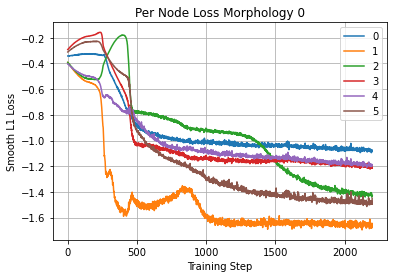

In [53]:
trainLosses = {}
testLosses = {}
validLosses = {}
trainingIdxs = []
validationIdxs = []

inputNetworkGradients = []
messageNetworkGradients = []
updateNetworkGradients = []
outputNetworkGradients = []


for morphIdx in range(7):
    trainLosses[morphIdx] = []
    testLosses[morphIdx] = []
    validLosses[morphIdx] = []

for index in [0]:
    
    inputNetwork = Network(inputSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
    messageNetwork = Network(stateSize + 1, messageSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)
    updateNetwork = Network(stateSize + messageSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
    outputNetwork = Network(stateSize, outputSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)

    gnn = GraphNeuralNetwork(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations).to(device)

    optimizer = optim.Adam(itertools.chain(inputNetwork.parameters(), messageNetwork.parameters(), updateNetwork.parameters(), outputNetwork.parameters())
                           , lr, weight_decay=1e-5)
    
    trainingIdxs = [index]
    
    for epoch in range(10):

        for morphIdx in trainingIdxs:
            permutation = np.random.permutation(X_train[morphIdx].shape[0])
            X_train[morphIdx] = X_train[morphIdx][permutation]
            Y_train[morphIdx] = Y_train[morphIdx][permutation]

        stepLoss = None
        graphs = []
        numAggregatedBatches = 0

        for batch in range(0, numTrainingBatches, numBatchesPerTrainingStep):

            inputNetwork.train()
            messageNetwork.train()
            updateNetwork.train()
            outputNetwork.train()

            t0 = time.time()

            for morphIdx in trainingIdxs:
                numNodes = (X_train[morphIdx].shape[1] - 6) // 2
                trainLosses[morphIdx].append(torch.zeros(numNodes))

            for batchOffset in range(numBatchesPerTrainingStep):

                if batch + batchOffset >= numTrainingBatches:
                    break

                for morphIdx in trainingIdxs:
                    graphs.append(env[morphIdx].get_graph()._get_dgl_graph())
                    x = X_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)
                    y = Y_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)

                    y_hat = gnn.forward(graphs[-1], x)

                    loss_tmp = criterion(y, y_hat).mean(dim=0)

                    trainLosses[morphIdx][-1] += loss_tmp.cpu().detach() / numBatchesPerTrainingStep

                    if stepLoss is None:
                        stepLoss = loss_tmp.mean()

                    else:
                        stepLoss += loss_tmp.mean()

            optimizer.zero_grad()
            stepLoss.backward()


            s = 0
            for parameter in inputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            inputNetworkGradients.append(s.item())

            s = 0
            for parameter in messageNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            messageNetworkGradients.append(s.item())

            s = 0        
            for parameter in updateNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            updateNetworkGradients.append(s.item())

            s = 0        
            for parameter in outputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            outputNetworkGradients.append(s.item())

            optimizer.step()

            stepLoss = None
            graphs = []

            inputNetwork.eval()
            messageNetwork.eval()
            updateNetwork.eval()
            outputNetwork.eval()

            numBatchesForExectution = 50
            for morphIdx in trainingIdxs:
                numNodes = (X_train[morphIdx].shape[1] - 6) // 2
                testLosses[morphIdx].append(torch.zeros(numNodes))
                for batch_ in np.random.choice(np.arange(numTestingBatches-1), numBatchesForExectution):
                    g = env[morphIdx].get_graph()._get_dgl_graph()
                    x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                    y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                    y_hat = gnn.forward(g, x)
                    loss = criterion(y, y_hat).mean(dim=0)
                    testLosses[morphIdx][-1] += loss.cpu().detach()
                testLosses[morphIdx][-1] /= numBatchesForExectution

            for morphIdx in validationIdxs:
                numNodes = (X_train[morphIdx].shape[1] // - 6) // 2
                validLosses[morphIdx].append(torch.zeros(numNodes))
                for batch_ in np.random.choice(np.arange(numTestingBatches-1), numBatchesForExectution):

                    g = env[morphIdx].get_graph()._get_dgl_graph()
                    x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                    y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)

                    y_hat = gnn.forward(g, x)
                    loss = criterion(y, y_hat).mean(dim=0)

                    validLosses[morphIdx][-1] += loss.cpu().detach()
                validLosses[morphIdx][-1] /= numBatchesForExectution

            print('\n************** Batch {} in {} **************\n'.format(batch, time.time() - t0))
            for morphIdx in trainingIdxs:
                print('Training Idx {} \nTrain Loss {} \nTest Loss {}\n'.format(morphIdx, trainLosses[morphIdx][-1], testLosses[morphIdx][-1]))
            for morphIdx in validationIdxs:
                print('Valid Idx {} | Loss {}'.format(morphIdx, validLosses[morphIdx][-1]))
                
    lossArr = torch.stack(testLosses[index]).T
    fig, ax = plt.subplots(1, sharex=True)
    for i in range(lossArr.shape[0]):
        ax.plot(range(lossArr.shape[1]), torch.log10(lossArr[i]))
    plt.legend(range(lossArr.shape[0]))
    plt.xlabel('Training Step')
    plt.grid()
    plt.ylabel('Smooth L1 Loss')
    plt.title('Per Node Loss Morphology {}'.format(index))
    plt.savefig('xv-per-node-loss-{}.jpg'.format(morphIdx))
    plt.show()

#             if batch % 20 ==0:
#                 print('Gradients: Input {} | Message {} | Update {} | Output {}'.format(
#                     inputNetworkGradients[-1], messageNetworkGradients[-1], updateNetworkGradients[-1], outputNetworkGradients[-1]))

In [ ]:
prefix = '../models/mix/'

testLossesArr = np.array(testLosses)
trainLossesArr = np.array(trainLosses)
validLossesArr = np.array(validLosses)
learningRatesArr = np.array(learningRates)

np.save(prefix + 'testLosses', testLossesArr)
np.save(prefix + 'trainLosses', trainLossesArr)
np.save(prefix + 'validLosses', validLossesArr)
np.save(prefix + 'learningRates', learningRatesArr)

# torch.save(inputNetwork, prefix + 'inputNetwork.pt')
# torch.save(outputNetwork, prefix + 'outputNetwork.pt')
# torch.save(messageNetwork, prefix + 'messageNetwork.pt')
# torch.save(updateNetwork, prefix + 'updateNetwork.pt')

fig, ax = plt.subplots(1, sharex=True)
ax.plot(range(len(testLossesArr)), testLossesArr)
ax.plot(range(len(trainLossesArr)), trainLossesArr, 'b')
ax.plot(range(len(validLossesArr)), validLossesArr)
ax.set(ylabel='Smooth L1 Loss')
# ax[1].plot(range(len(learningRates)), learningRatesArr)
# ax[1].set(ylabel='Learning Rate')
ax.legend(["Testing", "Training", "Valid"])
plt.xlabel('Batch')
plt.savefig(prefix + 'valid-0.jpg')
plt.show()

In [ ]:
prefix = '../models/mix/'

inputNetwork = torch.load(prefix + 'inputNetwork.pt')
messageNetwork = torch.load(prefix + 'messageNetwork.pt')
updateNetwork = torch.load(prefix + 'updateNetwork.pt')
outputNetwork = torch.load(prefix + 'outputNetwork.pt')

gnn = GraphNeuralNetwork(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations=3).to(device)

testLoss = 0
for morphIdx in [0]:
    
    for batch in range(numTestingBatches):

        g = env[morphIdx].get_graph()._get_dgl_graph()
        x = X_test[morphIdx][batch * batch_size:(batch+1)*batch_size].to(device)
        y = Y_test[morphIdx][batch * batch_size:(batch+1)*batch_size].to(device)

        y_hat = gnn.forward(g, x)
        loss = criterion(y, y_hat)
        testLoss += loss.item()
        
print(testLoss / X_test[morphIdx].shape[0])